In [1]:
import findspark
findspark.init()
import pyspark
from random import random
from pyspark import SparkContext

from pyspark.ml.clustering import KMeans
from pyspark.mllib.clustering import KMeans

In [2]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '12')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port,     os.getcwd().split("/")[2]


4115 srs418


In [3]:
ss = pyspark.sql.SparkSession.builder.config(conf = config).getOrCreate()
sc = ss.sparkContext

In [4]:
!ls /scratch/ISE495/2019_project_data/group-7

lyrics.csv  songdata.csv


In [ ]:
songsd = sc.textFile('/scratch/ISE495/2019_project_data/group-7/songdata.csv')
songsd.take(2)

In [4]:
song = sc.textFile('/scratch/ISE495/2019_project_data/group-7/lyrics.csv')
song.take(2)

[u'index,song,year,artist,genre,lyrics',
 u'0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?']

In [183]:
import pandas as pd

df = pd.read_csv('lyrics.csv')
print(df.head)       

<bound method NDFrame.head of          index                         song  year           artist    genre  \
0            0                    ego-remix  2009  beyonce-knowles      Pop   
1            1                 then-tell-me  2009  beyonce-knowles      Pop   
2            2                      honesty  2009  beyonce-knowles      Pop   
3            3              you-are-my-rock  2009  beyonce-knowles      Pop   
4            4                black-culture  2009  beyonce-knowles      Pop   
...        ...                          ...   ...              ...      ...   
362232  362232    who-am-i-drinking-tonight  2012       edens-edge  Country   
362233  362233                         liar  2012       edens-edge  Country   
362234  362234                  last-supper  2012       edens-edge  Country   
362235  362235  christ-alone-live-in-studio  2012       edens-edge  Country   
362236  362236                         amen  2012       edens-edge  Country   

                     

In [184]:
df['lyrics'] = df['lyrics'].str.replace('\n',' ')

print(df.head)

<bound method NDFrame.head of          index                         song  year           artist    genre  \
0            0                    ego-remix  2009  beyonce-knowles      Pop   
1            1                 then-tell-me  2009  beyonce-knowles      Pop   
2            2                      honesty  2009  beyonce-knowles      Pop   
3            3              you-are-my-rock  2009  beyonce-knowles      Pop   
4            4                black-culture  2009  beyonce-knowles      Pop   
...        ...                          ...   ...              ...      ...   
362232  362232    who-am-i-drinking-tonight  2012       edens-edge  Country   
362233  362233                         liar  2012       edens-edge  Country   
362234  362234                  last-supper  2012       edens-edge  Country   
362235  362235  christ-alone-live-in-studio  2012       edens-edge  Country   
362236  362236                         amen  2012       edens-edge  Country   

                     

In [185]:
#df__ = ss.read.csv('new_song_file', header = True, inferSchema = True)

In [186]:
#df__.show(10)

In [187]:
df['word_count'] = df['lyrics'].str.split().str.len()
print(df.head)

<bound method NDFrame.head of          index                         song  year           artist    genre  \
0            0                    ego-remix  2009  beyonce-knowles      Pop   
1            1                 then-tell-me  2009  beyonce-knowles      Pop   
2            2                      honesty  2009  beyonce-knowles      Pop   
3            3              you-are-my-rock  2009  beyonce-knowles      Pop   
4            4                black-culture  2009  beyonce-knowles      Pop   
...        ...                          ...   ...              ...      ...   
362232  362232    who-am-i-drinking-tonight  2012       edens-edge  Country   
362233  362233                         liar  2012       edens-edge  Country   
362234  362234                  last-supper  2012       edens-edge  Country   
362235  362235  christ-alone-live-in-studio  2012       edens-edge  Country   
362236  362236                         amen  2012       edens-edge  Country   

                     

In [188]:
df = df.dropna()

In [9]:
song_df = ss.createDataFrame(df)

In [10]:
song_df.show(2)

+-----+------------+----+---------------+-----+--------------------+----------+
|index|        song|year|         artist|genre|              lyrics|word_count|
+-----+------------+----+---------------+-----+--------------------+----------+
|    0|   ego-remix|2009|beyonce-knowles|  Pop|Oh baby, how you ...|     433.0|
|    1|then-tell-me|2009|beyonce-knowles|  Pop|playin' everythin...|     258.0|
+-----+------------+----+---------------+-----+--------------------+----------+
only showing top 2 rows



In [14]:
song_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- song: string (nullable = true)
 |-- year: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- word_count: double (nullable = true)



### looking for missing values

In [66]:
from pyspark.sql.functions import lit, col, sum

print("Checking for missing values")
rows = song_df.count()
summary = song_df.describe().filter(col("summary") == "count")
summary.select(*((lit(rows)-col(c)).alias(c) for c in song_df.columns)).show()

Checking for missing values
+-----+----+----+------+-----+------+----------+
|index|song|year|artist|genre|lyrics|word_count|
+-----+----+----+------+-----+------+----------+
|  0.0| 0.0| 0.0|   0.0|  0.0|   0.0|       0.0|
+-----+----+----+------+-----+------+----------+



In [173]:
print((song_df.count(), len(song_df.columns)))

(266556, 7)


## Dimensions of dataframe - 266556 rows x 7 columns

### basic operations
### let us find the following: number of artists, most songs by an artist, etc

In [70]:
## no of artists
from pyspark.sql.functions import desc

artists = song_df.select('artist').distinct().rdd.map(lambda r: r[0]).count()
song_df.select('artist').distinct().sort('artist', ascending = True).show(10)         #rdd.map(lambda r: r[0]).collect()

print("we have {} unique artists, 10 are shown above in ascending order" .format(artists))

+----------------+
|          artist|
+----------------+
|009-sound-system|
|             047|
|            0510|
|        0510-ent|
|    1-800-zombie|
|   1-girl-nation|
|      1-hundredd|
|           10-cc|
|        10-years|
|      100-demons|
+----------------+
only showing top 10 rows

we have 14543 unique artists, 10 are shown above in ascending order


In [71]:
## artists with max songs , min songs 

import pyspark.sql.functions as f

songs = song_df.groupBy('artist').count().select('artist', f.col('count').alias('number of songs')).sort('number of songs', ascending = False).show()
print("the above are artists with most number of songs")

+-----------------+---------------+
|           artist|number of songs|
+-----------------+---------------+
|     dolly-parton|            744|
|       elton-john|            676|
|      chris-brown|            628|
| barbra-streisand|            607|
|        bob-dylan|            596|
|         bee-gees|            591|
|      eddy-arnold|            591|
|           eminem|            578|
|  ella-fitzgerald|            571|
|      david-bowie|            570|
|    american-idol|            568|
|      dean-martin|            560|
|         b-b-king|            543|
|      celine-dion|            540|
|   elvis-costello|            522|
|bruce-springsteen|            509|
|       beach-boys|            495|
|    bill-anderson|            466|
|     eric-clapton|            461|
|      frank-zappa|            457|
+-----------------+---------------+
only showing top 20 rows

the above are artists with most number of songs


### looking at stats before filtering

In [49]:
##by genre

df['word_count'].groupby(df['genre']).describe()

count        mean         std  min    25%    50%    75%  \
genre                                                                       
Country         14387.0  162.334469   72.804954  1.0  113.0  149.0  200.0   
Electronic       7966.0  161.950038  120.069728  1.0   81.0  141.0  217.0   
Folk             2243.0  153.589835  106.600718  1.0   91.0  141.0  202.0   
Hip-Hop         24850.0  426.905634  212.013848  1.0  292.0  421.0  549.0   
Indie            3149.0  167.481423   94.756959  1.0  105.0  153.0  212.0   
Jazz             7971.0  146.013298   83.651256  1.0   91.0  128.0  182.5   
Metal           23759.0  142.137001   97.676448  1.0   82.0  127.0  183.0   
Not Available   23941.0  177.247191  116.720152  1.0  104.0  158.0  228.0   
Other            5189.0  188.989401  121.341803  1.0  106.0  161.0  240.0   
Pop             40466.0  206.724411  110.876533  1.0  130.0  188.0  262.0   
R&B              3401.0  191.152896  103.432485  1.0  120.0  172.0  237.0   
Rock           109235.0  161.647714   92.204563  1.0  105.0  149.0  205.0   

                  max  
genre                  
Country        1205.0  
Electronic     1667.0  
Folk           2162.0  
Hip-Hop        7106.0  
Indie          1099.0  
Jazz            821.0  
Metal          2104.0  
Not Available  2319.0  
Other          1412.0  
Pop            1366.0  
R&B            1178.0  
Rock           5474.0

looking at some artists in sorted order:


index                                         song  year  \
7294      7294   bill-bailey-wonu2019t-you-please-come-home  2014   
276467  276467                                  the-jeffrey  2006   
284501  284501                    back-in-your-own-backyard  2007   
283067  283067                           part-of-your-world  2013   
212297  212297                           frosty-the-snowman  2015   
105610  105610                my-kind-of-girl-my-kinda-girl  2008   
318570  318570  tie-a-yellow-ribbon-round-the-oild-oak-tree  2007   
339343  339343                     du-trefonds-des-tenebres  2006   
173106  173106                                        ameno  2002   
216666  216666                            take-me-to-church  2015   

                  artist          genre  \
7294         bobby-darin           Jazz   
276467       brave-combo           Rock   
284501        brenda-lee           Rock   
283067  carly-rae-jepsen            Pop   
212297   christmas-songs          Other   
105610       collin-raye        Country   
318570      connie-smith        Country   
339343             elend  Not Available   
173106        eric-lasvi          Other   
216666         glee-cast  Not Available   

                                                   lyrics  word_count  
7294    Hey, Bill Bailey, don't look now but somebody'...       243.0  
276467  I am the master of my own universe And I dance...       129.0  
284501  We leave home expecting to find a blue bird, H...       131.0  
283067  Look at this stuff Isn't it neat? Wouldn't you...       316.0  
212297  [Verse 1] Frosty the snowman was a jolly happy...       241.0  
105610  When I saw you buyin' Cosmo and a Hot Rod maga...       226.0  
318570  TIE A YELLOW RIBBON 'ROUND THE OLD OAK TREE Wr...       242.0  
339343  Horror, Lucifer solutus, Anguis a catenis suis...       302.0  
173106  Dori me interimo Adapare Dori me Ameno Ameno L...       145.0  
216666  Roderick: My lover's got humour She's the gigg...       524.0

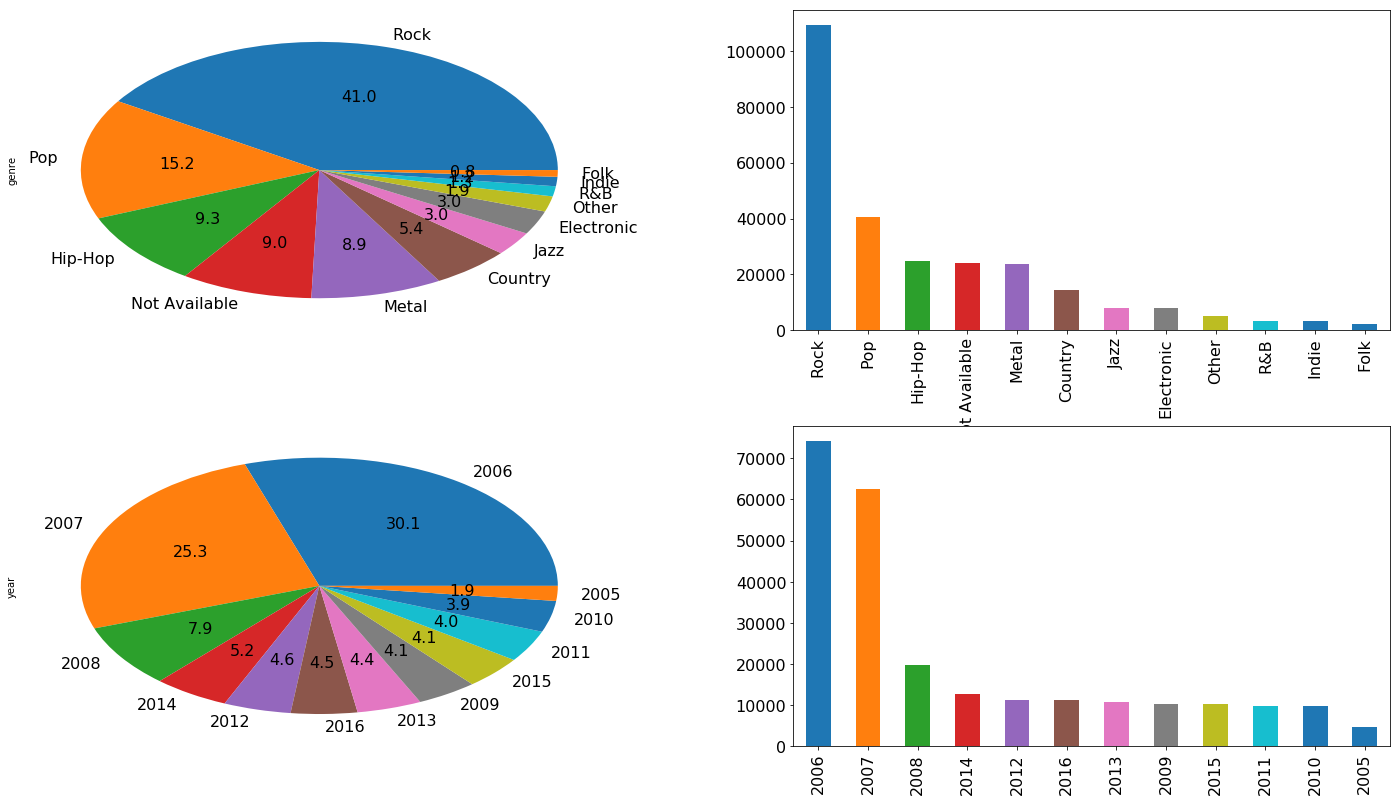

In [25]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

genreCount = df['genre'].value_counts()
yearCount  = df['year'].value_counts().head( 12 )
wordCount = df['word_count'].value_counts()

fig, axarr = plt.subplots(2, 2)
fig.tight_layout()


genreCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[0][0] , autopct='%.1f' )
genreCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[0][1] )

yearCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[1][0], autopct='%.1f' )
yearCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[1][1] )

#wordCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[1][0], autopct='%.1f' )
#wordCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[1][1] )


print("looking at some artists in sorted order:")
df.sample(n=10).sort_values('artist')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2068D7F88>]],
      dtype=object)

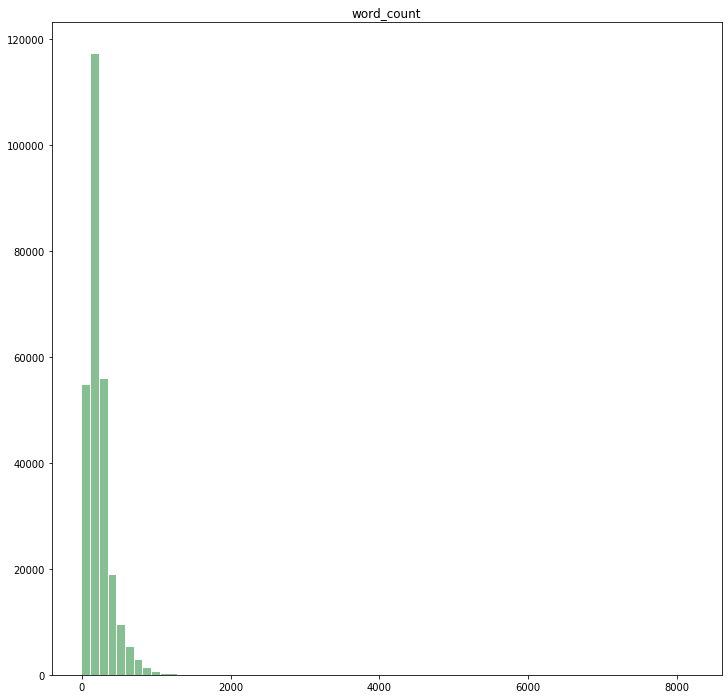

In [189]:
df.hist(column='word_count',bins=70, grid=False, figsize=(12,12), color='#86bf91', zorder=2, rwidth=0.9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2707BFF08>]],
      dtype=object)

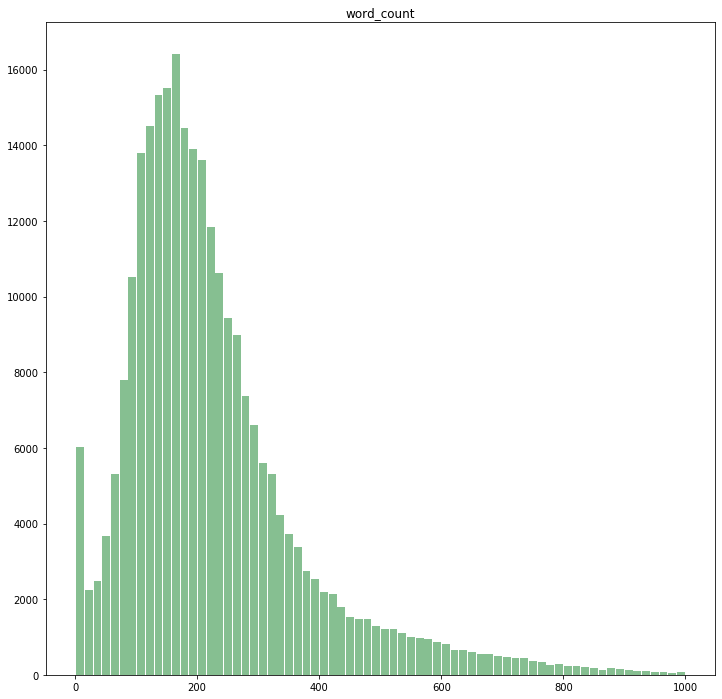

In [123]:
df_clean.hist(column='word_count',bins=70, grid=False, figsize=(12,12), color='#86bf91', zorder=2, rwidth=0.9)

### filter from here

In [190]:
## there are songs with 1 word in lyrics.. lets take threshold = 100 words
## there are also songs with count = 1, lets filter those
song_df = song_df.filter(song_df.word_count >= 100)
song_df = song_df.filter(song_df.word_count <= 1500)
song_df.show(10)

NameError: name 'song_df' is not defined

In [15]:
print((song_df.count(), len(song_df.columns)))

(229220, 7)


In [11]:
from pyspark.sql import Window
import pyspark.sql.functions as f

w = Window.partitionBy('artist')
song_df = song_df.withColumn('number_of_songs', f.count('artist').over(w)).sort('artist', 'song')
song_df.show(10)

+------+-------------------+----+----------------+-------------+--------------------+----------+---------------+
| index|               song|year|          artist|        genre|              lyrics|word_count|number_of_songs|
+------+-------------------+----+----------------+-------------+--------------------+----------+---------------+
|331868|  born-to-be-wasted|2011|009-sound-system|          Pop|Oh the beat's gon...|     119.0|              3|
|331869|    speak-to-angels|2015|009-sound-system|          Pop|I was there when ...|     161.0|              3|
|331871|      with-a-spirit|2014|009-sound-system|          Pop|You can be Whatev...|     154.0|              3|
|271937|keep-it-to-yourself|2014|             047|          Pop|Aaah, ah-aaah Is ...|     198.0|              1|
|155200|           monsters|2013|            0510|Not Available|Bradley Too much ...|     575.0|              1|
|210418|           monsters|2013|        0510-ent|Not Available|Bradley Too much ...|     575.0|

In [12]:
song_df = song_df.filter(song_df.number_of_songs >= 15)
song_df.show(10)

+------+--------------------+----+------+-----+--------------------+----------+---------------+
| index|                song|year|artist|genre|              lyrics|word_count|number_of_songs|
+------+--------------------+----+------+-----+--------------------+----------+---------------+
|238147|            24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142|
|238097|action-man-in-a-m...|2006| 10-cc| Rock|Let's stay a whil...|     261.0|            142|
|238176|      age-of-consent|1995| 10-cc| Rock|I want to meet yo...|     263.0|            142|
|238127|   american-panorama|2006| 10-cc| Rock|Martin Luther B.B...|     210.0|            142|
|238132|  americana-panorama|2006| 10-cc| Rock|Martin Luther B.B...|     210.0|            142|
|238204|  art-for-art-s-sake|2008| 10-cc| Rock|Gimme your body G...|     220.0|            142|
|238073|   art-for-arts-sake|2009| 10-cc| Rock|Gimme your body G...|     220.0|            142|
|238162|        baron-samedi|2006| 10-cc

In [18]:
print((song_df.count(), len(song_df.columns)))

(204321, 8)


### looking at stats after filtering

In [17]:
## no of artists
from pyspark.sql.functions import desc

artists = song_df.select('artist').distinct().rdd.map(lambda r: r[0]).count()
song_df.select('artist').distinct().sort('artist', ascending = True).show(10)         #rdd.map(lambda r: r[0]).collect()

print("we have {} unique artists after filtering, 10 are shown above in ascending order" .format(artists))

+-------------+
|       artist|
+-------------+
|1-girl-nation|
|        10-cc|
|     10-years|
|  100-monkeys|
|10000-maniacs|
|          112|
|    12-stones|
|   13-engines|
|       14-bis|
|16-horsepower|
+-------------+
only showing top 10 rows

we have 4870 unique artists after filtering, 10 are shown above in ascending order


In [153]:
## artists with max songs , min songs 

import pyspark.sql.functions as f
print("the following are artists with most number of songs, after filtering")
songs = song_df.groupBy('artist').count().select('artist', f.col('count').alias('number of songs')).sort('number of songs', ascending = False).show()


the following are artists with most number of songs, after filtering
+-----------------+---------------+
|           artist|number of songs|
+-----------------+---------------+
|     dolly-parton|            707|
|      chris-brown|            610|
|       elton-john|            607|
|        bob-dylan|            561|
|         bee-gees|            546|
|           eminem|            546|
|    american-idol|            533|
|      celine-dion|            530|
|   elvis-costello|            503|
|      david-bowie|            503|
| barbra-streisand|            502|
|bruce-springsteen|            497|
|         b-b-king|            487|
|      dean-martin|            445|
|  ella-fitzgerald|            444|
|    bill-anderson|            430|
|      eddy-arnold|            426|
|       beach-boys|            410|
|   britney-spears|            393|
|   chamillionaire|            388|
+-----------------+---------------+
only showing top 20 rows



In [155]:
## artists with max songs , min songs 

import pyspark.sql.functions as f
print("the following are artists with least number of songs, after filtering")
songs = song_df.groupBy('artist').count().select('artist', f.col('count').alias('number of songs')).sort('number of songs', ascending = True).show()


the following are artists with least number of songs, after filtering
+--------------------+---------------+
|              artist|number of songs|
+--------------------+---------------+
|         avi-buffalo|             10|
|        alex-winston|             10|
|   caught-in-the-act|             10|
| artificial-joy-club|             10|
|     fred-eaglesmith|             10|
|              drapht|             10|
|               crest|             10|
|           a-m-drive|             10|
|carrie-hope-fletcher|             10|
|erik-goes-to-germany|             10|
|       38th-parallel|             10|
|      calvert-robert|             10|
|andrew-jackson-jihad|             10|
|     buffalocomotive|             10|
|      the-blaqk-year|             10|
|      donnie-trumpet|             10|
|          bang-tango|             10|
|       above-the-law|             10|
|        ashes-divide|             10|
|       george-nozuka|             10|
+--------------------+-----------

looking at some artists in sorted order:


index                              song  year                artist  \
51901    19039                 memorie-di-giulia  2006       battiato-franco   
78884    33931  look-into-my-eyez-atlantis-remix  2006  bone-thugs-n-harmony   
97794   214140                            heaven  2007                canaan   
102852   39531                        get-off-it  2006                casual   
117852  108507               hey-you-outside-now  2006           chumbawamba   
146604  124574                       biggest-fan  2010          dawn-richard   
157501  186598             i-saw-linda-yesterday  2008            dickey-lee   
182412   76943                       forgiveness  2012                 elisa   
211707  282791                   songs-for-women  2011           frank-ocean   
235147   86179                  independence-day  2007          the-bruisers   

          genre                                             lyrics  \
51901      Rock  Quel letto d'ottone in cui mi accoglievi giovi...   
78884   Hip-Hop  We thuggish ruggish niggas always, always And ...   
97794      Rock  Ascolta il riverbero del silenzio sul fondo de...   
102852  Hip-Hop  Intro: Hah, ay youknowhatI'msayin Hieroglyphic...   
117852     Rock  One year later This queue never moved I've got...   
146604      Pop  Tell the truth boy you want me to work you I c...   
157501     Rock  I Saw Linda Yesterday Dickey Lee Written by Di...   
182412     Rock  I'm lost and scared to live this life I though...   
211707      Pop  When I was younger I used to wonder like If I ...   
235147     Rock  I stood in the middle Watching the scene all a...   

        word_count  number_of_songs  
51901        178.0              139  
78884        971.0              267  
97794         18.0               33  
102852       431.0               20  
117852       217.0              423  
146604       647.0               94  
157501       209.0               62  
182412       169.0               92  
211707       297.0              129  
235147       132.0               45

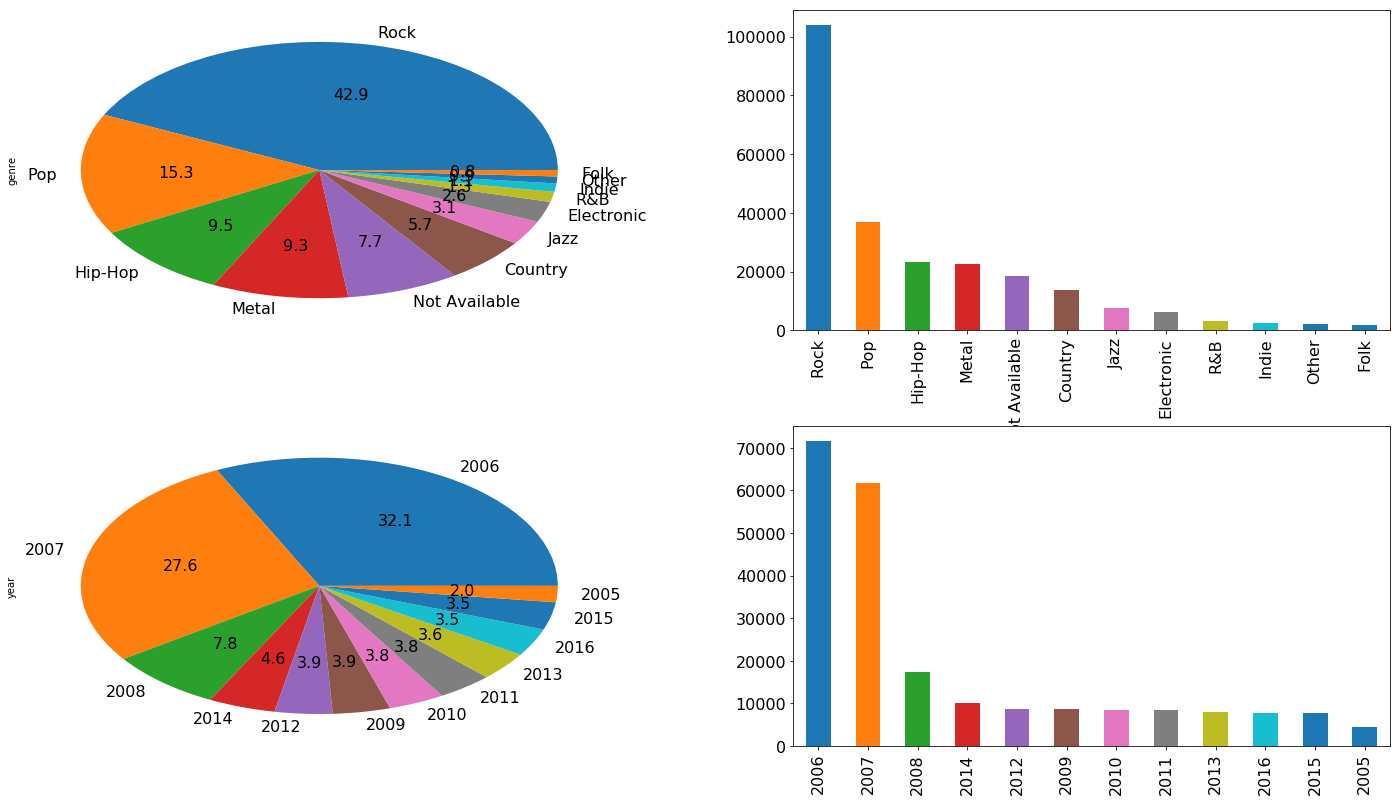

In [79]:
### filtered data where artists had less than 10 songs and where song lyrics had less than 100 words

## looking at updated stats

df = song_df.toPandas()
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

genreCount = df['genre'].value_counts()
yearCount  = df['year'].value_counts().head( 12 )
wordCount = df['word_count'].value_counts()

fig, axarr = plt.subplots(2, 2)
fig.tight_layout()


genreCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[0][0] , autopct='%.1f' )
genreCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[0][1] )

yearCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[1][0], autopct='%.1f' )
yearCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[1][1] )

#wordCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[1][0], autopct='%.1f' )
#wordCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[1][1] )


print("looking at some artists in sorted order:")
df.sample(n=10).sort_values('artist')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb98f372990>]],
      dtype=object)

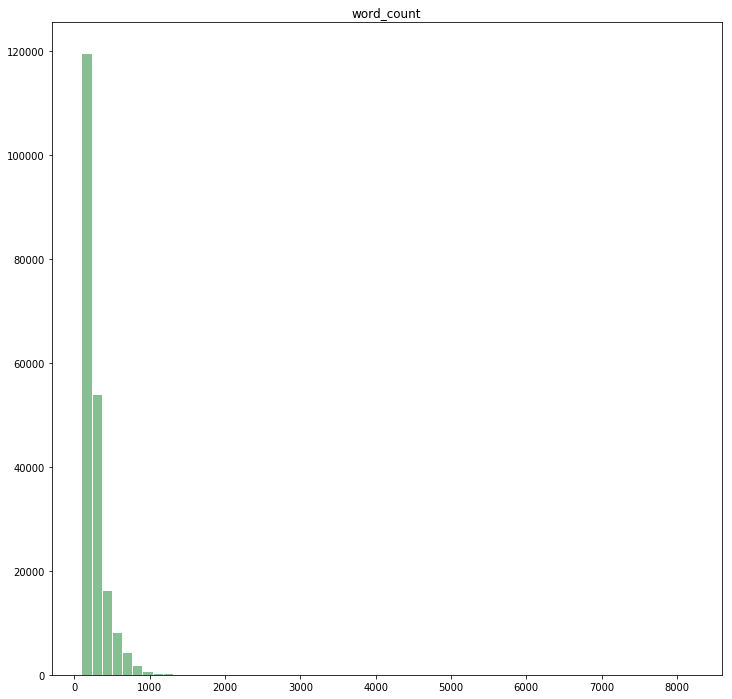

In [28]:
songDF.hist(column='word_count',bins=60, grid=False, figsize=(12,12), color='#86bf91', zorder=2, rwidth=0.9)

In [156]:
print((song_df.count(), len(song_df.columns)))

(204321, 8)


### songs, and artists have been filtered

In [58]:
song_df.describe().show()

+-------+------------------+--------------------+-----------------+------------------+-------+--------------------+------------------+
|summary|             index|                song|             year|            artist|  genre|              lyrics|        word_count|
+-------+------------------+--------------------+-----------------+------------------+-------+--------------------+------------------+
|  count|            229289|              229289|           229289|            229289| 229289|              229289|            229289|
|   mean| 182002.4290698638|3.101596456763466E11|2007.731339052462| 683.0853391684901|   null|                null|254.28280030878062|
| stddev|103949.26554499482|5.599465208038821E12|9.915039634811746|1432.4328217245966|   null|                null|153.00604777827195|
|    min|                 0|                 0-0|              112|  009-sound-system|Country|Where were you w...|             100.0|
|    max|            362236|               zzzzz|      

### we have songs from the year 112.... let us take after 1950

In [13]:
song_df = song_df.filter(song_df.year >= 1950)
song_df.sort('year', ascending = True).show(10)

+------+--------------------+----+-------------+-----+--------------------+----------+---------------+
| index|                song|year|       artist|genre|              lyrics|word_count|number_of_songs|
+------+--------------------+----+-------------+-----+--------------------+----------+---------------+
|124916|         without-you|1968|fleetwood-mac| Rock|I'm crazy for my ...|     107.0|            253|
|314863|     good-vibrations|1970|   beach-boys| Rock|I, I love the col...|     303.0|            410|
|230716|you-re-still-my-w...|1970|     b-b-king| Rock|When I come home ...|     212.0|            487|
|314865|    california-girls|1970|   beach-boys| Rock|Well East coast g...|     219.0|            410|
|230717|      go-underground|1970|     b-b-king| Rock|Yes, you thought ...|     194.0|            487|
|230723|   chains-and-things|1970|     b-b-king| Rock|Woke up this morn...|     177.0|            487|
|314856|      god-only-knows|1970|   beach-boys| Rock|I may not always ..

### stats by genre

In [14]:
songDF = song_df.toPandas()

In [38]:
songDF['word_count'].groupby(songDF['genre']).describe()

count        mean         std    min    25%    50%    75%  \
genre                                                                        
Country        12426.0  197.093755   78.293376  100.0  139.0  179.0  237.0   
Electronic      4408.0  238.347096  121.318848  100.0  152.0  209.0  288.0   
Folk            1495.0  218.103679  114.304898  100.0  149.0  194.0  260.0   
Hip-Hop        22016.0  516.265716  224.004647  100.0  368.0  503.0  642.0   
Indie           2137.0  220.342536  101.574259  100.0  152.0  199.0  261.0   
Jazz            5863.0  196.652567   90.497904  100.0  133.0  172.0  233.0   
Metal          16188.0  207.087905  105.890792  100.0  139.0  181.0  243.0   
Not Available  14773.0  236.693495  114.946177  100.0  158.0  209.0  283.0   
Other           1579.0  249.805573  140.503669  100.0  152.0  210.0  303.0   
Pop            33741.0  262.188198  121.838124  100.0  173.0  236.0  321.0   
R&B             2746.0  241.007647  113.519591  100.0  162.0  216.0  290.0   
Rock           86949.0  213.387837   98.706052  100.0  148.0  194.0  255.0   

                  max  
genre                  
Country        1366.0  
Electronic     1068.0  
Folk           2393.0  
Hip-Hop        8195.0  
Indie          1050.0  
Jazz           1040.0  
Metal          2423.0  
Not Available  2269.0  
Other          1385.0  
Pop            1704.0  
R&B            1440.0  
Rock           6232.0

### song_df --> spark dataframe
### songDF --> pandas dataframe

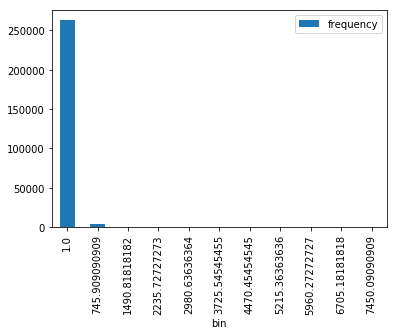

In [40]:
song_df = song_df.select('word_count').rdd.flatMap(lambda x: x).histogram(11)
pd.DataFrame(list(zip(*song_df)), columns=['bin', 'frequency']).set_index('bin').plot(kind='bar')

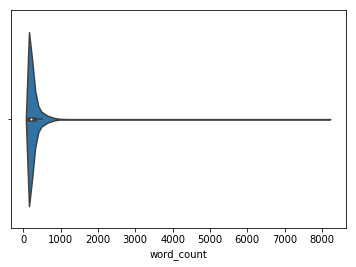

In [23]:
import seaborn as sns
sns.violinplot(x=songDF["word_count"], figsize = (20,12))

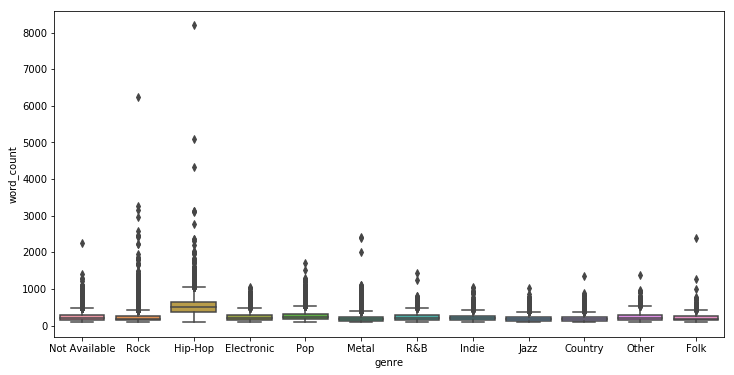

In [25]:
## for a clear picture, let us look at work count by genre
import seaborn as sns
#compare wordcounts by genre
import matplotlib as mpl
mpl.rc("figure", figsize=(12, 6))
sns.boxplot(x="genre", y="word_count", data=songDF)

## looks like hip-hop artists sometimes use a large number of words in their songs.. there are some heavy outliers.. maybe we can remove some songs with too many words

### total unique artists

In [42]:
## by artist
print("we have 4870 unique artists after filtering")
songDF['word_count'].groupby(songDF['artist']).describe()

we have 4870 unique artists after filtering


count        mean         std  \
artist                                                                       
1-girl-nation                                 10.0  352.700000   75.277339   
10-cc                                        142.0  252.732394   84.838429   
10-years                                      70.0  190.800000   64.586444   
100-monkeys                                   29.0  218.000000   83.228172   
10000-maniacs                                 79.0  190.670886   58.044130   
112                                           86.0  372.837209  150.155281   
12-stones                                     53.0  209.245283   60.423794   
13-engines                                    11.0  132.545455   21.593349   
14-bis                                        30.0  120.133333   17.395468   
16-horsepower                                 37.0  168.297297   48.003394   
1997                                          12.0  249.666667  122.738698   
2-brothers-on-the-4th-floor                   13.0  319.153846  139.869490   
2-chainz                                     120.0  516.325000  159.181423   
2-live-crew                                   78.0  430.858974  154.939345   
2-pistols                                     19.0  442.947368  208.888719   
2-skinnee-js                                  26.0  340.153846  112.627063   
2-unlimited                                   51.0  294.823529   91.484361   
21-savage                                     19.0  475.157895  126.086065   
213                                           20.0  477.900000  108.243828   
28-days                                       32.0  232.593750  105.817512   
2am-club                                      18.0  418.777778   93.173813   
2gether                                       29.0  292.068966   93.440558   
2merica                                       10.0  195.600000   69.245457   
2ne1                                          38.0  381.552632  227.704016   
2pac                                         360.0  674.963889  238.482216   
2pm                                           24.0  352.833333  197.859341   
2raumwohnung                                  10.0  176.200000   52.681011   
3-colours-red                                 24.0  168.875000   37.050274   
3-doors-down                                  87.0  246.425287   65.852660   
3-inches-of-blood                             12.0  226.833333   50.655401   
...                                            ...         ...         ...   
the-frankenstein-drag-queens-from-planet-13   37.0  160.459459   52.991401   
the-free                                      30.0  191.100000   56.614455   
the-friday-night-boys                         12.0  288.416667   41.907817   
the-fugees                                    43.0  586.860465  271.526161   
the-gabe-dixon-band                           15.0  208.466667   66.544149   
the-gamits                                    20.0  161.100000   37.619844   
the-gap-band                                  19.0  334.842105  149.614788   
the-gaslight-anthem                           71.0  292.112676   73.360275   
the-gathering                                 49.0  143.653061   33.742623   
the-gathering-field                           46.0  204.478261   63.257056   
the-gatlin-brothers                           11.0  223.272727   82.250946   
the-gay-blades                                10.0  202.800000   29.260516   
the-gc5                                       30.0  153.466667   33.368097   
the-generators                                31.0  189.225806   83.129501   
the-genius-gza                                65.0  508.107692  170.477924   
the-get-up-kids                               69.0  156.869565   46.027777   
the-getaway-people                            16.0  227.062500   81.816436   
the-getaway-plan                              11.0  211.181818   82.861111   
the-ghost-inside                              12.0  237.000000   57

In [43]:
songDF['number_of_songs'].groupby(songDF['artist']).describe()

count   mean  std    min    25%  \
artist                                                                         
1-girl-nation                                 10.0   10.0  0.0   10.0   10.0   
10-cc                                        142.0  142.0  0.0  142.0  142.0   
10-years                                      70.0   70.0  0.0   70.0   70.0   
100-monkeys                                   29.0   29.0  0.0   29.0   29.0   
10000-maniacs                                 79.0   79.0  0.0   79.0   79.0   
112                                           86.0   86.0  0.0   86.0   86.0   
12-stones                                     53.0   53.0  0.0   53.0   53.0   
13-engines                                    11.0   11.0  0.0   11.0   11.0   
14-bis                                        30.0   30.0  0.0   30.0   30.0   
16-horsepower                                 37.0   37.0  0.0   37.0   37.0   
1997                                          12.0   12.0  0.0   12.0   12.0   
2-brothers-on-the-4th-floor                   13.0   13.0  0.0   13.0   13.0   
2-chainz                                     120.0  120.0  0.0  120.0  120.0   
2-live-crew                                   78.0   78.0  0.0   78.0   78.0   
2-pistols                                     19.0   19.0  0.0   19.0   19.0   
2-skinnee-js                                  26.0   26.0  0.0   26.0   26.0   
2-unlimited                                   51.0   51.0  0.0   51.0   51.0   
21-savage                                     19.0   19.0  0.0   19.0   19.0   
213                                           20.0   20.0  0.0   20.0   20.0   
28-days                                       32.0   32.0  0.0   32.0   32.0   
2am-club                                      18.0   18.0  0.0   18.0   18.0   
2gether                                       29.0   29.0  0.0   29.0   29.0   
2merica                                       10.0   10.0  0.0   10.0   10.0   
2ne1                                          38.0   38.0  0.0   38.0   38.0   
2pac                                         360.0  360.0  0.0  360.0  360.0   
2pm                                           24.0   24.0  0.0   24.0   24.0   
2raumwohnung                                  10.0   10.0  0.0   10.0   10.0   
3-colours-red                                 24.0   24.0  0.0   24.0   24.0   
3-doors-down                                  87.0   87.0  0.0   87.0   87.0   
3-inches-of-blood                             12.0   12.0  0.0   12.0   12.0   
...                                            ...    ...  ...    ...    ...   
the-frankenstein-drag-queens-from-planet-13   37.0   37.0  0.0   37.0   37.0   
the-free                                      30.0   30.0  0.0   30.0   30.0   
the-friday-night-boys                         12.0   12.0  0.0   12.0   12.0   
the-fugees                                    43.0   43.0  0.0   43.0   43.0   
the-gabe-dixon-band                           15.0   15.0  0.0   15.0   15.0   
the-gamits                                    20.0   20.0  0.0   20.0   20.0   
the-gap-band                                  19.0   19.0  0.0   19.0   19.0   
the-gaslight-anthem                           71.0   71.0  0.0   71.0   71.0   
the-gathering                                 49.0   49.0  0.0   49.0   49.0   
the-gathering-field                           46.0   46.0  0.0   46.0   46.0   
the-gatlin-brothers                           11.0   11.0  0.0   11.0   11.0   
the-gay-blades                                10.0   10.0  0.0   10.0   10.0   
the-gc5                                       30.0   30.0  0.0   30.0   30.0   
the-generators                                31.0   31.0  0.0   31.0   31.0   
the-genius-gza                                65.0   65.0  0.0   65.0   65.0   
the-get-up-kids                               69.0   69.0  0.0   69.0   69.0   
the-getaway-people                            16.0   16.0  0.0   16.0   16.0   
the-getaway-plan                             

### distribution of lyrics

In [44]:
## artists with max songs , min songs 

import pyspark.sql.functions as f
print("the following are artists with most number of songs, after filtering")
songs = song_df.groupBy('artist').count().select('artist', f.col('count').alias('number of songs')).sort('number of songs', ascending = False).show()

the following are artists with most number of songs, after filtering
+-----------------+---------------+
|           artist|number of songs|
+-----------------+---------------+
|     dolly-parton|            707|
|      chris-brown|            610|
|       elton-john|            607|
|        bob-dylan|            561|
|           eminem|            546|
|         bee-gees|            546|
|    american-idol|            533|
|      celine-dion|            530|
|   elvis-costello|            503|
|      david-bowie|            503|
| barbra-streisand|            502|
|bruce-springsteen|            497|
|         b-b-king|            487|
|      dean-martin|            445|
|  ella-fitzgerald|            444|
|    bill-anderson|            430|
|      eddy-arnold|            426|
|       beach-boys|            410|
|   britney-spears|            393|
|   chamillionaire|            388|
+-----------------+---------------+
only showing top 20 rows



NameError: name 'songDF' is not defined

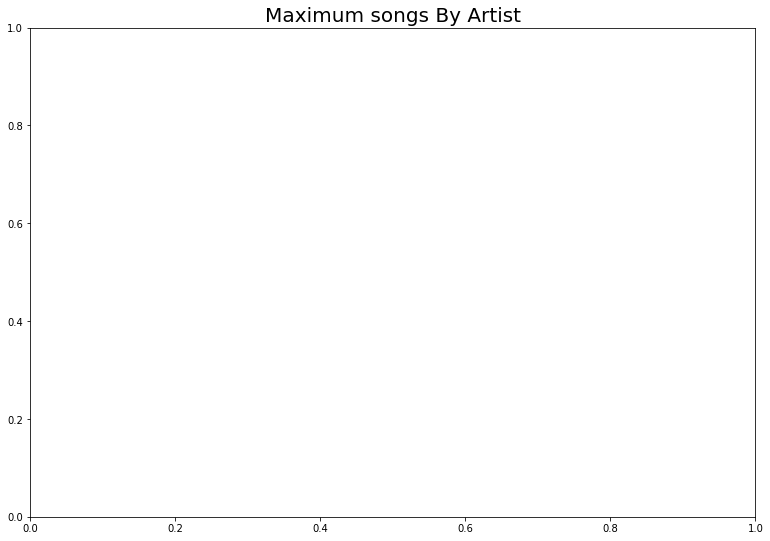

In [247]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,9))
plt.title("Maximum songs By Artist",fontsize=20)
songDF['artist'].value_counts()[:30].plot('bar',color='purple')

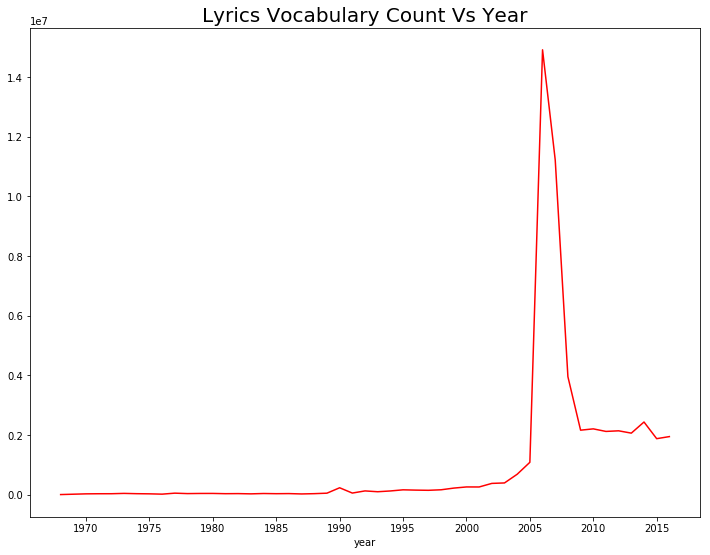

In [50]:
import numpy as np

x = [1970, 1975, 1080, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]
Total_year_count = songDF.groupby(['year'])['word_count'].sum()
plt.figure(figsize=(12,9))
plt.xticks(np.arange(min(x), max(x), 5.0))
plt.title("Lyrics Vocabulary Count Vs Year",fontsize=20)
Total_year_count.plot(kind='line',color="Red")

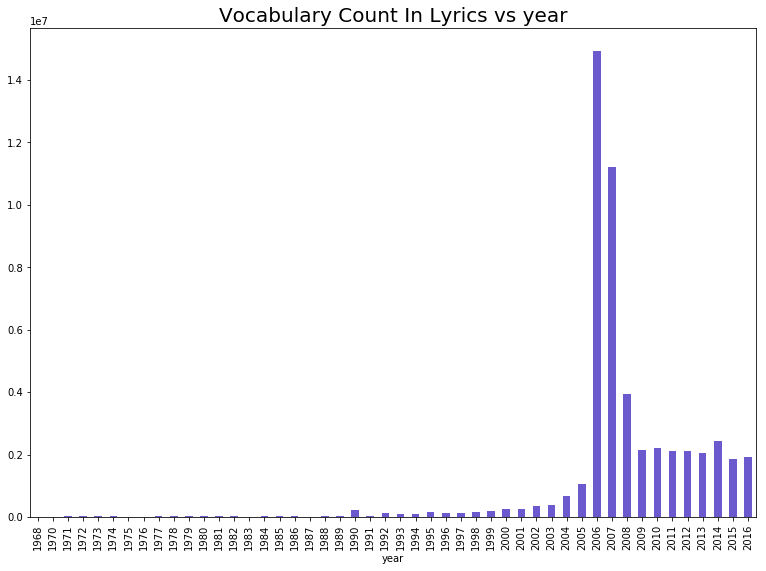

In [51]:
plt.figure(figsize=(13,9))
plt.title("Vocabulary Count In Lyrics vs year",fontsize=20)
Total_year_count.plot(kind='bar',label="Lyrics count vs year",color = 'slateblue')

In [46]:
## artists with max songs , min songs 

import pyspark.sql.functions as f
print("the following are artists with least number of songs, after filtering")
songs = song_df.groupBy('artist').count().select('artist', f.col('count').alias('number of songs')).sort('number of songs', ascending = True).show()

the following are artists with least number of songs, after filtering
+--------------------+---------------+
|              artist|number of songs|
+--------------------+---------------+
|              drapht|             10|
|     fred-eaglesmith|             10|
|andrew-jackson-jihad|             10|
|               damez|             10|
|                daze|             10|
|   caught-in-the-act|             10|
|carrie-hope-fletcher|             10|
|       george-nozuka|             10|
|  eric-michael-jones|             10|
|erik-goes-to-germany|             10|
|     balkan-beat-box|             10|
|        alex-winston|             10|
|               crest|             10|
|         avi-buffalo|             10|
|       38th-parallel|             10|
|      donnie-trumpet|             10|
|      the-blaqk-year|             10|
|    the-black-ghosts|             10|
|                farm|             10|
|          bang-tango|             10|
+--------------------+-----------

### cleaning the data further

In [15]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
import gensim.models.word2vec as w2v
import multiprocessing
import os
import re
import sklearn
import pprint
import seaborn as sns
%matplotlib inline
#stop = stopwords.words('english')

In [16]:
## create tokenizer, remove all the stopwords including \

from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import Tokenizer, RegexTokenizer

In [52]:
#Tokenizer = RegexTokenizer(inputCol="lyrics", outputCol="lyrics_tokenized", pattern= ",")
#cv = CountVectorizer(inputCol="lyrics", outputCol="cv_ingred_sparse", vocabSize=1000000, minDF=2.0)


In [53]:
#regexTokenized_ = Tokenizer.transform(Tokenized_df)

In [54]:
#regexTokenized_.show(2)

In [55]:
#regexTokenized_.select('lyrics_tokenized').rdd.flatMap(list).take(12)

In [56]:
##Tokenizer1 = RegexTokenizer(inputCol="lyrics_tokenized", outputCol="lyrics_tokenized_by_delim", pattern= "'")
#Tokenized_df1 = Tokenizer1.transform(regexTokenized_)
#Tokenized_df1.show(2)

In [57]:
#Tokenized_df1.select('lyrics_tokenized_by_delim').rdd.flatMap(list).take(12)

In [37]:
#Tokenizer2 = RegexTokenizer(inputCol="lyrics", outputCol="lyrics_tokenized_by_backslash", pattern= "/")
#Tokenized_df2 = Tokenizer2.transform(Tokenized_df1)
#Tokenized_df2.show(2)

In [39]:
# count number of lines
songDF['lines'] = songDF['lyrics'].map(lambda t: len(re.findall(r'/', t)))
songDF.head()
print ("there are {} / kind of characters in the column lyrics" .format(sum(songDF['lines'])))
# remove line breaks


there are 13223 / kind of characters in the column lyrics


### removing '/', ' '
### to remove ' ', we use /W+

In [17]:
songDF['lyrics'] = songDF['lyrics'].map(lambda s: re.sub(r' /|/', '', s))
#songDF['lyrics'] = songDF['lyrics'].map(lambda s: re.sub(r '!()-[]{};:\,<>./?@#$%^&*_', '', s))

In [18]:
# count number of lines
songDF['lines'] = songDF['lyrics'].map(lambda t: len(re.findall(r'/', t)))
songDF.head()
print ("there are {} / kind of characters in the column lyrics" .format(sum(songDF['lines'])))
# remove line breaks

there are 0 / kind of characters in the column lyrics


In [19]:
# count number of lines
songDF['this'] = songDF['lyrics'].map(lambda t: len(re.findall(r' ''', t)))
songDF.head()
print ("there are {} kind of characters in the column lyrics" .format(sum(songDF['this'])))
# remove ''

there are 47974905 kind of characters in the column lyrics


In [20]:
songDF['lyrics_cleaned'] = songDF['lyrics'].map(lambda s: re.sub(r'\W+',' ', s))

In [49]:
#songDF['result'] = songDF['lyrics'].map(lambda x: x.lstrip(' '' ').rstrip(''))

In [21]:
songDF

index                                               song  year  \
0       198081                                      1-girl-nation  2014   
1       198073                                             cinema  2016   
2       198075                                           get-hype  2016   
3       198074                                   guard-your-heart  2016   
4       198076                                             haters  2016   
5       198077                                         impossible  2016   
6       198078                                           nofilter  2016   
7       198072                                              panic  2016   
8       198079                                          try-cover  2014   
9       198071                                  while-we-re-young  2013   
10      238147                                           24-hours  2006   
11      238097                        action-man-in-a-motown-suit  2006   
12      238176                                     age-of-consent  1995   
13      238127                                  american-panorama  2006   
14      238132                                 americana-panorama  2006   
15      238204                                 art-for-art-s-sake  2008   
16      238073                                  art-for-arts-sake  2009   
17      238162                                       baron-samedi  2006   
18      238082                                          blackmail  1975   
19      238198                                          blackmail  2008   
20      238173                                           bluebird  1995   
21      238080                                      brand-new-day  1975   
22      238065                                           bus-stop  2009   
23      238205                                    channel-swimmer  2008   
24      238138                             charity-begins-at-home  2006   
25      238129                                        city-lights  2006   
26      238115                                    clockwork-creep  2006   
27      238172                                    code-of-silence  1995   
28      238169                                                cry  2016   
29      238091                                    deadlock-melody  2006   
...        ...                                                ...   ...   
204222  194234                                           appetite  2010   
204223  194237                                             closer  2010   
204224  194242                                        crying-time  2010   
204225  194241                                       guilty-fever  2010   
204226  194243                                         honest-man  2010   
204227  194244                                   nothing-but-love  2010   
204228  194236                                            the-few  2010   
204229  194233                                    the-rest-of-you  2010   
204230  194235                                           tredecim  2010   
204231  194245                                        whats-wrong  2010   
204232  212152                                           comedown  2013   
204233  212171                               do-what-you-gotta-do  2014   
204234  212167                                         dusty-dusk  2014   
204235  212164                                           enigma-2  2015   
204236  212159                             fifty-seconds-of-noise  2015   
204237  212158                                          get-fined  2015   
204238  212153                                          last-call  2013   
204239  212151                                             moscow  2013   
204240  212166  my-dusty-parabole-can-t-receive-your-foreign-s...  2015   
204241  212155                                              myana  2015   
204242  212163                                             nodnol  2015   
204243  212160                    

In [21]:
# count number of lines
songDF['this'] = songDF['lyrics_cleaned'].map(lambda t: len(re.findall(r'\W+', t)))
songDF.head()
print ("there are {} kind of characters in the column lyrics" .format(sum(songDF['this'])))
# remove ''

there are 50642552 kind of characters in the column lyrics


In [22]:
songDF['newLines'] = songDF['lyrics'].map(lambda t: len(re.findall(r'\n', t)))
songDF.head()

index                         song  year artist genre  \
0  238147                     24-hours  2006  10-cc  Rock   
1  238097  action-man-in-a-motown-suit  2006  10-cc  Rock   
2  238176               age-of-consent  1995  10-cc  Rock   
3  238127            american-panorama  2006  10-cc  Rock   
4  238132           americana-panorama  2006  10-cc  Rock   

                                              lyrics  word_count  \
0  Here on the street Feeling the cool of the daw...       356.0   
1  Let's stay a while and watch him He's moving i...       261.0   
2  I want to meet you at that restaurant The one ...       263.0   
3  Martin Luther B.B. King You had a dream and yo...       210.0   
4  Martin Luther B.B. King You had a dream and yo...       210.0   

   number_of_songs  lines  this  \
0              142      0   374   
1              142      0   286   
2              142      0   277   
3              142      0   220   
4              142      0   220   

                                      lyrics_cleaned  newLines  
0  Here on the street Feeling the cool of the daw...         0  
1  Let s stay a while and watch him He s moving i...         0  
2  I want to meet you at that restaurant The one ...         0  
3  Martin Luther B B King You had a dream and you...         0  
4  Martin Luther B B King You had a dream and you...         0

In [23]:
songDF = songDF.drop(columns = ['newLines'], axis = 1)
songDF = songDF.drop(columns = ['lines'], axis = 1)
songDF = songDF.drop(columns = ['this'], axis = 1)
#songDF = songDF.drop(columns = ['result'], axis = 1)

In [31]:
songDF.head()

index                         song  year artist genre  \
0  238147                     24-hours  2006  10-cc  Rock   
1  238097  action-man-in-a-motown-suit  2006  10-cc  Rock   
2  238176               age-of-consent  1995  10-cc  Rock   
3  238127            american-panorama  2006  10-cc  Rock   
4  238132           americana-panorama  2006  10-cc  Rock   

                                              lyrics  word_count  \
0  Here on the street Feeling the cool of the daw...       356.0   
1  Let's stay a while and watch him He's moving i...       261.0   
2  I want to meet you at that restaurant The one ...       263.0   
3  Martin Luther B.B. King You had a dream and yo...       210.0   
4  Martin Luther B.B. King You had a dream and yo...       210.0   

   number_of_songs                                     lyrics_cleaned  
0              142  Here on the street Feeling the cool of the daw...  
1              142  Let s stay a while and watch him He s moving i...  
2              142  I want to meet you at that restaurant The one ...  
3              142  Martin Luther B B King You had a dream and you...  
4              142  Martin Luther B B King You had a dream and you...

### only english songs

In [65]:
#python -m pip install textblob

In [74]:
import os
import sys
import pip
#sys.path.append('C:\Users\lenovo\Documents\Langdetect\langdetect-1.0.7\langdetect')

In [76]:
#import pip
#!pip install --upgrade pip

Traceback (most recent call last):
  File "/usr/local/bin/pip", line 7, in <module>
    from pip._internal import main
ImportError: No module named 'pip._internal'


In [67]:
!python -m pip install --user --upgrade pip

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Requirement already up-to-date: pip in /home/srs418/.local/lib/python2.7/site-packages (19.3.1)


In [163]:
! python -m pip install langdetect

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [154]:
! export PYTHONPATH="/home/srs418/.local/lib/python2.7/site-packages"

In [159]:
import sys
for d in sys.path:
    print d

/opt/spark-2.2.0-bin-hadoop2.7/python
/tmp/spark-b2d43fcc-9600-4007-81d8-7c98b34bbe0e/userFiles-17d97b4e-d2c8-40bd-af58-5a14491287ba
/opt/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip

/home/srs418/ISE_467/Project 2
/home/software/lib/python2.6/dist-packages
/usr/lib/python2.7
/usr/lib/python2.7/plat-x86_64-linux-gnu
/usr/lib/python2.7/lib-tk
/usr/lib/python2.7/lib-old
/usr/lib/python2.7/lib-dynload
/usr/local/lib/python2.7/dist-packages
/usr/local/lib/python2.7/dist-packages/seq2seq-0.1.0-py2.7.egg
/usr/local/lib/python2.7/dist-packages/Keras-2.0.4-py2.7.egg
/usr/local/lib/python2.7/dist-packages/recurrentshop-1.0.0-py2.7.egg
/usr/lib/python2.7/dist-packages
/usr/lib/python2.7/dist-packages/PILcompat
/usr/lib/python2.7/dist-packages/gst-0.10
/usr/lib/python2.7/dist-packages/gtk-2.0
/usr/lib/pymodules/python2.7
/usr/local/lib/python2.7/dist-packages/IPython/extensions
/home/srs418/.ipython


In [70]:
import sys
sys.path
sys.path.append('/home/srs418/.local/lib/python2.7/site-packages')
sys.path.append('/usr/local/lib/python2.7/dist-packages')
sys.path.append('/usr/local/bin/pip')
print(sys.path)

['/opt/spark-2.2.0-bin-hadoop2.7/python', u'/tmp/spark-c4956c5c-a857-4252-ba3f-ecf8e4f78f8f/userFiles-3bcdc0ae-aab2-4bae-909e-e8dda82a6683', '/opt/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip', '', '/home/srs418/ISE_467/Project 2', '/home/software/lib/python2.6/dist-packages', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/srs418/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/local/lib/python2.7/dist-packages/seq2seq-0.1.0-py2.7.egg', '/usr/local/lib/python2.7/dist-packages/Keras-2.0.4-py2.7.egg', '/usr/local/lib/python2.7/dist-packages/recurrentshop-1.0.0-py2.7.egg', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gst-0.10', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/pymodules/python2.7', '/usr/local/lib/python2.7/dist-packages/IPython/exten

In [84]:
! python -m pip install textblob --user

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  Using cached https://files.pythonhosted.org/packages/60/f0/1d9bfcc8ee6b83472ec571406bd0dd51c0e6330ff1a51b2d29861d389e85/textblob-0.15.3-py2.py3-none-any.whl


### from here

In [24]:
import langdetect
import textblob

In [25]:
from langdetect import detect_langs
from langdetect import detect

In [26]:
from scipy import sparse
from scipy.sparse import csr_matrix, vstack
#from textblob import TextBlob
from langdetect import detect_langs
from langdetect import detect
import pickle
from datetime import datetime

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [28]:
detect_langs('Hey, theres a girl sittin')

[en:0.999996032118]

In [29]:
def get_eng_prob(lyrics):
    detections = detect_langs(lyrics)
    for detection in detections:
        if detection.lang == 'en':
            return detection.prob
        return 0


#print('Number of english songs: {}'.format(sum(songDF['en_prob'] >= 0.5)))
#print('Number of non-english songs: {}'.format(sum(songDF['en_prob'] < 0.5)))

In [32]:
get_eng_prob('what is uppp')

0.9999961661864212

In [ ]:
songDF['en_prob'] = songDF['lyrics'].map(get_eng_prob)

In [25]:
songDF = songDF.loc[songDF['en_prob'] >= 0.5]

KeyError: 'en_prob'

### Required operations:

### 1. Clearing text from punctuation (regexp_replace)
### 2. Tokenization (Tokenizer)
### 3. Delete stop words (StopWordsRemover)
### 4. Stemming (SnowballStemmer)
### 5.Filtering short words (udf)
### 6. countVectorizer
### 7. hashinTF
### 8. dealing with (), [] in lyrics

In [27]:
# remove round brackets but not text within
songDF['lyrics_cleaned'] = songDF['lyrics_cleaned'].map(lambda s: re.sub(r'\(|\)', '', s))

In [28]:
# remove square brackets and text within
songDF['lyrics_cleaned'] = songDF['lyrics_cleaned'].map(lambda s: re.sub(r'\[(.*?)\]', '', s))

In [29]:
# remove square brackets and not text within
songDF['lyrics_cleaned'] = songDF['lyrics_cleaned'].map(lambda s: re.sub(r'\{|\} ', '', s))

In [22]:
text_in_round_brackets = sum(list(songDF['lyrics'].map(lambda s: re.findall(r'\((.*?)\)',s))), [])
print('Number of round brackets: {}'.format(len(text_in_round_brackets)))

Number of round brackets: 0


In [23]:
text_in_square_brackets = sum(list(songDF['lyrics'].map(lambda s: re.findall(r'\[(.*?)\]',s))), [])
print('Number of square brackets: {}'.format(len(text_in_square_brackets)))

Number of square brackets: 0


In [24]:
text_in_curly_brackets = sum(list(songDF['lyrics'].map(lambda s: re.findall(r'\{(.*?)\}',s))), [])
print('Number of curly brackets: {}'.format(len(text_in_curly_brackets)))

Number of curly brackets: 0


### after reducing words

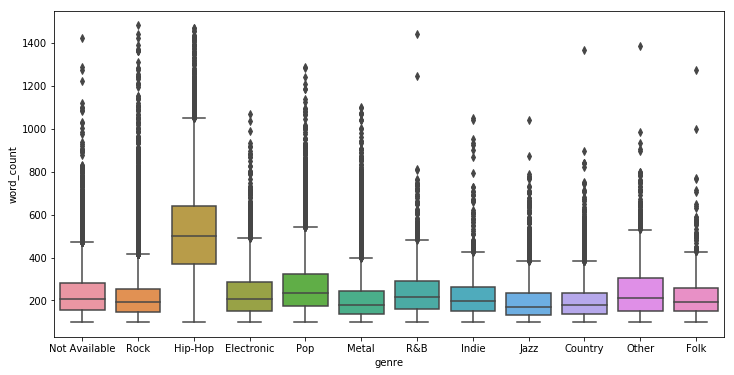

In [45]:
import matplotlib as mpl
mpl.rc("figure", figsize=(12, 6))
sns.boxplot(x="genre", y="word_count", data=songDF)

In [47]:
genre = songDF.groupby(['genre'],as_index=False).count()
genre2 = genre[['genre','song']]
genre2

genre   song
0         Country  12426
1      Electronic   4408
2            Folk   1494
3         Hip-Hop  21977
4           Indie   2137
5            Jazz   5863
6           Metal  16185
7   Not Available  14772
8           Other   1579
9             Pop  33738
10            R&B   2746
11           Rock  86927

In [30]:
songNewDF = ss.createDataFrame(songDF)

In [37]:
songNewDF.show(2)

+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+
| index|                song|year|artist|genre|              lyrics|word_count|number_of_songs|      lyrics_cleaned|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+
|238147|            24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142|Here on the stree...|
|238097|action-man-in-a-m...|2006| 10-cc| Rock|Let's stay a whil...|     261.0|            142|Let s stay a whil...|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+
only showing top 2 rows



In [31]:
#Tokenized_df2.select('lyrics_tokenized_by_backslash').rdd.flatMap(list).take(12)

from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler
from pyspark import SparkContext

Tokenizer = RegexTokenizer(inputCol="lyrics_cleaned", outputCol="all_lyrics_tokenized_", pattern= " ")
Tokenized_df = Tokenizer.transform(songNewDF)
Tokenized_df.show(2)

+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+
| index|                song|year|artist|genre|              lyrics|word_count|number_of_songs|      lyrics_cleaned|all_lyrics_tokenized_|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+
|238147|            24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142|Here on the stree...| [here, on, the, s...|
|238097|action-man-in-a-m...|2006| 10-cc| Rock|Let's stay a whil...|     261.0|            142|Let s stay a whil...| [let, s, stay, a,...|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+
only showing top 2 rows



In [28]:
#Tokenizer = RegexTokenizer(inputCol="lyrics", outputCol="all_lyrics_tokenized_", pattern= " ")
#hashtf = HashingTF(numFeatures=2**16, inputCol="lyrics", outputCol='tf')
#Tokenized_df = Tokenizer.transform(song_df)
#Tokenized_df.show(2)

In [29]:
#Tokenizer = RegexTokenizer(inputCol="lyrics_cleaned", outputCol="all_lyrics_tokenized_", pattern= " ")
#Tokenized_df = Tokenizer.transform(songNewDF)
#Tokenized_df.show(2)

+------+-------------+----+-------------+-------------+--------------------+----------+---------------+---------------------+
| index|         song|year|       artist|        genre|              lyrics|word_count|number_of_songs|all_lyrics_tokenized_|
+------+-------------+----+-------------+-------------+--------------------+----------+---------------+---------------------+
|198081|1-girl-nation|2014|1-girl-nation|Not Available|Hey, there's a gi...|     312.0|             10| [hey,, there's, a...|
|198073|       cinema|2016|1-girl-nation|Not Available|Girls night out a...|     441.0|             10| [girls, night, ou...|
+------+-------------+----+-------------+-------------+--------------------+----------+---------------+---------------------+
only showing top 2 rows



In [54]:
Tokenized_df.select('lyrics_cleaned').show(10)

+--------------------+
|      lyrics_cleaned|
+--------------------+
|Hey there s a gir...|
|Girls night out a...|
|Go crazy Crazy Cr...|
|In the middle of ...|
|It s been three h...|
|I guess I ve alwa...|
|This this is me t...|
|Panic Panic Panic...|
|Put your make up ...|
|We ve all heard p...|
+--------------------+
only showing top 10 rows



In [32]:
from pyspark.sql.functions import regexp_replace

Tokenized_df = Tokenized_df.withColumn('song_name', regexp_replace('song', '-', ' '))
#Tokenized_df = Tokenized_df.withColumn('song_name', regexp_replace('lyrics', '', ' '))
Tokenized_df.show(2)

+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--------------------+
| index|                song|year|artist|genre|              lyrics|word_count|number_of_songs|      lyrics_cleaned|all_lyrics_tokenized_|           song_name|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--------------------+
|238147|            24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142|Here on the stree...| [here, on, the, s...|            24 hours|
|238097|action-man-in-a-m...|2006| 10-cc| Rock|Let's stay a whil...|     261.0|            142|Let s stay a whil...| [let, s, stay, a,...|action man in a m...|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--------------------+
only showing top 2 rows



In [33]:
from pyspark.sql.functions import regexp_replace

Tokenized_df = Tokenized_df.withColumn('artist_name', regexp_replace('artist', '-', ' '))
#Tokenized_df = Tokenized_df.withColumn('song_name', regexp_replace('lyrics', '', ' '))
Tokenized_df.show(2)

+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--------------------+-----------+
| index|                song|year|artist|genre|              lyrics|word_count|number_of_songs|      lyrics_cleaned|all_lyrics_tokenized_|           song_name|artist_name|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--------------------+-----------+
|238147|            24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142|Here on the stree...| [here, on, the, s...|            24 hours|      10 cc|
|238097|action-man-in-a-m...|2006| 10-cc| Rock|Let's stay a whil...|     261.0|            142|Let s stay a whil...| [let, s, stay, a,...|action man in a m...|      10 cc|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--

In [26]:
#from pyspark.sql.functions import concat_ws
#Tokenized_df = Tokenized_df.withColumn("song_name_",concat_ws(",","song_name"))  #converts array(string) --> list
#Tokenized_df.show(2)

In [27]:
#from pyspark.sql.functions import regexp_replace

#tdf = Tokenized_df.withColumn('name', regexp_replace('song_name_', ',', ' '))
#tdf.show(2)

In [29]:
Tokenized_df.select('song_name').rdd.flatMap(list).take(10)

[u'1 girl nation',
 u'cinema',
 u'get hype',
 u'guard your heart',
 u'haters',
 u'impossible',
 u'nofilter',
 u'panic',
 u'try cover',
 u'while we re young']

In [ ]:
#mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=3)
#model = mh.fit(dfassembler1)
#model.transform(dfassembler1).show(3, False)

In [52]:
Tokenized_df.select('all_lyrics_tokenized_').rdd.flatMap(list).take(1)

[[u'hey',
  u'there',
  u's',
  u'a',
  u'girl',
  u'sittin',
  u'all',
  u'alone',
  u'heartbroke',
  u'and',
  u'i',
  u'bet',
  u'you',
  u'didn',
  u't',
  u'even',
  u'know',
  u'you',
  u're',
  u'there',
  u'messin',
  u'with',
  u'your',
  u'hair',
  u'you',
  u'ain',
  u't',
  u'got',
  u'time',
  u'and',
  u'you',
  u'just',
  u'don',
  u't',
  u'care',
  u'what',
  u's',
  u'up',
  u'with',
  u'the',
  u'he',
  u'said',
  u'she',
  u'said',
  u'drama',
  u'drama',
  u'talkin',
  u'smack',
  u'on',
  u'the',
  u'internet',
  u'sister',
  u'she',
  u's',
  u'just',
  u'like',
  u'you',
  u'so',
  u'don',
  u't',
  u'talk',
  u'trash',
  u'cause',
  u'i',
  u've',
  u'been',
  u'there',
  u'too',
  u'it',
  u's',
  u'time',
  u'for',
  u'a',
  u'little',
  u'less',
  u'talk',
  u'a',
  u'little',
  u'less',
  u'talk',
  u'cause',
  u'we',
  u'all',
  u'got',
  u'faults',
  u'it',
  u's',
  u'time',
  u'for',
  u'a',
  u'little',
  u'less',
  u'talk',
  u'a',
  u'little',
  u'le

In [27]:
print((Tokenized_df.count(), len(Tokenized_df.columns)))

(204316, 12)


In [ ]:
#from pyspark.sql.functions import udf, col, lower, regexp_replace
#from pyspark.ml.feature import Tokenizer, StopWordsRemover
#from nltk.stem.snowball import SnowballStemmer

# Clean text
#df_clean = Tokenized_df.select('tokeniz', (lower(regexp_replace('text', "[^a-zA-Z\\s]", "")).alias('text')))

# Tokenize text
#tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
#df_words_token = tokenizer.transform(df_clean).select('id', 'words_token')

# Remove stop words
#remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
#df_words_no_stopw = remover.transform(df_words_token).select('id', 'words_clean')

# Stem text
#stemmer = SnowballStemmer(language='english')
#stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
#df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('id', 'words_stemmed')

# Filter length word > 3
#filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
#df_final_words = df_stemmed.withColumn('words', filter_length_udf(col('words_stemmed')))

In [24]:
#from pyspark.ml.feature import HashingTF, IDF, Tokenizer
#from pyspark.ml.feature import StringIndexer
#from pyspark.ml import Pipeline

#tokenizer = Tokenizer(inputCol="lyrics", outputCol="lyrics_tokenized")
#hashtf = HashingTF(numFeatures=2**16, inputCol="lyrics", outputCol='tf')
#idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
##label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
#pipeline = Pipeline(stages=[tokenizer, hashtf, idf])

#pipelineFit = pipeline.fit(train_set)
#_df = pipeline.fit(song_df)
#val_df = pipelineFit.transform(val_set)
#_df.show(5)

### data cleaning and tokenizing is now done... stop words should be next
### Tokenized_df --> spark dataframe, tokenized_panda --> pandas dataframe

### Required operations:

### 1. Clearing text from punctuation (regexp_replace)
### 2. Tokenization (Tokenizer)
### 3. Delete stop words (StopWordsRemover)
### 4. Stematization (SnowballStemmer)
### 5.Filtering short words (udf)
### 6. countVectorizer
### 7. hashinTF
### 8. dealing with (), [] in lyrics

In [ ]:
#Tasks:

#Number of artists
#Which artist has highest and lowest number of songs
#Distribution of songs of all artists in the dataset
#Distribution of lyrics length
#Which song lyrics has maximum number of words
#Which song lyrics has minimum number of words
#Distribution of words count in title
#Which songs title has maximum number of words
#Which songs title has minimum number of words
#WordClouds of titles with minimum and maximum lengths
#Is there a relation between title length and song length?
#Sentiments of the songs (NRC, Bing)
#Which words are most occuring in the lyrics of the songs
#Wordcloud of most popular words in the songs
#Top words used by an artist in his/her songs
#Are there some common Rythmic words that repeats again and again?

In [23]:
#import nltk
#not used

def clean_text(text):
    text = text.replace('--', ' ')
    text = text.replace('\t', ' ')
    tokens = text.split()
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens if word not in nltk.corpus.stopwords.words('english')]
    return tokens

In [24]:
#not used
def gen_data(rows):
    lyrics_data = pd.read_csv('/scratch/ISE495/2019_project_data/group-7/lyrics.csv')
    print("No of rows in data are %s",lyrics_data.__len__())
    lyrics_data = lyrics_data[pd.notnull(lyrics_data['lyrics'])]
    if rows<lyrics_data.__len__(): 
        lyrics_data_sample = lyrics_data[0:rows]
        lyrics_data_sample['lyrics'] = lyrics_data_sample['lyrics'].apply(lambda x: clean_text(x))
    else:
        print("Rows exceeded")
    return lyrics_data_sample

In [44]:
songDF['lyrics'].iloc[149799]

u'[Eazy-E] Yo Dre where\'s the goddamn drum machine? [Dre] Aw shit I left the muthafucka with Poog [Eazy-E] You dumb muthafucka what the fuck we gonna do now? [Yella] Hey, man I got some drums in the back [Dre] Man what the fuck is he talkin\' bout [M.C. Ren] Yo does it look like we can play some fuckin\' drums? [Yella] Man I can play the drums [Everyone except Yella] Bullshit! [Yella] Man I used to fuck it up at Compton [*Arguin\'*] [M.C. Ren] Give this nigga some sticks.... Yo Fuck it up Yella [M.C. Ren] Yo were two hard muthafuckaz takin\' out any punk ass suckaz can you believe this or so be frightened were strong as fuck, with the power of a titan settin\' a mark of destruction get it so don\'t front, and say you ain\'t with it you wanna rumble with us you can\'t hang cause were something like a two man gang start some shit is what we do best scared by the suckaz say fuck the rest so yo Eazy bust it and shoot to kill and tell these stupid muthafuckaz the deal [Eazy-E] I look you d

In [43]:
songDF['lyrics_cleaned'].iloc[149799]

u' Eazy E Yo Dre where s the goddamn drum machine Dre Aw shit I left the muthafucka with Poog Eazy E You dumb muthafucka what the fuck we gonna do now Yella Hey man I got some drums in the back Dre Man what the fuck is he talkin bout M C Ren Yo does it look like we can play some fuckin drums Yella Man I can play the drums Everyone except Yella Bullshit Yella Man I used to fuck it up at Compton Arguin M C Ren Give this nigga some sticks Yo Fuck it up Yella M C Ren Yo were two hard muthafuckaz takin out any punk ass suckaz can you believe this or so be frightened were strong as fuck with the power of a titan settin a mark of destruction get it so don t front and say you ain t with it you wanna rumble with us you can t hang cause were something like a two man gang start some shit is what we do best scared by the suckaz say fuck the rest so yo Eazy bust it and shoot to kill and tell these stupid muthafuckaz the deal Eazy E I look you dead in the eye and I spit tell you to your face punk yo

In [49]:
Tokenized_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- song: string (nullable = true)
 |-- year: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- word_count: double (nullable = true)
 |-- number_of_songs: long (nullable = true)
 |-- lyrics_cleaned: string (nullable = true)
 |-- all_lyrics_tokenized_: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- song_name: string (nullable = true)



In [34]:
songDF1 = Tokenized_df.toPandas()
songDF1.head()

index                         song  year artist genre  \
0  238147                     24-hours  2006  10-cc  Rock   
1  238097  action-man-in-a-motown-suit  2006  10-cc  Rock   
2  238176               age-of-consent  1995  10-cc  Rock   
3  238127            american-panorama  2006  10-cc  Rock   
4  238132           americana-panorama  2006  10-cc  Rock   

                                              lyrics  word_count  \
0  Here on the street Feeling the cool of the daw...       356.0   
1  Let's stay a while and watch him He's moving i...       261.0   
2  I want to meet you at that restaurant The one ...       263.0   
3  Martin Luther B.B. King You had a dream and yo...       210.0   
4  Martin Luther B.B. King You had a dream and yo...       210.0   

   number_of_songs                                     lyrics_cleaned  \
0              142  Here on the street Feeling the cool of the daw...   
1              142  Let s stay a while and watch him He s moving i...   
2              142  I want to meet you at that restaurant The one ...   
3              142  Martin Luther B B King You had a dream and you...   
4              142  Martin Luther B B King You had a dream and you...   

                               all_lyrics_tokenized_  \
0  [here, on, the, street, feeling, the, cool, of...   
1  [let, s, stay, a, while, and, watch, him, he, ...   
2  [i, want, to, meet, you, at, that, restaurant,...   
3  [martin, luther, b, b, king, you, had, a, drea...   
4  [martin, luther, b, b, king, you, had, a, drea...   

                     song_name artist_name  
0                     24 hours       10 cc  
1  action man in a motown suit       10 cc  
2               age of consent       10 cc  
3            american panorama       10 cc  
4           americana panorama       10 cc

In [ ]:
#### selecting rows based on column values in python

#df.loc[df['column_name'].isin(some_values)]
#Combine multiple conditions with &:

#df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]
#Note the parentheses. Due to Python's operator precedence rules, & binds more tightly than <= and >=. Thus, the parentheses in the last example are necessary. Without the parentheses

#df['column_name'] >= A & df['column_name'] <= B
#is parsed as

#df['column_name'] >= (A & df['column_name']) <= B
#which results in a Truth value of a Series is ambiguous error.

#To select rows whose column value does not equal some_value, use !=:

#df.loc[df['column_name'] != some_value]
#isin returns a boolean Series, so to select rows whose value is not in some_values, negate the boolean Series using ~:

#df.loc[~df['column_name'].isin(some_values)]

#selecting rows based on column values in pyspark

#result = users_df.where(users_df._id == chosen_user).select("gender")
#or with col

#from pyspark.sql.functions import col

#result = users_df.where(col("_id") == chosen_user).select(col("gender"))
#Finally PySpark Row is just a tuple with some extensions so you can for example flatMap:

#result.rdd.flatMap(list).first()
#or map with something like this:

#result.rdd.map(lambda x: x.gender).first()

In [41]:
print(songDF.loc[songDF['artist'] == 'eazy-e'])#.iloc[301]

        index                                 song  year  artist    genre  \
149799    315                       2-hard-mutha-s  2002  eazy-e  Hip-Hop   
149800    299                     24-hours-to-live  2006  eazy-e  Hip-Hop   
149801    285                               8-ball  2006  eazy-e  Hip-Hop   
149802    250                         8-ball-remix  2007  eazy-e  Hip-Hop   
149803    269                       any-last-werdz  1998  eazy-e  Hip-Hop   
149804    296                       any-last-wordz  2006  eazy-e  Hip-Hop   
149805    330                           automobile  1995  eazy-e  Hip-Hop   
149806    253                           automoblie  2007  eazy-e  Hip-Hop   
149807    284                    black-nigga-killa  2006  eazy-e  Hip-Hop   
149808    252                      boyz-in-da-hood  2007  eazy-e  Hip-Hop   
149809    255               boyz-in-the-hood-remix  2007  eazy-e  Hip-Hop   
149810    291                boyz-n-tha-hood-g-mix  2006  eazy-e  Hip-Hop   

In [48]:
print(songDF.loc[songDF['genre'] == 'Hip-Hop'])#.iloc[301]

         index                                            song  year  \
330     361181                                       112-intro  2006   
331     361144                                   all-cried-out  2006   
332     361126                               all-i-want-is-you  2006   
333     361168                                     all-my-love  2006   
334     361130                                        anything  2006   
335     361155                                        anywhere  2006   
336     361154                                  anywhere-remix  2006   
337     361127                                     be-with-you  2006   
338     361165                                    call-my-name  2006   
339     361140                                 can-i-touch-you  2006   
340     361179                                       caught-up  2006   
341     361106                                closing-the-club  2005   
342     361182                                     come-see-me  

In [55]:
result = Tokenized_df.where(Tokenized_df.artist == "eazy-e").select("lyrics")
result.rdd.flatMap(list).take(1)

[u'Yo Dre where\'s the goddamn drum machine? Aw shit I left the muthafucka with Poog You dumb muthafucka what the fuck we gonna do now? Hey, man I got some drums in the back Man what the fuck is he talkin\' bout Yo does it look like we can play some fuckin\' drums? Man I can play the drums Bullshit! Man I used to fuck it up at Compton Give this nigga some sticks.... Yo Fuck it up Yella Yo were two hard muthafuckaz takin\' out any punk ass suckaz can you believe this or so be frightened were strong as fuck, with the power of a titan settin\' a mark of destruction get it so don\'t front, and say you ain\'t with it you wanna rumble with us you can\'t hang cause were something like a two man gang start some shit is what we do best scared by the suckaz say fuck the rest so yo Eazy bust it and shoot to kill and tell these stupid muthafuckaz the deal I look you dead in the eye and I spit tell you to your face punk you ain\'t shit I don\'t give a goddamn about feelin\'s I\'m just as a happy as

### dealing with stopwords

In [58]:
#import nltk
#from nltk.corpus import stopwords
#from nltk.probability import FreqDist
#import seaborn as sns
#nltk.download('stopwords')


#customStopWords = ["'s", "n't", "'m", "'re", "'ll","'ve","...", "ä±", "''", '``',\
                  #'--', "'d", 'el', 'la']
#stopWords = stopwords.words('english') + customStopWords

#words = ""
#for song in songDF.iterrows():
#    words += " " + song[1]['lyrics']

#words = nltk.word_tokenize( words.lower() )
#words = [ word for word in words if len(word) > 1\
                             #and not word.isnumeric()\
                             #and word not in stopWords ]
    
#word_dist = FreqDist( words  )
#print("The 10 most common words in the dataset are :")
#for word, frequency in word_dist.most_common(10):
#    print( u'{} : {}'.format( word, frequency ) )

#plt.figure(figsize=(15, 10))
#nlp_words = word_dist.plot( 20 )

In [36]:
songs_rdd = Tokenized_df.select("lyrics_cleaned").rdd.flatMap(lambda x: x)
songs_rdd = songs_rdd.map(lambda x : x.lower())
songs_rdd.take(2)

[u'here on the street feeling the cool of the dawn shuffling feet faces are ragged and worn they ve been working all night waiting for the curtain to rise while you re under the sheets you with the stars in your eyes letter box noise snapping the day into life newspaper boys cutting the mist like a knife we re beginning to rise curtain up the drama begins it s the start of the race all of us wanting to win people rushing shouting pushing got no time for conversation inner city population the struggle for communication people trying pressure rising hook and hustle flex your muscle it s all part of living do you want to get away restaurant smells mix in the heat of the day telephone bells kissogram girls on her way someone s thinking of you birthday boy is in for a treat and the message is clear once a year life can be sweet caught in a flash cover girl freezes her smile media trash blinding the crowd with such style it s a dazzling affair a fantasy to star in your dreams do you want to 

### all punctutations are removed

In [40]:
words = Tokenized_df.select('all_lyrics_tokenized_').rdd
words.take(1)

[Row(all_lyrics_tokenized_=[u'here', u'on', u'the', u'street', u'feeling', u'the', u'cool', u'of', u'the', u'dawn', u'shuffling', u'feet', u'faces', u'are', u'ragged', u'and', u'worn', u'they', u've', u'been', u'working', u'all', u'night', u'waiting', u'for', u'the', u'curtain', u'to', u'rise', u'while', u'you', u're', u'under', u'the', u'sheets', u'you', u'with', u'the', u'stars', u'in', u'your', u'eyes', u'letter', u'box', u'noise', u'snapping', u'the', u'day', u'into', u'life', u'newspaper', u'boys', u'cutting', u'the', u'mist', u'like', u'a', u'knife', u'we', u're', u'beginning', u'to', u'rise', u'curtain', u'up', u'the', u'drama', u'begins', u'it', u's', u'the', u'start', u'of', u'the', u'race', u'all', u'of', u'us', u'wanting', u'to', u'win', u'people', u'rushing', u'shouting', u'pushing', u'got', u'no', u'time', u'for', u'conversation', u'inner', u'city', u'population', u'the', u'struggle', u'for', u'communication', u'people', u'trying', u'pressure', u'rising', u'hook', u'and', 

In [27]:
Tokenized_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- song: string (nullable = true)
 |-- year: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- word_count: double (nullable = true)
 |-- number_of_songs: long (nullable = false)
 |-- all_lyrics_tokenized_: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- song_name: string (nullable = true)



In [59]:
#from pyspark.ml.feature import HashingTF, IDF, Tokenizer
#from pyspark.ml.feature import StringIndexer
#from pyspark.ml import Pipeline

#tokenizer = Tokenizer(inputCol="lyrics", outputCol="lyrics_tokenized")
#hashtf = HashingTF(numFeatures=2**16, inputCol="lyrics", outputCol='tf')
#idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
#label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
#pipeline = Pipeline(stages=[tokenizer, hashtf, idf])

#pipelineFit = pipeline.fit(train_set)
#train_df = pipelineFit.transform(train_set)
#val_df = pipelineFit.transform(val_set)


In [43]:
Tokenized_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- song: string (nullable = true)
 |-- year: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- word_count: double (nullable = true)
 |-- number_of_songs: long (nullable = true)
 |-- lyrics_cleaned: string (nullable = true)
 |-- all_lyrics_tokenized_: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- song_name: string (nullable = true)



In [33]:
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import udf, col, lower, regexp_replace
#from pyspark.ml.feature import Tokenizer, StopWordsRemover
#from nltk.stem.snowball import SnowballStemmer

# Tokenize text
#tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
#df_words_token = tokenizer.transform(df_clean).select('id', 'words_token')

# Remove stop words
#remover = StopWordsRemover(inputCol='all_lyrics_tokenized_', outputCol='words_clean')
#df_words_no_stopw = remover.transform(Tokenized_df).select('index''artist', 'words_clean')

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer

# Tokenize text
#tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
#df_words_token = tokenizer.transform(df_clean).select('id', 'words_token')

# Remove stop words
remover = StopWordsRemover(inputCol='all_lyrics_tokenized_', outputCol='words_clean')
df_words_no_stopw = remover.transform(Tokenized_df).select('index','song','year','artist','genre','lyrics','word_count','number_of_songs','song_name','all_lyrics_tokenized_','words_clean')

In [36]:
# Stem text
from pyspark.sql.types import ArrayType, StringType

stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('index','song','year','artist','genre','lyrics','word_count','number_of_songs','song_name','all_lyrics_tokenized_', 'words_stemmed')

In [37]:
#Filter length word > 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
songCleanDF = df_stemmed.withColumn('words_in_song', filter_length_udf(col('words_stemmed')))

In [38]:
#Filter length word > 3
#filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
#songCleanDF = df_stemmed.withColumn('words_in_song', filter_length_udf(col('words_clean')))

In [53]:
from pyspark.ml.feature import NGram

ngram = NGram(n=2, inputCol="words_in_song", outputCol="ngrams")

songCleanDF1 = ngram.transform(songCleanDF)
songCleanDF1.select("ngrams").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [48]:
df_words_no_stopw.show(1)

+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+
| index|    song|year|artist|genre|              lyrics|word_count|number_of_songs|song_name|all_lyrics_tokenized_|         words_clean|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+
|238147|24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142| 24 hours| [here, on, the, s...|[street, feeling,...|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+
only showing top 1 row



In [49]:
songCleanDF.show(1)

+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+
| index|    song|year|artist|genre|              lyrics|word_count|number_of_songs|song_name|all_lyrics_tokenized_|       words_stemmed|       words_in_song|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+
|238147|24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142| 24 hours| [here, on, the, s...|[street, feel, co...|[street, feel, co...|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+
only showing top 1 row



In [46]:
songCleanDF1.show(1)

+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+--------------------+
| index|    song|year|artist|genre|              lyrics|word_count|number_of_songs|song_name|all_lyrics_tokenized_|       words_stemmed|       words_in_song|              ngrams|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+--------------------+
|238147|24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142| 24 hours| [here, on, the, s...|[street, feel, co...|[street, feel, co...|[street feel, fee...|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [55]:
songCleanDF1 = songCleanDF1.dropna()

In [38]:
type(songDF1)

pandas.core.frame.DataFrame

In [39]:
songDF1.dtypes

index                      int64
song                      object
year                       int64
artist                    object
genre                     object
lyrics                    object
word_count               float64
number_of_songs            int64
lyrics_cleaned            object
all_lyrics_tokenized_     object
song_name                 object
artist_name               object
dtype: object

In [40]:
import random
#import helpers
#import cv2
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing,CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from scipy.misc import imread
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
#from wordcloud import WordCloud, STOPWORDS

In [44]:
import sys
print(sys.executable)

/usr/bin/python
/bin/sh: 1: conda: not found


In [45]:
!conda install -c https://conda.anaconda.org/conda-forge wordcloud

/bin/sh: 1: conda: not found


In [41]:
#pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

ImportError: No module named wordcloud

In [40]:
songClean = songCleanDF.toPandas()

Traceback (most recent call last):
  File "/usr/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/opt/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 57618)
----------------------------------------


    self.process_request(request, client_address)
  File "/usr/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python2.7/SocketServer.py", line 655, in __init__
    self.handle()
  File "/opt/spark-2.2.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/opt/spark-2.2.0-bin-hadoop2.7/python/pyspark/serializers.py", line 577, in read_int
    raise EOFError
EOFError
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:53917)
Traceback (most recent call last):
  File "/opt/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 963, in start
    self.socket.connect((self.address, self.port))
  File "/usr/lib/python2.7/socket.py", line 224, in meth

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:53917)

In [64]:
songClean.head()

index                         song  year artist genre  \
0  238147                     24-hours  2006  10-cc  Rock   
1  238097  action-man-in-a-motown-suit  2006  10-cc  Rock   
2  238176               age-of-consent  1995  10-cc  Rock   
3  238127            american-panorama  2006  10-cc  Rock   
4  238132           americana-panorama  2006  10-cc  Rock   

                                              lyrics  word_count  \
0  Here on the street Feeling the cool of the daw...       356.0   
1  Let's stay a while and watch him He's moving i...       261.0   
2  I want to meet you at that restaurant The one ...       263.0   
3  Martin Luther B.B. King You had a dream and yo...       210.0   
4  Martin Luther B.B. King You had a dream and yo...       210.0   

   number_of_songs                    song_name  \
0              142                     24 hours   
1              142  action man in a motown suit   
2              142               age of consent   
3              142            american panorama   
4              142           americana panorama   

                               all_lyrics_tokenized_  \
0  [here, on, the, street, feeling, the, cool, of...   
1  [let, s, stay, a, while, and, watch, him, he, ...   
2  [i, want, to, meet, you, at, that, restaurant,...   
3  [martin, luther, b, b, king, you, had, a, drea...   
4  [martin, luther, b, b, king, you, had, a, drea...   

                                       words_stemmed  \
0  [street, feel, cool, dawn, shuffl, feet, face,...   
1  [let, stay, watch, move, action, man, look, go...   
2  [want, meet, restaur, one, love, got, pretti, ...   
3  [martin, luther, b, b, king, dream, make, us, ...   
4  [martin, luther, b, b, king, dream, make, us, ...   

                                       words_in_song  
0  [street, feel, cool, dawn, shuffl, feet, face,...  
1  [let, stay, watch, move, action, man, look, go...  
2  [want, meet, restaur, one, love, got, pretti, ...  
3  [martin, luther, king, dream, make, swing, doc...  
4  [martin, luther, king, dream, make, swing, doc...

In [ ]:
#def pos_tag(x):
#    import nltk
#    return nltk.pos_tag([x])
#pos_word = filtered_data.map(pos_tag)
#print pos_word.collect(

In [68]:
songRDD = songCleanDF.rdd

In [69]:
songRDD.take(2)

[Row(index=198081, song=u'1-girl-nation', year=2014, artist=u'1-girl-nation', genre=u'Not Available', lyrics=u"Hey, there's a girl sittin' all alone Heartbroke, and I bet you didn't even know You're there, messin' with your hair You ain't got time, and you just don't care What's up, with the he said, she said? Drama, drama, talkin' smack on the internet Sister, she's just like you So, don't talk trash, 'cause I've been there too It's time for a little less talk A little less talk 'cause we all got faults It's time for a little less talk A little less and a lot more walk Come Together As A 1 Girl Nation! Shout it to all creation Jesus is all foundation We stand strong, it's a revolution Let me break it down Here's the situation It's time for a 1 Girl Nation 1 2 3 4 Don't mean to be all in your face It's in love so hear what I got to say Take five if you can't say something nice We're girl strong when we all stand unified It's time for a little less talk A little less talk 'cause we all 

In [65]:
def lemmatizationFunct(x):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem
lem_wordsRDD = songCleanDF.select('all_lyrics_tokenized_').rdd.map(lemmatizationFunct)

In [87]:
wordsRDD = songCleanDF.select('words_in_song').rdd.map(lambda x: x)
wordsRDD.take(1)

[Row(words_in_song=[u'street', u'feel', u'cool', u'dawn', u'shuffl', u'feet', u'face', u'rag', u'worn', u'work', u'night', u'wait', u'curtain', u'rise', u'sheet', u'star', u'eye', u'letter', u'box', u'nois', u'snap', u'day', u'life', u'newspap', u'boy', u'cut', u'mist', u'like', u'knife', u'begin', u'rise', u'curtain', u'drama', u'begin', u'start', u'race', u'want', u'win', u'peopl', u'rush', u'shout', u'push', u'got', u'time', u'convers', u'inner', u'citi', u'popul', u'struggl', u'communic', u'peopl', u'tri', u'pressur', u'rise', u'hook', u'hustl', u'flex', u'muscl', u'part', u'live', u'want', u'get', u'away', u'restaur', u'smell', u'mix', u'heat', u'day', u'telephon', u'bell', u'kissogram', u'girl', u'way', u'someon', u'think', u'birthday', u'boy', u'treat', u'messag', u'clear', u'year', u'life', u'sweet', u'caught', u'flash', u'cover', u'girl', u'freez', u'smile', u'media', u'trash', u'blind', u'crowd', u'style', u'dazzl', u'affair', u'fantasi', u'star', u'dream', u'want', u'believ'

In [98]:
textRDD = songCleanDF.select('lyrics').rdd.map(lambda x: x)
textRDD.take(1)

[Row(lyrics=u"Here on the street Feeling the cool of the dawn Shuffling feet Faces are ragged and worn They've been working all night Waiting for the curtain to rise While you're under the sheets You with the stars in your eyes Letter box noise Snapping the day into life Newspaper boys Cutting the mist like a knife We're beginning to rise Curtain up the drama begins It's the start of the race All of us wanting to win People rushing shouting pushing Got no time for conversation Inner city population The struggle for communication People trying pressure rising Hook and hustle flex your muscle It's all part of living Do you want to get away Restaurant smells Mix in the heat of the day Telephone bells Kissogram girls on her way Someone's thinking of you Birthday boy is in for a treat And the message is clear Once a year life can be sweet Caught in a flash Cover girl freezes her smile Media trash Blinding the crowd with such style It's a dazzling affair A fantasy to star in your dreams Do y

In [72]:
import nltk
import pandas as pd

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(lyrics):
    return [lemmatizer.lemmatize(w, 'v') for w in w_tokenizer.tokenize(lyrics)]

song_df_rdd = lyricsRDD.map(lemmatize_text)
song_df_rdd

PythonRDD[168] at RDD at PythonRDD.scala:48

In [77]:
def pos_tag(x):
    import nltk
    nltk.download('wordnet')
    return nltk.pos_tag([x])
#pos_word = song_df_rdd.map(pos_tag)
#print pos_word.collect()

### identify lemmatization, english songs.. n-grams, and bag of words in CV

In [35]:
songCleanDF.count()

204316

In [ ]:
#count vectorizer
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="words_in_song", outputCol="features_from_countVectorizer")
model = cv.fit(songCleanDF)
result = model.transform(songCleanDF)
result.show(truncate=False)

In [ ]:
#tf - idf

# Get term frequency vector through HashingTF
from pyspark.ml.feature import HashingTF
ht = HashingTF(inputCol="words_in_song", outputCol="hashingTF")
songClean_df = ht.transform(result)
songClean_df.show(truncate=False)

In [33]:
songClean_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- song: string (nullable = true)
 |-- year: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- word_count: double (nullable = true)
 |-- number_of_songs: long (nullable = false)
 |-- song_name: string (nullable = true)
 |-- all_lyrics_tokenized_: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_in_song: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features_from_countVectorizer: vector (nullable = true)
 |-- hashingTF: vector (nullable = true)



In [38]:
songRDD = songClean_df.rdd

In [39]:
songRDD.take(1)

[Row(index=198081, song=u'1-girl-nation', year=2014, artist=u'1-girl-nation', genre=u'Not Available', lyrics=u"Hey, there's a girl sittin' all alone Heartbroke, and I bet you didn't even know You're there, messin' with your hair You ain't got time, and you just don't care What's up, with the he said, she said? Drama, drama, talkin' smack on the internet Sister, she's just like you So, don't talk trash, 'cause I've been there too It's time for a little less talk A little less talk 'cause we all got faults It's time for a little less talk A little less and a lot more walk Come Together As A 1 Girl Nation! Shout it to all creation Jesus is all foundation We stand strong, it's a revolution Let me break it down Here's the situation It's time for a 1 Girl Nation 1 2 3 4 Don't mean to be all in your face It's in love so hear what I got to say Take five if you can't say something nice We're girl strong when we all stand unified It's time for a little less talk A little less talk 'cause we all 

### more : remove punctuations, lemmatization, dealing with brackets, one hot encoding

In [44]:
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered
rmvPunctRDD = songRDD.map(removePunctuationsFunct)

In [ ]:
#def lemmatizationFunct(x):
#    nltk.download('wordnet')
#    lemmatizer = WordNetLemmatizer()
#    finalLem = [lemmatizer.lemmatize(s) for s in x]
#    return finalLem
#lem_wordsRDD = songRDD.map(lemmatizationFunct)

In [29]:
# removing brackets
import re
text_in_round_brackets = sum(list(songDF['lyrics'].map(lambda s: re.findall(r'\((.*?)\)',s))), [])
print('Number of round brackets: {}'.format(len(text_in_round_brackets)))

Number of round brackets: 301726


In [35]:
import random

print random.__file__

/usr/lib/python2.7/random.pyc


In [33]:
text_in_round_brackets[:10]

[u'We are!',
 u"What's your sign",
 u'mother, mother',
 u'Yeh',
 u'repeat 5x',
 u"what's that you say",
 u'speak to me now',
 u'deadly game',
 u"what's that you say",
 u'speak to me now']

In [36]:
# remove round brackets but not text within
songDF1['lyrics'] = songDF1['lyrics'].map(lambda s: re.sub(r'\(|\)', '', s))

In [35]:
# remove square brackets and not text within
songDF['lyrics'] = songDF['lyrics'].map(lambda s: re.sub(r'\[(.*?)\] ', '', s))

In [ ]:
# remove square brackets and not text within
songDF['text'] = songDF['lyrics'].map(lambda s: re.sub(r'\[(.*?)\] ', '', s))

### count vectorizer

In [ ]:
#count vectorizer
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="words_in_song", outputCol="features_from_countVectorizer")
model = cv.fit(songCleanDF)
result = model.transform(songCleanDF)
result.show(truncate=False)

### hashing tf

In [ ]:
#tf - idf

# Get term frequency vector through HashingTF
from pyspark.ml.feature import HashingTF
ht = HashingTF(inputCol="words_in_song", outputCol="hashingTF")
songClean_df = ht.transform(result)
songClean_df.show(truncate=False)

In [6]:
### python analysis

In [6]:
# remove round brackets but not text within
import re
df['lyrics'] = df['lyrics'].map(lambda s: re.sub(r'\(|\)', '', s))

# remove square brackets and not text within
df['lyrics'] = df['lyrics'].map(lambda s: re.sub(r'\[(.*?)\] ', '', s))

# remove square brackets and not text within
df['lyrics'] = df['lyrics'].map(lambda s: re.sub(r'\[(.*?)\] ', '', s))

In [7]:
df

index                                               song  year  \
0            0                                          ego-remix  2009   
1            1                                       then-tell-me  2009   
2            2                                            honesty  2009   
3            3                                    you-are-my-rock  2009   
4            4                                      black-culture  2009   
5            5                             all-i-could-do-was-cry  2009   
6            6                                 once-in-a-lifetime  2009   
7            7                                            waiting  2009   
8            8                                          slow-love  2009   
9            9                              why-don-t-you-love-me  2009   
10          10                                      save-the-hero  2009   
11          11                                          telephone  2009   
12          12                                    ice-cream-truck  2009   
13          13                             no-broken-hearted-girl  2009   
14          14                                            control  2009   
15          15                                      i-m-alone-now  2009   
16          16                                             poison  2009   
17          17                                   world-wide-women  2007   
18          18                                     beautiful-liar  2007   
19          19                             beautiful-liar-spanish  2007   
20          20                   beautiful-liar-spanglish-version  2007   
21          21                                          bienvenue  2007   
22          22                                beutiful-liar-remix  2007   
23          23  he-still-loves-me-f-choir-from-fighting-tempta...  2007   
24          24                                    bello-embustero  2007   
25          25                                         irreplable  2007   
26          26                                      the-first-day  2007   
27          27                                             my-man  2007   
28          28                                 what-s-it-gonna-be  2007   
29          29                                                 if  2007   
...        ...                                                ...   ...   
362179  362179                                the-marvelous-dream  2012   
362181  362181                                             saturn  2012   
362182  362182                                           a-prayer  2012   
362183  362183                                   a-man-of-england  2012   
362184  362184                                    the-golden-dawn  2012   
362185  362185                                        apple-carts  2012   
362194  362194                                   sunset-coming-in  2015   
362203  362203                    the-history-of-a-cheating-heart  2014   
362204  362204                                  lonely-press-play  2014   
362205  362205                                           mr-tembo  2014   
362208  362208                                    everyday-robots  2014   
362209  362209                                 heavy-seas-of-love  2014   
362210  362210                     photographs-you-are-taking-now  2014   
362211  362211                                         you-and-me  2014   
362212  362212                                       hollow-ponds  2014   
362213  362213                                  the-selfish-giant  2014   
362214  362214                                           hostiles  2014   
362219  362219                                              trilo  2015   
362225  362225              can-t-you-see-that-you-are-killing-me  2015   
362226  362226                          you-ll-never-know-my-name  2015   
362227  362227                                too-good-to-be-true  2012   
362228  362228                    

In [ ]:
import re

text_in_round_brackets = sum(list(df['lyrics'].map(lambda s: re.findall(r'\((.*?)\)',s))), [])
print('Number of round brackets: {}'.format(len(text_in_round_brackets)))

In [ ]:
text_in_square_brackets = sum(list(song_df['text'].map(lambda s: re.findall(r'\[(.*?)\]',s))), [])
print('Number of square brackets: {}'.format(len(text_in_square_brackets)))

In [ ]:
# remove round brackets but not text within
df['lyrics'] = df['lyrics'].map(lambda s: re.sub(r'\(|\)', '', s))

# remove square brackest and text within
df['lyrics'] = df['lyrics'].map(lambda s: re.sub(r'\[(.*?)\] ', '', s))
df['lyrics'] = df['lyrics'].map(lambda s: re.sub(r'\{|\}', '', s))


In [6]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import nltk
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import LatentDirichletAllocation

clusters by groups

In [8]:
#components for features reduction
n_components = 5

# number of clusters we want
n_clusters = 5

# covert words into TFIDF metrics
tfidf = TfidfVectorizer(stop_words = 'english')
X_text = tfidf.fit_transform(df['lyrics'])

# reduce dimensions
svd = TruncatedSVD(n_components=n_components, random_state = 0)
X_2d = svd.fit_transform(X_text)

# fit k-mean clustering
kmeans = KMeans(n_clusters=n_clusters, random_state = 0)

# predict our clusters for each song
X_clustered = kmeans.fit_predict(X_2d)

# display by groups
df_plot = pd.DataFrame(list(X_2d), list(X_clustered))
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'index': 'Cluster'}, inplace = True)
df_plot['Cluster'] = df_plot['Cluster'].astype(int)

print(df_plot.head())

print(df_plot.groupby('Cluster').agg({'Cluster': 'count'}))

   Cluster         0         1         2         3         4
0        4  0.227802 -0.000919 -0.037225 -0.001534  0.036702
1        4  0.344383 -0.001453 -0.083448 -0.033536 -0.033412
2        4  0.238167 -0.000895 -0.001512 -0.016788 -0.036508
3        3  0.262337 -0.001051  0.113669  0.088518  0.273531
4        0  0.124915 -0.000502 -0.026898  0.001041  0.049894
         Cluster
Cluster         
0         142364
1           9947
2           3853
3          20399
4          89993


Text(0.01, 0.5, 'Component n')

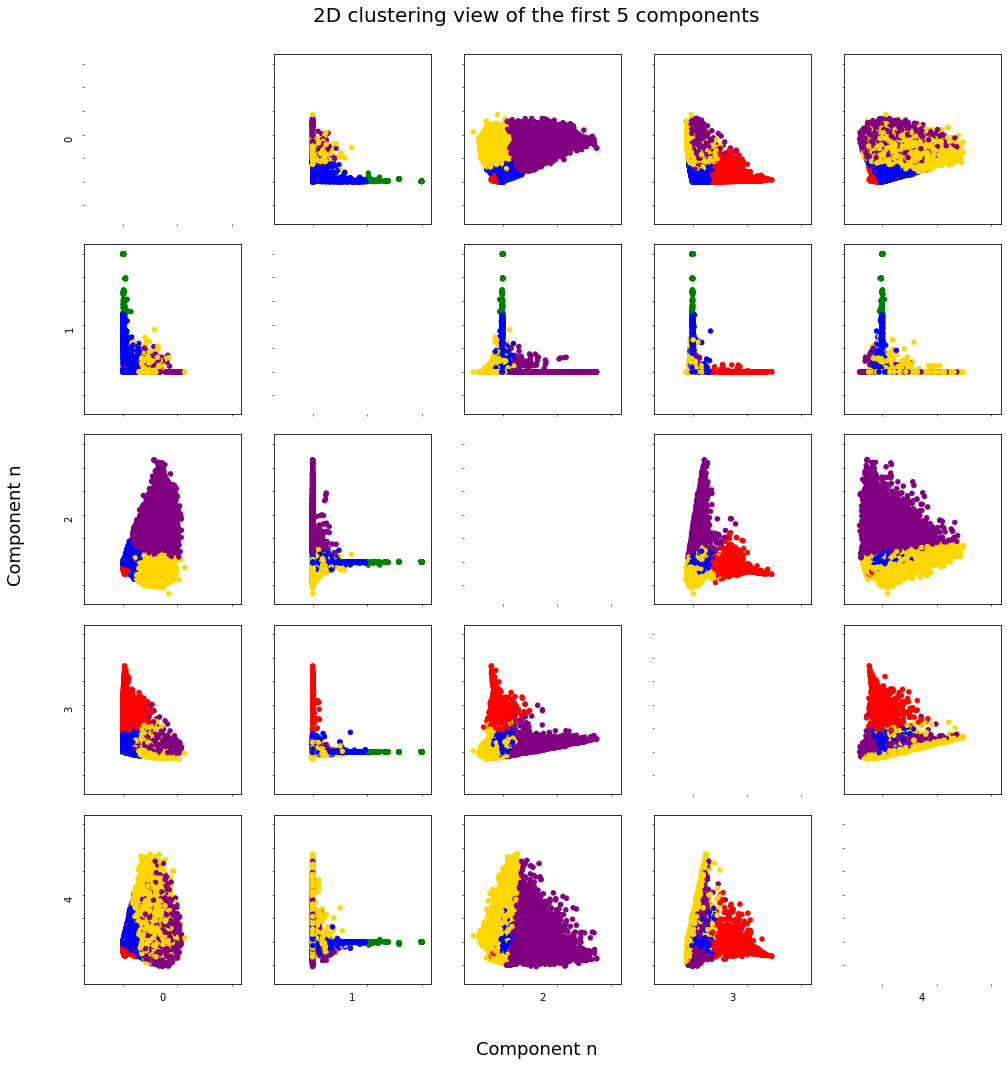

In [9]:
col = df_plot['Cluster'].map({0:'b', 1:'r', 2: 'g', 3:'purple', 4:'gold'})

# variable for first n dimensions we want to plot
n = 5

# visualize the clusters by first n dimensions (reduced)
fig, ax = plt.subplots(n, n, sharex=True, sharey=True, figsize=(15,15))
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# plot it
k = 0
for i in range(0,n):
    for j in range(0,n):
        if i != j:
            df_plot.plot(kind = 'scatter', x=j, y=i, c=col, ax = ax[i][j], fontsize = 18)
        else:
            ax[i][j].set_xlabel(i)
            ax[i][j].set_ylabel(j)
            ax[i][j].set_frame_on(False)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
plt.suptitle('2D clustering view of the first {} components'.format(n), fontsize = 20)
fig.text(0.5, 0.01, 'Component n', ha='center', fontsize = 18)
fig.text(0.01, 0.5, 'Component n', va='center', rotation='vertical', fontsize = 18)

In [13]:
df['Cluster'] = df_plot['Cluster']

# function for finding most significant words for each cluster
def generate_text(cluster):
    
    df_s = df['lyrics']
    y = df['Cluster'].map(lambda x: 1 if x == cluster else 0)
    count = len(df_s)
    
    tfidf = TfidfVectorizer(stop_words = 'english')
    X = tfidf.fit_transform(df_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = LogisticRegression(random_state = 0).fit(X_train, y_train)
    clf_d = DummyClassifier().fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    acc_d = clf_d.score(X_test, y_test)
    coef = clf.coef_.tolist()[0]
    w = tfidf.get_feature_names()
    coeff_df = pd.DataFrame({'words' : w, 'score' : coef})
    coeff_df = coeff_df.sort_values(['score', 'words'], ascending=[0, 1])
    coeff_df = coeff_df[:30]
    d = coeff_df.set_index('words')['score'].to_dict()
    return d, acc, acc_d

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


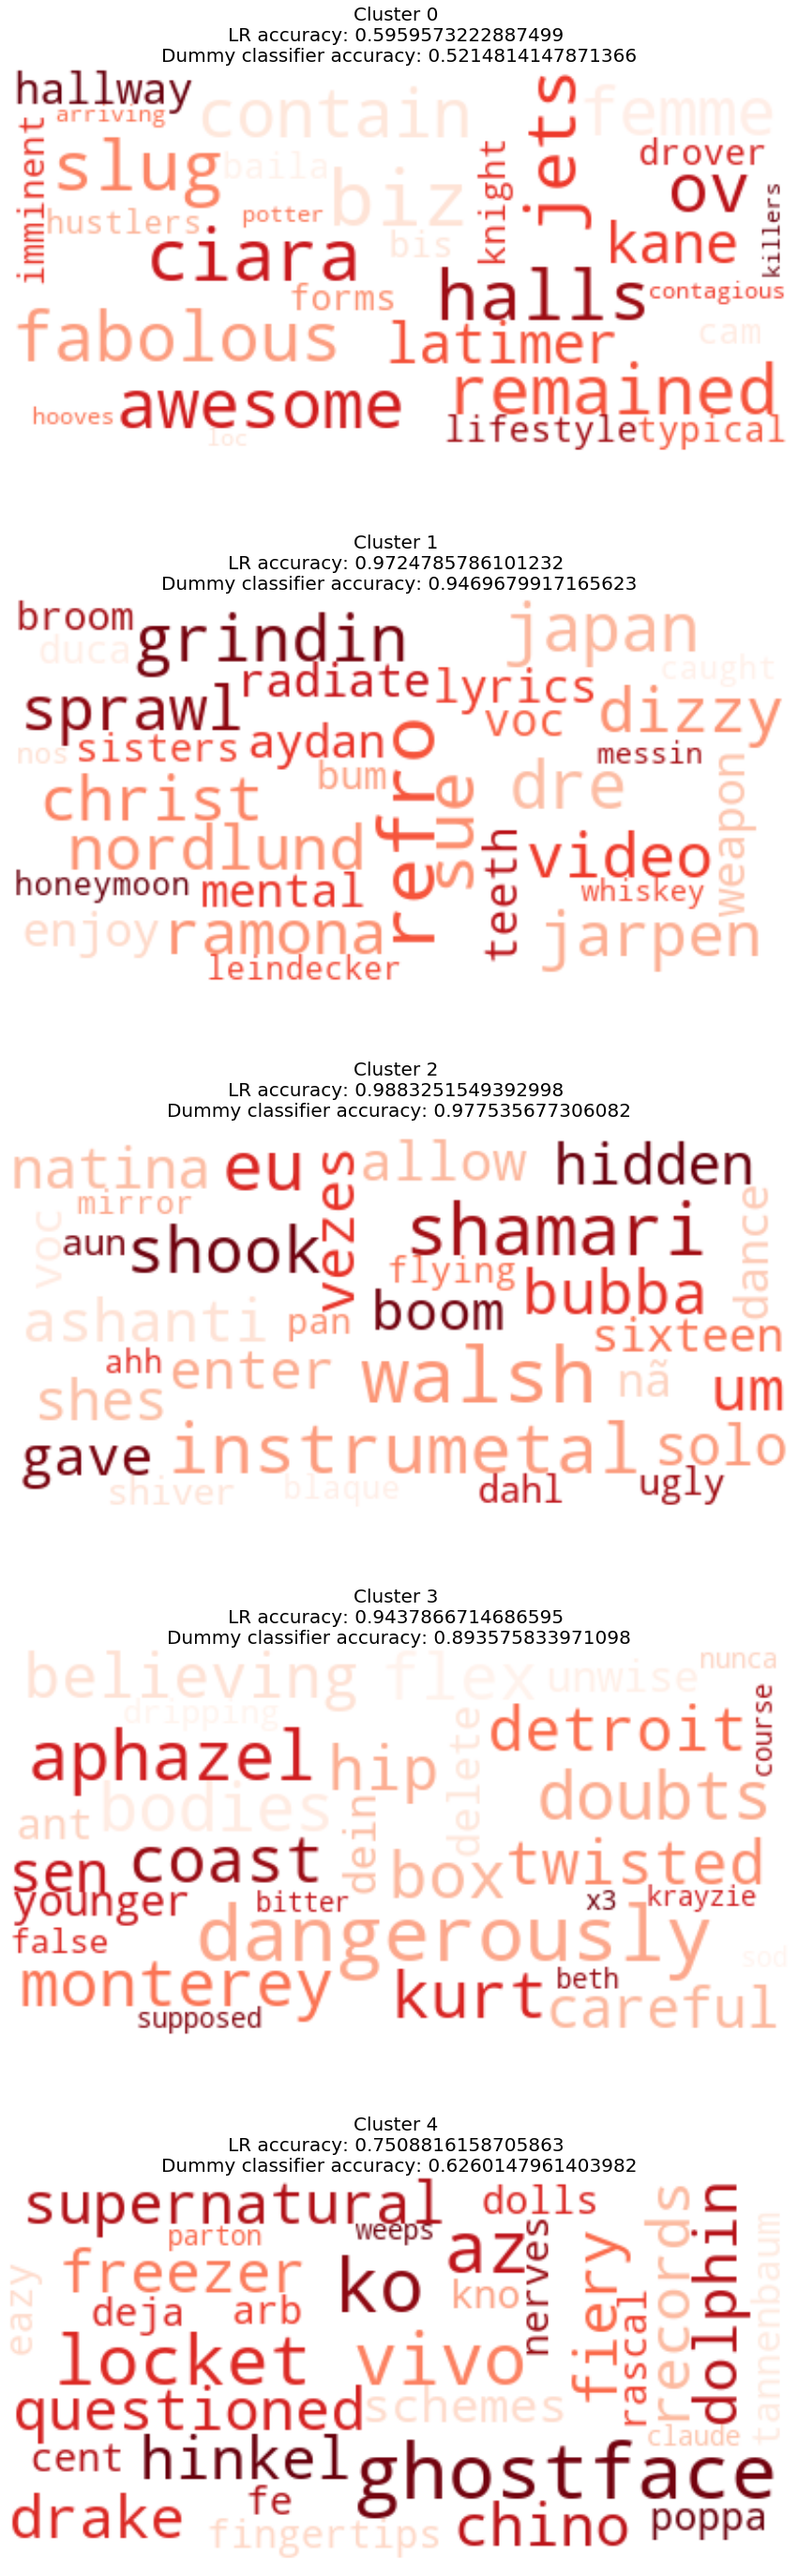

In [14]:
fig, ax = plt.subplots(n_clusters, sharex=True, figsize=(15,10*n_clusters))

for i in range(0, n_clusters):
    d, acc, acc_d = generate_text(i)
    wordcloud = WordCloud(max_font_size=40, collocations=False, colormap = 'Reds', background_color = 'white').fit_words(d)
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].set_title('Cluster {} \nLR accuracy: {} \nDummy classifier accuracy: {}'.format(i, acc, acc_d), fontsize = 20)
    ax[i].axis("off")

In [15]:
no_topics = 5

c = CountVectorizer(stop_words='english')
X_text_c = c.fit_transform(df['lyrics'])

lda = LatentDirichletAllocation(learning_method = 'online', n_components=no_topics, random_state=0).fit(X_text_c)
X_text_c_feature_names = c.get_feature_names()

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, X_text_c_feature_names, no_top_words)

Topic 0:
la que el en te tu es ich se mi
Topic 1:
like got shit ain man nigga ya fuck em money
Topic 2:
ll life time away ve love world heart eyes just
Topic 3:
don know love just oh got like want baby ll
Topic 4:
na da di mi che non ni la dem ba


clusterin on CB

In [191]:
#components for features reduction
n_components = 5

# number of clusters we want
n_clusters = 5

# covert words into TFIDF metrics
tfidf = TfidfVectorizer(stop_words = 'english')
X_text = tfidf.fit_transform(cb['lyrics'])

# reduce dimensions
svd = TruncatedSVD(n_components=n_components, random_state = 0)
X_2d = svd.fit_transform(X_text)

# fit k-mean clustering
kmeans = KMeans(n_clusters=n_clusters, random_state = 0)

# predict our clusters for each song
X_clustered = kmeans.fit_predict(X_2d)

# display by groups
df_plot = pd.DataFrame(list(X_2d), list(X_clustered))
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'index': 'Cluster'}, inplace = True)
df_plot['Cluster'] = df_plot['Cluster'].astype(int)

print(df_plot.head())

print(df_plot.groupby('Cluster').agg({'Cluster': 'count'}))

   Cluster         0         1         2         3         4
0        1  0.194567 -0.046968 -0.024934 -0.055834  0.013802
1        3  0.318739 -0.166938  0.020800 -0.143071  0.135136
2        3  0.378136 -0.164853 -0.086116 -0.033337 -0.020793
3        1  0.137673 -0.015107  0.020059  0.053142 -0.011176
4        1  0.138648  0.012673 -0.000839 -0.027500 -0.014995
         Cluster
Cluster         
0             80
1            392
2             12
3            101
4             43


Text(0.01, 0.5, 'Component n')

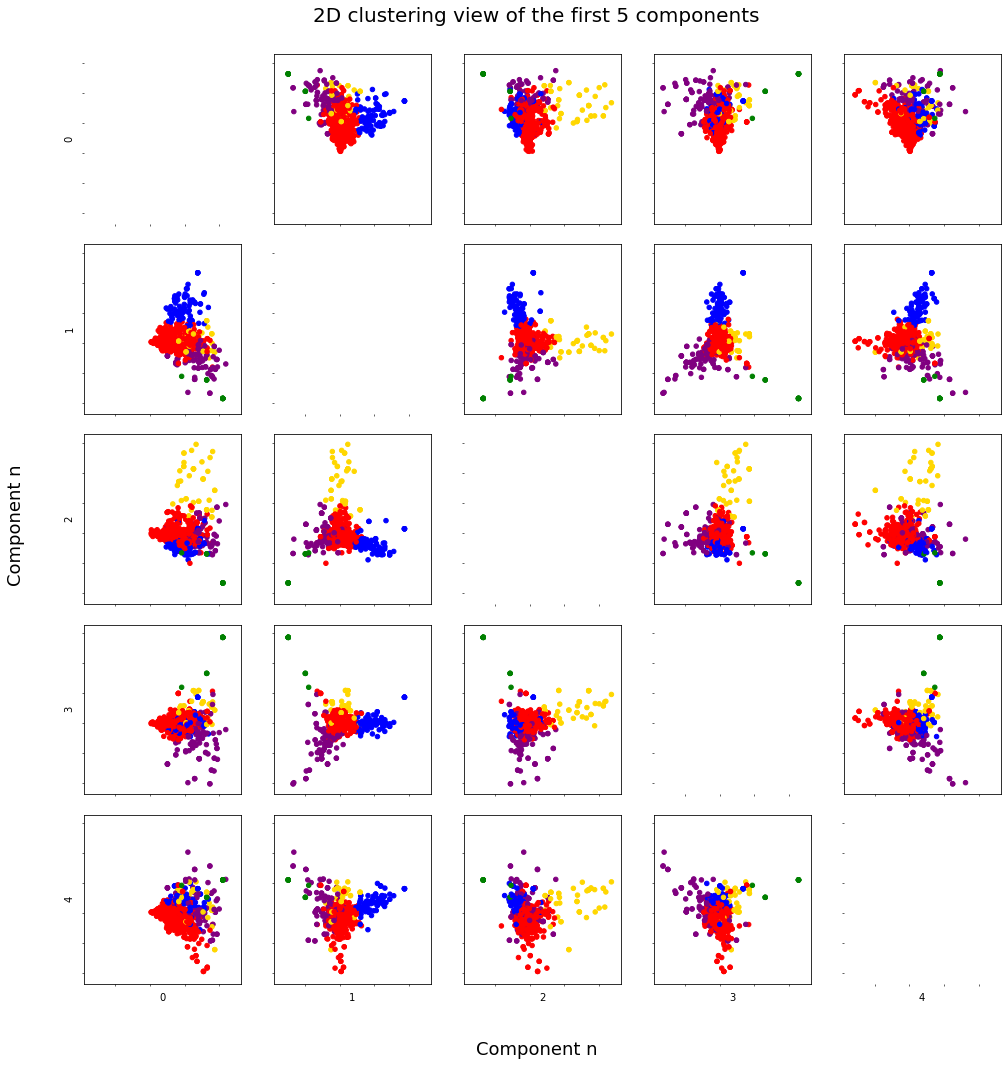

In [192]:
col = df_plot['Cluster'].map({0:'b', 1:'r', 2: 'g', 3:'purple', 4:'gold'})

# variable for first n dimensions we want to plot
n = 5

# visualize the clusters by first n dimensions (reduced)
fig, ax = plt.subplots(n, n, sharex=True, sharey=True, figsize=(15,15))
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# plot it
k = 0
for i in range(0,n):
    for j in range(0,n):
        if i != j:
            df_plot.plot(kind = 'scatter', x=j, y=i, c=col, ax = ax[i][j], fontsize = 18)
        else:
            ax[i][j].set_xlabel(i)
            ax[i][j].set_ylabel(j)
            ax[i][j].set_frame_on(False)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
plt.suptitle('2D clustering view of the first {} components'.format(n), fontsize = 20)
fig.text(0.5, 0.01, 'Component n', ha='center', fontsize = 18)
fig.text(0.01, 0.5, 'Component n', va='center', rotation='vertical', fontsize = 18)

In [193]:
df['Cluster'] = df_plot['Cluster']

# function for finding most significant words for each cluster
def generate_text(cluster):
    
    df_s = df['lyrics']
    y = df['Cluster'].map(lambda x: 1 if x == cluster else 0)
    count = len(df_s)
    
    tfidf = TfidfVectorizer(stop_words = 'english')
    X = tfidf.fit_transform(df_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = LogisticRegression(random_state = 0).fit(X_train, y_train)
    clf_d = DummyClassifier().fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    acc_d = clf_d.score(X_test, y_test)
    coef = clf.coef_.tolist()[0]
    w = tfidf.get_feature_names()
    coeff_df = pd.DataFrame({'words' : w, 'score' : coef})
    coeff_df = coeff_df.sort_values(['score', 'words'], ascending=[0, 1])
    coeff_df = coeff_df[:30]
    d = coeff_df.set_index('words')['score'].to_dict()
    return d, acc, acc_d

In [197]:
no_topics = 5

c = CountVectorizer(stop_words='english')
X_text_c = c.fit_transform(cb['lyrics'])

lda = LatentDirichletAllocation(learning_method = 'online', n_components=no_topics, random_state=0).fit(X_text_c)
X_text_c_feature_names = c.get_feature_names()

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20
display_topics(lda, X_text_c_feature_names, no_top_words)

Topic 0:
girl know oh love like don baby just got yeah wanna let ain cause want right say make nigga need
Topic 1:
na like got shabba chance yeah bitch red 100 cherry look bomb em ballin stereotype niggas bereit sweetheart eye kross
Topic 2:
girl wait yeah wanna ready whippin like ya body know heart eh got boom seen man ll baby shut ooh
Topic 3:
like got kiss solo know girl want gimme gotta cause ya singing em womp im just yeah holla wit don
Topic 4:
wall la don zero dreamer ladies captive calling bassline coming purpose hear tryna crawl movie used ll packed holding em


### analyzing drug references in songs

In [16]:
df = df[df['word_count'] != 1]
df['word_count'].groupby(df['genre']).describe()

count        mean         std  min    25%    50%    75%  \
genre                                                                       
Country         14323.0  186.913426   82.254845  3.0  129.0  171.0  231.0   
Electronic       7620.0  202.111680  135.602990  2.0  110.0  177.0  264.0   
Folk             2108.0  192.566888  115.198695  4.0  121.0  175.0  244.0   
Hip-Hop         24765.0  491.640299  237.307748  2.0  341.0  486.0  629.0   
Indie            3104.0  199.693621  106.541654  3.0  128.0  184.0  249.0   
Jazz             7825.0  175.237188   95.478588  2.0  110.0  153.0  216.0   
Metal           22995.0  174.652794  110.359008  2.0  105.0  155.0  220.0   
Not Available   23317.0  215.860831  131.510207  2.0  132.0  192.0  273.0   
Other            5183.0  224.267992  139.287456  3.0  128.0  193.0  286.0   
Pop             40263.0  246.975213  127.840684  2.0  158.0  225.0  311.0   
R&B              3391.0  225.592156  119.607676  2.0  142.0  204.0  281.5   
Rock           107820.0  193.194333  104.301925  2.0  127.0  178.0  242.0   

                  max  
genre                  
Country        1366.0  
Electronic     1920.0  
Folk           2393.0  
Hip-Hop        8195.0  
Indie          1262.0  
Jazz           1040.0  
Metal          2423.0  
Not Available  2570.0  
Other          1569.0  
Pop            1704.0  
R&B            1440.0  
Rock           6232.0

In [229]:
df100 = df.loc[df['word_count'] <= 100]
df100

index                       song  year           artist  genre  \
43          43                   diamonds  2007  beyonce-knowles    Pop   
78          78     god-made-you-beautiful  2013  beyonce-knowles    Pop   
83          83       i-m-glad-there-s-you  2010  beyonce-knowles    Pop   
85          85           freakdum-dresses  2010  beyonce-knowles    Pop   
89          89                       helo  2012  beyonce-knowles    Pop   
...        ...                        ...   ...              ...    ...   
362194  362194           sunset-coming-in  2015     damon-albarn    Pop   
362208  362208            everyday-robots  2014     damon-albarn    Pop   
362212  362212               hollow-ponds  2014     damon-albarn    Pop   
362219  362219                      trilo  2015     ale-mrthller  Other   
362226  362226  you-ll-never-know-my-name  2015         dee-smgn  Other   

                                                   lyrics  word_count  Cluster  
43      Square-cut or pear shaped, These rocks don't l...        28.0      1.0  
78      When you were born The angels sighed in deligh...        85.0      1.0  
83      In this world Of ordinary people Exraordinary ...        92.0      1.0  
85              it's about getting our freakdum drsses on         7.0      1.0  
89      baby you know i love you baby you know i need ...        35.0      3.0  
...                                                   ...         ...      ...  
362194  Waking up It's been too long Feel the warmth O...        52.0      NaN  
362208  We are everyday robots on our phones In the pr...        79.0      NaN  
362212  Chill on the hollow ponds Set sail by a kid In...        70.0      NaN  
362219                   Trilo! HÃ¤r Ã¤r han. NÃ¤ra land.         6.0      NaN  
362226  You'll never know my name And my pictures will...        83.0      NaN  

[38045 rows x 8 columns]

In [230]:
df1000 = df.loc[df['word_count'] >= 1000]
df1000

index                                      song  year  \
95          95                             get-me-bodied  2006   
113        113  get-me-bodied-extended-remix-bonus-track  2006   
1590      1590                      tour-hip-hop-version  2006   
2339      2339                                     burnt  2007   
7464      7464                                      stan  2006   
...        ...                                       ...   ...   
357783  357783                    hell-frezes-over-album  2006   
357950  357950                           a-peez-paradise  2007   
360213  360213                      love-s-gonna-get-cha  2006   
360222  360222                                7-dee-jays  2006   
360241  360241                                 ruff-ruff  2006   

                          artist       genre  \
95               beyonce-knowles         Pop   
113              beyonce-knowles         Pop   
1590                    capleton  Electronic   
2339    del-the-funky-homosapien     Hip-Hop   
7464                        dido         Pop   
...                          ...         ...   
357783                the-eagles        Rock   
357950           andre-nickatina     Hip-Hop   
360213   boogie-down-productions     Hip-Hop   
360222   boogie-down-productions     Hip-Hop   
360241   boogie-down-productions     Hip-Hop   

                                                   lyrics  word_count  Cluster  
95      Nine, four, eight, one B day Mission one: I'm-...      1122.0      1.0  
113     Nine, four, eight, one B'day Mission one, Ima ...      1014.0      3.0  
1590    Yeah I say straighten yuh crooked ways Blessed...      1034.0      NaN  
2339    DEL: Mista, twista, get ya every single time w...      1068.0      NaN  
7464    My tea's gone cold I'm wondering why I Got out...      1238.0      NaN  
...                                                   ...         ...      ...  
357783  Get Over It I turn on the tube and what do I s...      3253.0      NaN  
357950  A Peez Paradise "god bless every livin mac tha...      1027.0      NaN  
360213  Ya know that's why man I be telling you all th...      1046.0      NaN  
360222  [KRS One] YES! Chillin in the place right now ...      1613.0      NaN  
360241  featuring Freddie Foxxx [KRS One] * voice echo...      1128.0      NaN  

[605 rows x 8 columns]

In [231]:
del df100, df1000 
df_clean = df[df['word_count'] >= 100]
df_clean = df[df['word_count'] <= 1000]
df_clean['word_count'].groupby(df_clean['genre']).describe()

count        mean         std  min    25%    50%     75%  \
genre                                                                        
Country         14386.0  186.004379   82.416826  1.0  128.0  171.0  231.00   
Electronic       7962.0  192.795152  136.173372  1.0  100.0  170.0  259.00   
Folk             2241.0  179.562249  108.819267  1.0  111.0  168.0  238.00   
Hip-Hop         24404.0  476.774176  209.424187  1.0  337.0  480.0  618.25   
Indie            3146.0  195.974889  104.568969  1.0  126.0  182.0  248.00   
Jazz             7969.0  171.958339   96.949811  1.0  108.0  152.0  215.00   
Metal           23746.0  168.427061  108.776466  1.0  100.0  152.0  217.00   
Not Available   23917.0  209.216875  129.605487  1.0  126.0  189.0  269.00   
Other            5186.0  223.320671  136.448083  1.0  127.0  193.0  285.00   
Pop             40439.0  245.123519  126.435586  1.0  157.0  224.0  311.00   
R&B              3399.0  224.273904  116.955466  1.0  142.0  204.0  281.00   
Rock           109162.0  189.813571   98.194167  1.0  125.0  177.0  241.00   

                  max  
genre                  
Country         895.0  
Electronic      990.0  
Folk            998.0  
Hip-Hop        1000.0  
Indie           952.0  
Jazz            935.0  
Metal           999.0  
Not Available   994.0  
Other           986.0  
Pop            1000.0  
R&B             892.0  
Rock            998.0

In [232]:
genre = df.groupby(['genre'],as_index=False).count()
genre2 = genre[['genre','song']]
genre2

genre    song
0         Country   14387
1      Electronic    7966
2            Folk    2243
3         Hip-Hop   24850
4           Indie    3149
5            Jazz    7970
6           Metal   23759
7   Not Available   23941
8           Other    5189
9             Pop   40466
10            R&B    3401
11           Rock  109235

In [233]:
liquor = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('liquor')].count()))
liquor.reset_index(inplace=True)
liquor.columns = ['genre', 'liquor_lyrics']
liquor


genre  liquor_lyrics
0         Country             49
1      Electronic             12
2            Folk              8
3         Hip-Hop            853
4           Indie              4
5            Jazz             11
6           Metal             37
7   Not Available             58
8           Other             23
9             Pop             56
10            R&B             10
11           Rock            252

In [234]:
beer = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('beer')].count()))
beer.reset_index(inplace=True)
beer.columns = ['genre', 'beer_lyrics']
beer

genre  beer_lyrics
0         Country          341
1      Electronic           26
2            Folk           34
3         Hip-Hop          389
4           Indie           22
5            Jazz           45
6           Metal           72
7   Not Available          190
8           Other           23
9             Pop          137
10            R&B           13
11           Rock         1042

In [235]:
wine = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('wine')].count()))
wine.reset_index(inplace=True)
wine.columns = ['genre', 'wine_lyrics']
wine

genre  wine_lyrics
0         Country          456
1      Electronic           90
2            Folk           57
3         Hip-Hop          759
4           Indie           55
5            Jazz          161
6           Metal          427
7   Not Available          364
8           Other           70
9             Pop          535
10            R&B           53
11           Rock         1953

In [236]:
pills = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('pills')].count()))
pills.reset_index(inplace=True)
pills.columns = ['genre', 'pills_lyrics']
pills

genre  pills_lyrics
0         Country            36
1      Electronic            31
2            Folk             8
3         Hip-Hop           463
4           Indie            22
5            Jazz            16
6           Metal            99
7   Not Available            81
8           Other            18
9             Pop            77
10            R&B            13
11           Rock           575

In [237]:
weed = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('weed')].count()))
weed.reset_index(inplace=True)
weed.columns = ['genre', 'weed_lyrics']
weed

genre  weed_lyrics
0         Country           73
1      Electronic           45
2            Folk           17
3         Hip-Hop         2145
4           Indie           25
5            Jazz           26
6           Metal          102
7   Not Available          106
8           Other           29
9             Pop          116
10            R&B           18
11           Rock          473

In [238]:
molly = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('molly')].count()))
molly.reset_index(inplace=True)
molly.columns = ['genre', 'molly_lyrics']
molly

genre  molly_lyrics
0         Country             0
1      Electronic             0
2            Folk             0
3         Hip-Hop           187
4           Indie             0
5            Jazz             0
6           Metal             1
7   Not Available            13
8           Other             9
9             Pop             7
10            R&B             1
11           Rock            18

In [239]:
percocet = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('percocet')].count()))
percocet.reset_index(inplace=True)
percocet.columns = ['genre', 'percocet_lyrics']
percocet

genre  percocet_lyrics
0         Country                0
1      Electronic                0
2            Folk                0
3         Hip-Hop               16
4           Indie                1
5            Jazz                0
6           Metal                1
7   Not Available                0
8           Other                0
9             Pop                1
10            R&B                0
11           Rock                2

In [240]:
booze = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('booze')].count()))
booze.reset_index(inplace=True)
booze.columns = ['genre', 'booze_lyrics']
booze

genre  booze_lyrics
0         Country            35
1      Electronic            16
2            Folk             4
3         Hip-Hop            79
4           Indie             1
5            Jazz            14
6           Metal            29
7   Not Available            18
8           Other             9
9             Pop            25
10            R&B             3
11           Rock           224

In [241]:
codeine = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('codeine')].count()))
codeine.reset_index(inplace=True)
codeine.columns = ['genre', 'codeine_lyrics']
codeine

genre  codeine_lyrics
0         Country               2
1      Electronic               1
2            Folk               0
3         Hip-Hop              89
4           Indie               0
5            Jazz               0
6           Metal               0
7   Not Available               3
8           Other               4
9             Pop               3
10            R&B               1
11           Rock               8

In [242]:
import functools
dfs = [genre2,beer,wine,liquor,pills,weed,molly,percocet,booze,codeine]
genre3 = functools.reduce(lambda left,right: pd.merge(left,right,on='genre', how='outer'), dfs)
genre3

genre    song  beer_lyrics  wine_lyrics  liquor_lyrics  \
0         Country   14387          341          456             49   
1      Electronic    7966           26           90             12   
2            Folk    2243           34           57              8   
3         Hip-Hop   24850          389          759            853   
4           Indie    3149           22           55              4   
5            Jazz    7970           45          161             11   
6           Metal   23759           72          427             37   
7   Not Available   23941          190          364             58   
8           Other    5189           23           70             23   
9             Pop   40466          137          535             56   
10            R&B    3401           13           53             10   
11           Rock  109235         1042         1953            252   

    pills_lyrics  weed_lyrics  molly_lyrics  percocet_lyrics  booze_lyrics  \
0             36           73             0                0            35   
1             31           45             0                0            16   
2              8           17             0                0             4   
3            463         2145           187               16            79   
4             22           25             0                1             1   
5             16           26             0                0            14   
6             99          102             1                1            29   
7             81          106            13                0            18   
8             18           29             9                0             9   
9             77          116             7                1            25   
10            13           18             1                0             3   
11           575          473            18                2           224   

    codeine_lyrics  
0                2  
1                1  
2                0  
3               89  
4                0  
5                0  
6                0  
7                3  
8                4  
9                3  
10               1  
11               8

In [243]:
genre3['wine_ratio'] = genre3['wine_lyrics'] / genre3['song']
genre3['beer_ratio'] = genre3['beer_lyrics'] / genre3['song']
genre3['liquor_ratio'] = genre3['liquor_lyrics'] / genre3['song']
genre3['pills_ratio'] = genre3['pills_lyrics'] / genre3['song']
genre3['weed_ratio'] = genre3['weed_lyrics'] / genre3['song']
genre3['molly_ratio'] = genre3['molly_lyrics'] / genre3['song']
genre3['percocet_ratio'] = genre3['percocet_lyrics'] / genre3['song']
genre3['booze_ratio'] = genre3['booze_lyrics'] / genre3['song']
genre3['codeine_ratio'] = genre3['codeine_lyrics'] / genre3['song']

genre3

genre    song  beer_lyrics  wine_lyrics  liquor_lyrics  \
0         Country   14387          341          456             49   
1      Electronic    7966           26           90             12   
2            Folk    2243           34           57              8   
3         Hip-Hop   24850          389          759            853   
4           Indie    3149           22           55              4   
5            Jazz    7970           45          161             11   
6           Metal   23759           72          427             37   
7   Not Available   23941          190          364             58   
8           Other    5189           23           70             23   
9             Pop   40466          137          535             56   
10            R&B    3401           13           53             10   
11           Rock  109235         1042         1953            252   

    pills_lyrics  weed_lyrics  molly_lyrics  percocet_lyrics  booze_lyrics  \
0             36           73             0                0            35   
1             31           45             0                0            16   
2              8           17             0                0             4   
3            463         2145           187               16            79   
4             22           25             0                1             1   
5             16           26             0                0            14   
6             99          102             1                1            29   
7             81          106            13                0            18   
8             18           29             9                0             9   
9             77          116             7                1            25   
10            13           18             1                0             3   
11           575          473            18                2           224   

    codeine_lyrics  wine_ratio  beer_ratio  liquor_ratio  pills_ratio  \
0                2    0.031695    0.023702      0.003406     0.002502   
1                1    0.011298    0.003264      0.001506     0.003892   
2                0    0.025412    0.015158      0.003567     0.003567   
3               89    0.030543    0.015654      0.034326     0.018632   
4                0    0.017466    0.006986      0.001270     0.006986   
5                0    0.020201    0.005646      0.001380     0.002008   
6                0    0.017972    0.003030      0.001557     0.004167   
7                3    0.015204    0.007936      0.002423     0.003383   
8                4    0.013490    0.004432      0.004432     0.003469   
9                3    0.013221    0.003386      0.001384     0.001903   
10               1    0.015584    0.003822      0.002940     0.003822   
11               8    0.017879    0.009539      0.002307     0.005264   

    weed_ratio  molly_ratio  percocet_ratio  booze_ratio  codeine_ratio  
0     0.005074     0.000000        0.000000     0.002433       0.000139  
1     0.005649     0.000000        0.000000     0.002009       0.000126  
2     0.007579     0.000000        0.000000     0.001783       0.000000  
3     0.086318     0.007525        0.000644     0.003179       0.003581  
4     0.007939     0.000000        0.000318     0.000318       0.000000  
5     0.003262     0.000000        0.000000     0.001757       0.000000  
6     0.004293     0.000042        0.000042     0.001221       0.000000  
7     0.004428     0.000543        0.000000     0.000752       0.000125  
8     0.005589     0.001734        0.000000     0.001734       0.000771  
9     0.002867     0.000173        0.000025     0.000618       0.000074  
10    0.005293     0.000294        0.000000     0.000882       0.000294  
11    0.004330     0.000165        0.000018     0.002051       0.000073

In [ ]:
## most common words

In [162]:
genre3

genre    song  beer_lyrics  wine_lyrics  liquor_lyrics  \
0   Country        14387   341          456          49              
1   Electronic     7966    26           90           12              
2   Folk           2243    34           57           8               
3   Hip-Hop        24850   389          751          851             
4   Indie          3149    21           55           4               
5   Jazz           7970    45           161          11              
6   Metal          23759   71           426          37              
7   Not Available  23941   190          364          58              
8   Other          5189    23           70           23              
9   Pop            40466   137          535          56              
10  R&B            3401    13           53           10              
11  Rock           109235  1042         1952         252             

    pills_lyrics  weed_lyrics  molly_lyrics  percocet_lyrics  booze_lyrics  \
0   36            73           0             0                35             
1   31            45           0             0                16             
2   8             17           0             0                4              
3   462           2141         186           16               79             
4   22            25           0             1                1              
5   16            26           0             0                14             
6   99            102          1             1                28             
7   81            106          13            0                18             
8   18            29           9             0                9              
9   77            115          7             1                25             
10  13            18           1             0                3              
11  574           472          18            2                224            

    codeine_lyrics  wine_ratio  liquor_ratio  pills_ratio  weed_ratio  \
0   2               0.031695    0.003406      0.002502     0.005074     
1   1               0.011298    0.001506      0.003892     0.005649     
2   0               0.025412    0.003567      0.003567     0.007579     
3   89              0.030221    0.034245      0.018592     0.086157     
4   0               0.017466    0.001270      0.006986     0.007939     
5   0               0.020201    0.001380      0.002008     0.003262     
6   0               0.017930    0.001557      0.004167     0.004293     
7   3               0.015204    0.002423      0.003383     0.004428     
8   4               0.013490    0.004432      0.003469     0.005589     
9   3               0.013221    0.001384      0.001903     0.002842     
10  1               0.015584    0.002940      0.003822     0.005293     
11  8               0.017870    0.002307      0.005255     0.004321     

    molly_ratio  percocet_ratio  booze_ratio  codeine_ratio  
0   0.000000     0.000000        0.002433     0.000139       
1   0.000000     0.000000        0.002009     0.000126       
2   0.000000     0.000000        0.001783     0.000000       
3   0.007485     0.000644        0.003179     0.003581       
4   0.000000     0.000318        0.000318     0.000000       
5   0.000000     0.000000        0.001757     0.000000       
6   0.000042     0.000042        0.001179     0.000000       
7   0.000543     0.000000        0.000752     0.000125       
8   0.001734     0.000000        0.001734     0.000771       
9   0.000173     0.000025        0.000618     0.000074       
10  0.000294     0.000000        0.000882     0.000294       
11  0.000165     0.000018        0.002051     0.000073

In [244]:
drugDF = genre3.drop(['song','beer_lyrics','wine_lyrics','liquor_lyrics','pills_lyrics','weed_lyrics','molly_lyrics','percocet_lyrics','booze_lyrics','codeine_lyrics'],axis=1)
drugDF = drugDF.corr()

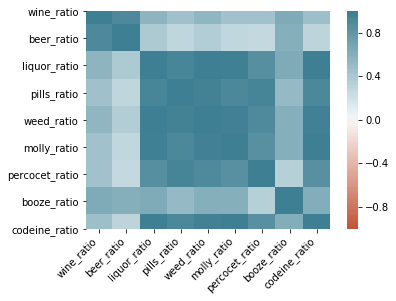

In [245]:
import seaborn as sns
ax = sns.heatmap(
    drugDF, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax

In [246]:
import seaborn as sns
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

drugDF.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

In [ ]:
##word cloud on chris brown

In [177]:
from io import StringIO

# Use nltk for valid words
import nltk
# Need to make hash 'dictionaries' from nltk for fast processing
import collections as co


In [178]:
s=StringIO()
cb['lyrics'].apply(lambda x: s.write(x))

k=s.getvalue()
s.close()
k=k.lower()
k=k.split()

In [180]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\sriva\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [181]:
words = co.Counter(nltk.corpus.words.words())
stopWords =co.Counter( nltk.corpus.stopwords.words() )
k=[i for i in k if i in words and i not in stopWords]
s=" ".join(k)
c = co.Counter(k)

In [183]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


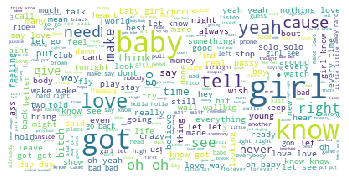

In [184]:
from wordcloud import WordCloud

# Read the whole text.
text = s

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt


# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(k),max_font_size=40, relative_scaling=.8).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
## predicting genre

In [190]:
from io import StringIO
col = ['genre', 'lyrics']
chris = cb[col]
chris = chris[pd.notnull(chris['lyrics'])]
chris.columns = ['genre', 'lyrics']
chris['category_id'] = chris['genre'].factorize()[0]
category_id_df = chris[['genre', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'genre']].values)
chris.head()

genre  \
120340  Hip-Hop   
120341  Hip-Hop   
120342  Hip-Hop   
120343  Hip-Hop   
120344  Hip-Hop   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              lyrics  \
120340  We can jet, believe it I know that you won't And yes, there's a feelin' We both need to know Let us start now It's that time So let's travel And see the light And I'm Gonna take you out Anywhere you wanna go now If you ride To the town Where we both can party now Drink in London Dance in Paris Let's chase our love Let's chase our love Shout real loud now And let them hear us Let's chase our love Let's chase our love Tonight, night, night, night Night, night, night Tonight, night, night, night Let's chase our love Let's chase our love Tonight, night, night Tonight, night, night If it's evening We'll party til' morning Let us start now It's that time So let's travel, see the light I'll watch you shine Drink in London Dance in Paris Let's chase our love Let's chase our love Shout real loud now And let them hear us Let's chase our love Let's chase our love Tonight, night, night, night Night, night, night Tonight, night, night, night Let's chase our love Let's chase our love Tonight, night, night Tonight, night, night                                                                                                                                                                                                                                                   

In [179]:
from io import StringIO
col = ['genre', 'lyrics']
df1 = df_clean[col]
df1 = df_clean[pd.notnull(df_clean['lyrics'])]
#df1.columns = ['genre', 'lyrics']
df1

index                         song  year           artist    genre  \
0            0                    ego-remix  2009  beyonce-knowles      Pop   
1            1                 then-tell-me  2009  beyonce-knowles      Pop   
2            2                      honesty  2009  beyonce-knowles      Pop   
3            3              you-are-my-rock  2009  beyonce-knowles      Pop   
4            4                black-culture  2009  beyonce-knowles      Pop   
...        ...                          ...   ...              ...      ...   
362232  362232    who-am-i-drinking-tonight  2012       edens-edge  Country   
362233  362233                         liar  2012       edens-edge  Country   
362234  362234                  last-supper  2012       edens-edge  Country   
362235  362235  christ-alone-live-in-studio  2012       edens-edge  Country   
362236  362236                         amen  2012       edens-edge  Country   

                                                   lyrics  word_count  
0       Oh baby, how you doing? You know I'm gonna cut...       433.0  
1       playin' everything so easy, it's like you seem...       258.0  
2       If you search For tenderness It isn't hard to ...       170.0  
3       Oh oh oh I, oh oh oh I If I wrote a book about...       522.0  
4       Party the people, the people the party it's po...       312.0  
...                                                   ...         ...  
362232  I gotta say Boy, after only just a couple of d...       327.0  
362233  I helped you find her diamond ring You made me...       205.0  
362234  Look at the couple in the corner booth Looks a...       245.0  
362235  When I fly off this mortal earth And I'm measu...       171.0  
362236  I heard from a friend of a friend of a friend ...       330.0  

[265957 rows x 7 columns]

In [255]:
df1['category_id'] = df1['genre'].factorize()[0]
category_id_df = df1[['genre', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.genre.values)
id_to_category = dict(category_id_df[['category_id', 'genre']].values)

ValueError: dictionary update sequence element #0 has length 3; 2 is required

In [253]:
category_id_df

genre  category_id
0               Pop            0
249         Hip-Hop            1
350   Not Available            2
404            Rock            3
415           Metal            4
453           Other            5
614         Country            6
687            Jazz            7
833      Electronic            8
860            Folk            9
1539            R&B           10
1643          Indie           11

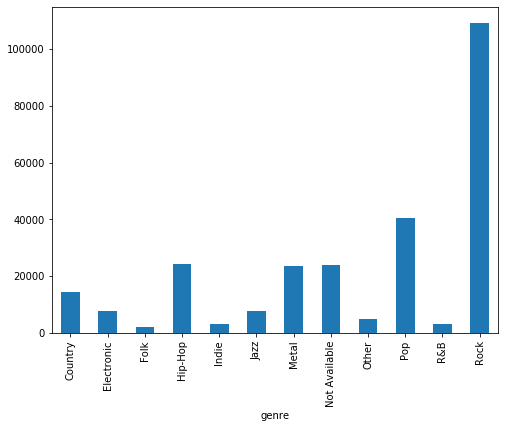

In [167]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df1.groupby('genre').lyrics.count().plot.bar(ylim=0)
plt.show()

In [168]:
df2 = df1[:100000]

In [177]:
id_to_category

{0: 'Pop',
 1: 'Hip-Hop',
 2: 'Not Available',
 3: 'Rock',
 4: 'Metal',
 5: 'Other',
 6: 'Country',
 7: 'Jazz',
 8: 'Electronic',
 9: 'Folk',
 10: 'R&B',
 11: 'Indie'}

In [169]:
# Model: Bag-of-words

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english')

In [170]:
features = tfidf.fit_transform(df2.lyrics)#.toarray()
labels = df2.genre
#features.shape

{'Pop': 0,
 'Hip-Hop': 1,
 'Not Available': 2,
 'Rock': 3,
 'Metal': 4,
 'Other': 5,
 'Country': 6,
 'Jazz': 7,
 'Electronic': 8,
 'Folk': 9,
 'R&B': 10,
 'Indie': 11}

In [174]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for lyrics, genre in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == genre)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("--> '{}':".format(category_to_id))
    print("  . Most Correlated Unigrams are :\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most Correlated Bigrams are :\n. {}".format('\n. '.join(bigrams[-N:])))

--> '{'Pop': 0, 'Hip-Hop': 1, 'Not Available': 2, 'Rock': 3, 'Metal': 4, 'Other': 5, 'Country': 6, 'Jazz': 7, 'Electronic': 8, 'Folk': 9, 'R&B': 10, 'Indie': 11}':
  . Most Correlated Unigrams are :
. gittern
. übrig
  . Most Correlated Bigrams are :
. gitros ja
. gitchi gitchi


KeyboardInterrupt: 

In [217]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], df2['genre'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [222]:
print clf.predict(count_vect.transform(["Oh baby, how you doing? You know I'm gonna cut right to the chase Some women were made but me, myself I like to think that I was created for a special purpose You know, what's more special than you"]))

['Rock']


In [163]:
print(clf.predict(count_vect.transform(["ground control to major tom"])))

NameError: name 'clf' is not defined

In [224]:
print(clf.predict(count_vect.transform(["nigga that pussy be slippin oh my g"])))

['Hip-Hop']


In [225]:
print(clf.predict(count_vect.transform(["i love you like no one else"])))

['Rock']


D:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


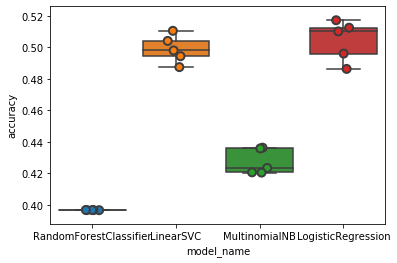

In [226]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
#chris brown analysis

In [13]:
cb = df[(df['artist'] == 'chris-brown')]
cb.head(3)

rap = list(cb['lyrics'])
word=[]
for i in range(0,len(rap)):
    kk = rap[i].replace("\n"," ")
    kk = rap[i].replace("/"," ")
    kk = rap[i].replace(","," ")
    s=kk.split(' ')
    o = [x for x in s if x]
    word.append(o)
    
word = [j for i in word for j in i]
word[:20]

['We',
 'can',
 'jet',
 'believe',
 'it',
 'I',
 'know',
 'that',
 'you',
 "won't",
 'And',
 'yes',
 "there's",
 'a',
 "feelin'",
 'We',
 'both',
 'need',
 'to',
 'know']

In [14]:
import nltk
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sriva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [156]:
el = ["i'm","get","got","like","make","need","let","oh","ooh","see","say","put","want","one","aint","yeah","ya","way", "go","take","ill","cant","tell"] #give more stop words
stop = set(stopwords.words('english'))
word = [word.lower() for word in word]
words = [i for i in word if i not in stop]
words = [i for i in words if i not in el]

In [157]:
import re
for i in range(0,len(words)):
    words[i] = re.sub(r'[^\w\s]','',words[i])
    
words = [x for x in words if x]

In [158]:
from collections import Counter
labels, values = zip(*Counter(words).items())

In [159]:
w = Counter(words)
s = w.most_common(20)
x , y = zip(*(s))

In [160]:
w

Counter({'jet': 21,
         'believe': 108,
         'know': 2413,
         'yes': 110,
         'theres': 149,
         'feelin': 50,
         'us': 276,
         'start': 87,
         'time': 646,
         'lets': 340,
         'travel': 15,
         'light': 108,
         'gonna': 352,
         'anywhere': 31,
         'wanna': 1381,
         'ride': 119,
         'town': 36,
         'party': 188,
         'drink': 120,
         'london': 15,
         'dance': 169,
         'paris': 8,
         'chase': 28,
         'love': 2018,
         'shout': 7,
         'real': 231,
         'loud': 93,
         'hear': 205,
         'tonight': 329,
         'night': 499,
         'evening': 4,
         'well': 170,
         'til': 104,
         'morning': 73,
         'ill': 475,
         'watch': 91,
         'shine': 38,
         'instrumental': 2,
         'kills': 3,
         'cry': 53,
         'even': 249,
         'lie': 274,
         'always': 130,
         'something': 231,
       

In [161]:
s

[('girl', 2881),
 ('know', 2413),
 ('love', 2018),
 ('baby', 1745),
 ('wanna', 1381),
 ('aint', 1229),
 ('cause', 1155),
 ('right', 861),
 ('back', 766),
 ('nigga', 766),
 ('time', 646),
 ('cant', 637),
 ('gotta', 619),
 ('never', 583),
 ('give', 547),
 ('gon', 542),
 ('shit', 505),
 ('fuck', 505),
 ('night', 499),
 ('think', 482)]

In [162]:
import plotly.graph_objs as go
#from plotly.plotly import iplot
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import chart_studio.plotly as py
import plotly.graph_objs as go
#from chart_studio.plotly import iplot

df = [go.Bar(x=x,y=y)]
layout = go.Layout(
    title='Words in Chris Brown Lyrics ',
    xaxis=dict(
        title='Words Used',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Number of times it was used',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
iplot(go.Figure(data= df, layout = layout))

In [22]:
unique_words = sorted(set(words))
len(unique_words)

8114

8178 unique words used by Chris Brown

In [ ]:
### generating lyrics

In [67]:
import sys
sys.executable

'C:\\Users\\user\\Anaconda3\\python.exe'

In [40]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install tensorflow

  Created wheel for absl-py: filename=absl_py-0.8.1-cp37-none-any.whl size=121171 sha256=23d0a14240938ddd66b0c484321bc1e7ab8b404a5022fd840eb46c1eb27edd74
  Stored in directory: C:\Users\sriva\AppData\Local\pip\Cache\wheels\a7\15\a0\0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp37-none-any.whl size=61701 sha256=88f6526f42b4c80060e15f71b1028f804d8c9dc32579a0d0c038da6e01faee6f
  Stored in directory: C:\Users\sriva\AppData\Local\pip\Cache\wheels\2c\b1\94\43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7546 sha256=c043527cf32c33bc51c899c162d993e94864042387d30c096f1ee8e069b8b077
  Stored in directory: C:\Users\sriva\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for termcolor: filename=termcolor-1.1.0-cp37-none-any.whl size=4835 sha256=454b48bd6fc2bc5596f5c40cc19e252a6621667423cc875204f0d993ad1e0d7

In [21]:
import sys
sys.executable
sys.path.append('c:/users/lenovo/appdata/roaming/python/python37/site-packages')

In [42]:
import keras

Using TensorFlow backend.


In [43]:
import numpy as np

In [200]:
from keras.models import Sequential
from keras.layers.noise import GaussianNoise
from keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

mapping these 8000+ words 

In [215]:
rap = np.array(rap)
lyric = (''.join(rap))
l = set(lyric)
len(l)

100

In [216]:
vocab= [k for k in l] 
char_ix={c:i for i,c in enumerate(vocab)}
ix_char={i:c for i,c in enumerate(vocab)}

maxlen=10
vocab_size=len(vocab)

In [217]:
#l.remove(' ') 
l.remove('!') 
l.remove('i') 
#l.remove('/x80') 


In [218]:
  #,' ',"'", '0', '1', '2', '3', '4', '5','6','7','8','9')
l.remove('\x97') 
l.remove('\x99') 


In [219]:
l.remove('\xad')

In [220]:
sentences=[]
next_char=[]
for i in range(len(lyric)-maxlen-1):
    sentences.append(lyric[i:i+maxlen])
    next_char.append(lyric[i+maxlen])
sentences

['We can jet',
 'e can jet,',
 ' can jet, ',
 'can jet, b',
 'an jet, be',
 'n jet, bel',
 ' jet, beli',
 'jet, belie',
 'et, believ',
 't, believe',
 ', believe ',
 ' believe i',
 'believe it',
 'elieve it ',
 'lieve it I',
 'ieve it I ',
 'eve it I k',
 've it I kn',
 'e it I kno',
 ' it I know',
 'it I know ',
 't I know t',
 ' I know th',
 'I know tha',
 ' know that',
 'know that ',
 'now that y',
 'ow that yo',
 'w that you',
 ' that you ',
 'that you w',
 'hat you wo',
 'at you won',
 "t you won'",
 " you won't",
 "you won't ",
 "ou won't A",
 "u won't An",
 " won't And",
 "won't And ",
 "on't And y",
 "n't And ye",
 "'t And yes",
 't And yes,',
 ' And yes, ',
 'And yes, t',
 'nd yes, th',
 'd yes, the',
 ' yes, ther',
 'yes, there',
 "es, there'",
 "s, there's",
 ", there's ",
 " there's a",
 "there's a ",
 "here's a f",
 "ere's a fe",
 "re's a fee",
 "e's a feel",
 "'s a feeli",
 's a feelin',
 " a feelin'",
 "a feelin' ",
 " feelin' W",
 "feelin' We",
 "eelin' We ",
 "elin' We

In [221]:
X=np.zeros((len(sentences),maxlen,vocab_size))
y=np.zeros((len(sentences),vocab_size))
for ix in range(len(sentences)):
    y[ix,char_ix[next_char[ix]]]=1
    for iy in range(maxlen):
        X[ix,iy,char_ix[sentences[ix][iy]]]=1

In [222]:
from keras.layers import Activation,LSTM,Dense
from keras.optimizers import Adam

In [223]:
model=Sequential()
model.add(LSTM(128,input_shape=(maxlen,vocab_size)))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
model.summary()
model.compile(optimizer=Adam(lr=0.01),loss='categorical_crossentropy')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               12900     
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
Total params: 130,148
Trainable params: 130,148
Non-trainable params: 0
_________________________________________________________________


In [225]:
model.fit(X,y,epochs=10,batch_size=128)
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
#model.save_weights("model.h5")
#print("Saved model to disk")

Epoch 1/10


  79616/1266519 [>.............................] - ETA: 17:55 - loss: 1.92 - ETA: 10:53 - loss: 2.17 - ETA: 10:14 - loss: 2.13 - ETA: 9:15 - loss: 2.1129 - ETA: 8:37 - loss: 2.106 - ETA: 8:15 - loss: 2.121 - ETA: 7:52 - loss: 2.124 - ETA: 7:38 - loss: 2.110 - ETA: 7:31 - loss: 2.114 - ETA: 7:28 - loss: 2.099 - ETA: 7:25 - loss: 2.088 - ETA: 7:16 - loss: 2.083 - ETA: 7:05 - loss: 2.073 - ETA: 6:57 - loss: 2.089 - ETA: 6:49 - loss: 2.081 - ETA: 6:41 - loss: 2.080 - ETA: 6:41 - loss: 2.075 - ETA: 6:41 - loss: 2.074 - ETA: 6:43 - loss: 2.077 - ETA: 6:39 - loss: 2.073 - ETA: 6:35 - loss: 2.073 - ETA: 6:34 - loss: 2.081 - ETA: 6:33 - loss: 2.082 - ETA: 6:33 - loss: 2.085 - ETA: 6:34 - loss: 2.077 - ETA: 6:34 - loss: 2.076 - ETA: 6:34 - loss: 2.072 - ETA: 6:35 - loss: 2.069 - ETA: 6:35 - loss: 2.073 - ETA: 6:36 - loss: 2.071 - ETA: 6:36 - loss: 2.071 - ETA: 6:33 - loss: 2.069 - ETA: 6:30 - loss: 2.063 - ETA: 6:28 - loss: 2.061 - ETA: 6:26 - loss: 2.059 - ETA: 6:23 - loss: 2.060 - ETA: 6:21 - 

 159616/1266519 [==>...........................] - ETA: 5:52 - loss: 1.886 - ETA: 5:52 - loss: 1.886 - ETA: 5:52 - loss: 1.885 - ETA: 5:52 - loss: 1.885 - ETA: 5:52 - loss: 1.885 - ETA: 5:52 - loss: 1.884 - ETA: 5:52 - loss: 1.884 - ETA: 5:52 - loss: 1.884 - ETA: 5:52 - loss: 1.883 - ETA: 5:52 - loss: 1.883 - ETA: 5:52 - loss: 1.884 - ETA: 5:52 - loss: 1.883 - ETA: 5:52 - loss: 1.883 - ETA: 5:51 - loss: 1.882 - ETA: 5:51 - loss: 1.882 - ETA: 5:51 - loss: 1.881 - ETA: 5:51 - loss: 1.880 - ETA: 5:51 - loss: 1.879 - ETA: 5:50 - loss: 1.879 - ETA: 5:50 - loss: 1.878 - ETA: 5:50 - loss: 1.878 - ETA: 5:50 - loss: 1.878 - ETA: 5:50 - loss: 1.877 - ETA: 5:50 - loss: 1.877 - ETA: 5:50 - loss: 1.876 - ETA: 5:50 - loss: 1.876 - ETA: 5:50 - loss: 1.876 - ETA: 5:50 - loss: 1.876 - ETA: 5:50 - loss: 1.875 - ETA: 5:50 - loss: 1.874 - ETA: 5:50 - loss: 1.874 - ETA: 5:50 - loss: 1.874 - ETA: 5:50 - loss: 1.873 - ETA: 5:50 - loss: 1.873 - ETA: 5:50 - loss: 1.873 - ETA: 5:50 - loss: 1.872 - ETA: 5:50 - l

 236928/1266519 [====>.........................] - ETA: 5:20 - loss: 1.789 - ETA: 5:20 - loss: 1.789 - ETA: 5:20 - loss: 1.789 - ETA: 5:20 - loss: 1.788 - ETA: 5:20 - loss: 1.788 - ETA: 5:20 - loss: 1.788 - ETA: 5:20 - loss: 1.787 - ETA: 5:20 - loss: 1.787 - ETA: 5:20 - loss: 1.787 - ETA: 5:20 - loss: 1.786 - ETA: 5:20 - loss: 1.786 - ETA: 5:20 - loss: 1.786 - ETA: 5:20 - loss: 1.785 - ETA: 5:20 - loss: 1.785 - ETA: 5:20 - loss: 1.785 - ETA: 5:20 - loss: 1.785 - ETA: 5:19 - loss: 1.784 - ETA: 5:19 - loss: 1.784 - ETA: 5:19 - loss: 1.784 - ETA: 5:19 - loss: 1.784 - ETA: 5:19 - loss: 1.784 - ETA: 5:19 - loss: 1.783 - ETA: 5:19 - loss: 1.783 - ETA: 5:19 - loss: 1.783 - ETA: 5:19 - loss: 1.783 - ETA: 5:19 - loss: 1.782 - ETA: 5:19 - loss: 1.782 - ETA: 5:18 - loss: 1.782 - ETA: 5:18 - loss: 1.782 - ETA: 5:18 - loss: 1.782 - ETA: 5:18 - loss: 1.781 - ETA: 5:18 - loss: 1.781 - ETA: 5:18 - loss: 1.781 - ETA: 5:18 - loss: 1.781 - ETA: 5:18 - loss: 1.780 - ETA: 5:17 - loss: 1.780 - ETA: 5:17 - l

 314112/1266519 [======>.......................] - ETA: 5:00 - loss: 1.731 - ETA: 5:00 - loss: 1.730 - ETA: 5:00 - loss: 1.730 - ETA: 5:00 - loss: 1.730 - ETA: 5:00 - loss: 1.730 - ETA: 5:00 - loss: 1.729 - ETA: 5:00 - loss: 1.729 - ETA: 5:00 - loss: 1.729 - ETA: 5:00 - loss: 1.729 - ETA: 5:00 - loss: 1.729 - ETA: 5:00 - loss: 1.729 - ETA: 5:00 - loss: 1.728 - ETA: 5:00 - loss: 1.728 - ETA: 5:00 - loss: 1.728 - ETA: 5:00 - loss: 1.727 - ETA: 5:00 - loss: 1.727 - ETA: 5:00 - loss: 1.727 - ETA: 5:00 - loss: 1.727 - ETA: 5:00 - loss: 1.727 - ETA: 5:00 - loss: 1.727 - ETA: 5:00 - loss: 1.727 - ETA: 5:00 - loss: 1.727 - ETA: 5:00 - loss: 1.727 - ETA: 5:00 - loss: 1.726 - ETA: 5:00 - loss: 1.726 - ETA: 5:00 - loss: 1.726 - ETA: 5:00 - loss: 1.726 - ETA: 5:00 - loss: 1.726 - ETA: 5:00 - loss: 1.726 - ETA: 5:00 - loss: 1.726 - ETA: 5:00 - loss: 1.726 - ETA: 5:00 - loss: 1.725 - ETA: 5:00 - loss: 1.725 - ETA: 5:00 - loss: 1.725 - ETA: 5:00 - loss: 1.725 - ETA: 5:00 - loss: 1.725 - ETA: 5:00 - l

 386432/1266519 [========>.....................] - ETA: 4:43 - loss: 1.690 - ETA: 4:43 - loss: 1.690 - ETA: 4:43 - loss: 1.690 - ETA: 4:43 - loss: 1.690 - ETA: 4:43 - loss: 1.690 - ETA: 4:43 - loss: 1.689 - ETA: 4:43 - loss: 1.690 - ETA: 4:43 - loss: 1.689 - ETA: 4:43 - loss: 1.689 - ETA: 4:43 - loss: 1.689 - ETA: 4:43 - loss: 1.689 - ETA: 4:42 - loss: 1.689 - ETA: 4:42 - loss: 1.689 - ETA: 4:42 - loss: 1.689 - ETA: 4:42 - loss: 1.689 - ETA: 4:42 - loss: 1.689 - ETA: 4:42 - loss: 1.688 - ETA: 4:42 - loss: 1.688 - ETA: 4:42 - loss: 1.688 - ETA: 4:42 - loss: 1.688 - ETA: 4:42 - loss: 1.688 - ETA: 4:42 - loss: 1.688 - ETA: 4:42 - loss: 1.687 - ETA: 4:42 - loss: 1.687 - ETA: 4:42 - loss: 1.687 - ETA: 4:41 - loss: 1.687 - ETA: 4:41 - loss: 1.687 - ETA: 4:41 - loss: 1.687 - ETA: 4:41 - loss: 1.687 - ETA: 4:41 - loss: 1.687 - ETA: 4:41 - loss: 1.687 - ETA: 4:41 - loss: 1.687 - ETA: 4:41 - loss: 1.687 - ETA: 4:41 - loss: 1.686 - ETA: 4:41 - loss: 1.686 - ETA: 4:41 - loss: 1.686 - ETA: 4:41 - l

 459264/1266519 [=========>....................] - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.659 - ETA: 4:27 - loss: 1.658 - ETA: 4:27 - loss: 1.658 - ETA: 4:27 - loss: 1.658 - ETA: 4:27 - loss: 1.658 - ETA: 4:27 - loss: 1.658 - ETA: 4:27 - loss: 1.658 - ETA: 4:27 - loss: 1.658 - ETA: 4:27 - loss: 1.658 - ETA: 4:27 - loss: 1.658 - ETA: 4:27 - loss: 1.658 - ETA: 4:27 - loss: 1.658 - ETA: 4:26 - loss: 1.658 - ETA: 4:26 - loss: 1.658 - ETA: 4:26 - loss: 1.658 - ETA: 4:26 - loss: 1.657 - ETA: 4:26 - loss: 1.657 - ETA: 4:26 - loss: 1.657 - ETA: 4:26 - loss: 1.657 - ETA: 4:26 - l

 536832/1266519 [===========>..................] - ETA: 4:08 - loss: 1.635 - ETA: 4:08 - loss: 1.635 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:08 - loss: 1.634 - ETA: 4:07 - loss: 1.634 - ETA: 4:07 - loss: 1.633 - ETA: 4:07 - loss: 1.633 - ETA: 4:07 - loss: 1.633 - ETA: 4:07 - loss: 1.633 - ETA: 4:07 - loss: 1.633 - ETA: 4:07 - loss: 1.633 - ETA: 4:07 - loss: 1.633 - ETA: 4:07 - loss: 1.633 - ETA: 4:07 - loss: 1.633 - ETA: 4:07 - loss: 1.633 - ETA: 4:07 - loss: 1.633 - ETA: 4:06 - loss: 1.633 - ETA: 4:06 - loss: 1.633 - ETA: 4:06 - loss: 1.633 - ETA: 4:06 - loss: 1.633 - ETA: 4:06 - loss: 1.633 - ETA: 4:06 - loss: 1.633 - ETA: 4:06 - l

 616576/1266519 [=============>................] - ETA: 3:45 - loss: 1.614 - ETA: 3:45 - loss: 1.614 - ETA: 3:45 - loss: 1.614 - ETA: 3:45 - loss: 1.614 - ETA: 3:45 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.614 - ETA: 3:44 - loss: 1.613 - ETA: 3:44 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:43 - loss: 1.613 - ETA: 3:42 - loss: 1.613 - ETA: 3:42 - loss: 1.612 - ETA: 3:42 - loss: 1.612 - ETA: 3:42 - loss: 1.612 - ETA: 3:42 - loss: 1.612 - ETA: 3:42 - l

 695936/1266519 [===============>..............] - ETA: 3:21 - loss: 1.596 - ETA: 3:21 - loss: 1.596 - ETA: 3:21 - loss: 1.596 - ETA: 3:21 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:20 - loss: 1.596 - ETA: 3:19 - loss: 1.596 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:19 - loss: 1.595 - ETA: 3:18 - loss: 1.595 - ETA: 3:18 - loss: 1.595 - ETA: 3:18 - loss: 1.595 - ETA: 3:18 - loss: 1.595 - ETA: 3:18 - loss: 1.595 - ETA: 3:18 - l

 776192/1266519 [=================>............] - ETA: 2:54 - loss: 1.581 - ETA: 2:54 - loss: 1.581 - ETA: 2:54 - loss: 1.581 - ETA: 2:54 - loss: 1.581 - ETA: 2:54 - loss: 1.581 - ETA: 2:54 - loss: 1.581 - ETA: 2:54 - loss: 1.580 - ETA: 2:54 - loss: 1.580 - ETA: 2:54 - loss: 1.580 - ETA: 2:54 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:53 - loss: 1.580 - ETA: 2:52 - loss: 1.580 - ETA: 2:52 - loss: 1.580 - ETA: 2:52 - loss: 1.580 - ETA: 2:52 - loss: 1.580 - ETA: 2:52 - loss: 1.579 - ETA: 2:52 - loss: 1.580 - ETA: 2:52 - loss: 1.579 - ETA: 2:52 - loss: 1.579 - ETA: 2:52 - loss: 1.579 - ETA: 2:52 - loss: 1.579 - ETA: 2:52 - loss: 1.579 - ETA: 2:52 - loss: 1.579 - ETA: 2:52 - loss: 1.579 - ETA: 2:52 - l

 856192/1266519 [===================>..........] - ETA: 2:29 - loss: 1.566 - ETA: 2:29 - loss: 1.566 - ETA: 2:29 - loss: 1.566 - ETA: 2:29 - loss: 1.566 - ETA: 2:29 - loss: 1.566 - ETA: 2:29 - loss: 1.566 - ETA: 2:29 - loss: 1.566 - ETA: 2:29 - loss: 1.566 - ETA: 2:29 - loss: 1.566 - ETA: 2:29 - loss: 1.566 - ETA: 2:28 - loss: 1.566 - ETA: 2:28 - loss: 1.566 - ETA: 2:28 - loss: 1.566 - ETA: 2:28 - loss: 1.566 - ETA: 2:28 - loss: 1.566 - ETA: 2:28 - loss: 1.565 - ETA: 2:28 - loss: 1.565 - ETA: 2:28 - loss: 1.565 - ETA: 2:28 - loss: 1.565 - ETA: 2:28 - loss: 1.565 - ETA: 2:28 - loss: 1.565 - ETA: 2:28 - loss: 1.565 - ETA: 2:28 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.565 - ETA: 2:27 - loss: 1.564 - ETA: 2:26 - loss: 1.564 - ETA: 2:26 - l

 936448/1266519 [=====================>........] - ETA: 2:05 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:04 - loss: 1.553 - ETA: 2:03 - loss: 1.553 - ETA: 2:03 - loss: 1.553 - ETA: 2:03 - loss: 1.553 - ETA: 2:03 - loss: 1.553 - ETA: 2:03 - loss: 1.553 - ETA: 2:03 - loss: 1.553 - ETA: 2:03 - loss: 1.553 - ETA: 2:03 - loss: 1.553 - ETA: 2:03 - loss: 1.552 - ETA: 2:03 - loss: 1.552 - ETA: 2:03 - loss: 1.552 - ETA: 2:03 - loss: 1.552 - ETA: 2:03 - loss: 1.552 - ETA: 2:02 - loss: 1.552 - ETA: 2:02 - loss: 1.552 - ETA: 2:02 - loss: 1.552 - ETA: 2:02 - loss: 1.552 - ETA: 2:02 - loss: 1.552 - ETA: 2:02 - loss: 1.552 - ETA: 2:02 - loss: 1.552 - ETA: 2:02 - loss: 1.552 - ETA: 2:02 - loss: 1.552 - ETA: 2:02 - l

1007488/1266519 [======================>.......] - ETA: 1:40 - loss: 1.543 - ETA: 1:40 - loss: 1.543 - ETA: 1:40 - loss: 1.543 - ETA: 1:40 - loss: 1.543 - ETA: 1:40 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:39 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:38 - loss: 1.543 - ETA: 1:37 - loss: 1.542 - ETA: 1:37 - loss: 1.542 - ETA: 1:37 - loss: 1.542 - ETA: 1:37 - loss: 1.542 - ETA: 1:37 - loss: 1.542 - ETA: 1:37 - loss: 1.542 - ETA: 1:37 - l

1081600/1266519 [========================>.....] - ETA: 1:19 - loss: 1.535 - ETA: 1:18 - loss: 1.535 - ETA: 1:18 - loss: 1.535 - ETA: 1:18 - loss: 1.534 - ETA: 1:18 - loss: 1.534 - ETA: 1:18 - loss: 1.534 - ETA: 1:18 - loss: 1.534 - ETA: 1:18 - loss: 1.534 - ETA: 1:18 - loss: 1.534 - ETA: 1:18 - loss: 1.534 - ETA: 1:18 - loss: 1.534 - ETA: 1:18 - loss: 1.534 - ETA: 1:18 - loss: 1.534 - ETA: 1:18 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:17 - loss: 1.534 - ETA: 1:16 - loss: 1.534 - ETA: 1:16 - loss: 1.534 - ETA: 1:16 - loss: 1.534 - ETA: 1:16 - loss: 1.534 - ETA: 1:16 - loss: 1.534 - ETA: 1:16 - loss: 1.534 - ETA: 1:16 - loss: 1.533 - ETA: 1:16 - loss: 1.533 - ETA: 1:16 - loss: 1.533 - ETA: 1:16 - l

1147776/1266519 [==========================>...] - ETA: 56s - loss: 1.52 - ETA: 56s - loss: 1.52 - ETA: 56s - loss: 1.52 - ETA: 56s - loss: 1.52 - ETA: 56s - loss: 1.52 - ETA: 56s - loss: 1.52 - ETA: 56s - loss: 1.52 - ETA: 56s - loss: 1.52 - ETA: 56s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 55s - loss: 1.52 - ETA: 54s - loss: 1.52 - ETA: 54s - loss: 1.52 - ETA: 54s - loss: 1.52 - ETA: 54s - loss: 1.52 - ETA: 54s - loss: 1.52 - ETA: 54s - loss: 1.52 - ETA: 54s - loss: 1.52 - ETA: 54s - loss: 1.52 - ETA: 54s - loss: 1.52 - ETA: 54s - lo

1214976/1266519 [===========================>..] - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 36s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - loss: 1.51 - ETA: 35s - lo

1266519/1266519 [==============================] - ETA: 16s - loss: 1.51 - ETA: 16s - loss: 1.51 - ETA: 16s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 15s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 14s - loss: 1.51 - ETA: 13s - loss: 1.51 - ETA: 13s - lo

  79360/1266519 [>.............................] - ETA: 27:50 - loss: 1.40 - ETA: 14:12 - loss: 1.46 - ETA: 11:23 - loss: 1.41 - ETA: 9:55 - loss: 1.4342 - ETA: 9:15 - loss: 1.445 - ETA: 8:43 - loss: 1.445 - ETA: 8:28 - loss: 1.429 - ETA: 8:39 - loss: 1.428 - ETA: 8:42 - loss: 1.414 - ETA: 8:31 - loss: 1.400 - ETA: 8:17 - loss: 1.405 - ETA: 8:11 - loss: 1.397 - ETA: 8:07 - loss: 1.395 - ETA: 8:02 - loss: 1.381 - ETA: 7:58 - loss: 1.380 - ETA: 7:51 - loss: 1.379 - ETA: 7:47 - loss: 1.383 - ETA: 7:43 - loss: 1.399 - ETA: 7:39 - loss: 1.397 - ETA: 7:43 - loss: 1.404 - ETA: 7:43 - loss: 1.395 - ETA: 7:40 - loss: 1.390 - ETA: 7:38 - loss: 1.380 - ETA: 7:36 - loss: 1.382 - ETA: 7:34 - loss: 1.381 - ETA: 7:32 - loss: 1.385 - ETA: 7:30 - loss: 1.385 - ETA: 7:28 - loss: 1.383 - ETA: 7:26 - loss: 1.386 - ETA: 7:23 - loss: 1.390 - ETA: 7:21 - loss: 1.388 - ETA: 7:19 - loss: 1.382 - ETA: 7:17 - loss: 1.382 - ETA: 7:15 - loss: 1.380 - ETA: 7:13 - loss: 1.380 - ETA: 7:12 - loss: 1.379 - ETA: 7:11 - 

 157696/1266519 [==>...........................] - ETA: 5:55 - loss: 1.379 - ETA: 5:55 - loss: 1.379 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.380 - ETA: 5:54 - loss: 1.379 - ETA: 5:54 - loss: 1.380 - ETA: 5:53 - loss: 1.380 - ETA: 5:53 - loss: 1.380 - ETA: 5:53 - loss: 1.379 - ETA: 5:53 - loss: 1.379 - ETA: 5:53 - l

 234624/1266519 [====>.........................] - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.379 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - loss: 1.378 - ETA: 5:33 - l

 315008/1266519 [======>.......................] - ETA: 5:17 - loss: 1.373 - ETA: 5:17 - loss: 1.372 - ETA: 5:17 - loss: 1.372 - ETA: 5:17 - loss: 1.372 - ETA: 5:17 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:16 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:15 - loss: 1.372 - ETA: 5:14 - loss: 1.372 - ETA: 5:14 - loss: 1.372 - ETA: 5:14 - loss: 1.372 - ETA: 5:14 - loss: 1.372 - ETA: 5:14 - loss: 1.372 - ETA: 5:14 - loss: 1.372 - ETA: 5:14 - loss: 1.372 - ETA: 5:14 - l

 389760/1266519 [========>.....................] - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.369 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - loss: 1.370 - ETA: 4:48 - l

 470144/1266519 [==========>...................] - ETA: 4:28 - loss: 1.372 - ETA: 4:28 - loss: 1.372 - ETA: 4:28 - loss: 1.372 - ETA: 4:28 - loss: 1.372 - ETA: 4:28 - loss: 1.372 - ETA: 4:28 - loss: 1.372 - ETA: 4:27 - loss: 1.372 - ETA: 4:27 - loss: 1.372 - ETA: 4:27 - loss: 1.372 - ETA: 4:27 - loss: 1.372 - ETA: 4:27 - loss: 1.371 - ETA: 4:27 - loss: 1.371 - ETA: 4:27 - loss: 1.372 - ETA: 4:27 - loss: 1.372 - ETA: 4:27 - loss: 1.372 - ETA: 4:27 - loss: 1.372 - ETA: 4:27 - loss: 1.372 - ETA: 4:27 - loss: 1.372 - ETA: 4:26 - loss: 1.372 - ETA: 4:26 - loss: 1.372 - ETA: 4:26 - loss: 1.372 - ETA: 4:26 - loss: 1.372 - ETA: 4:26 - loss: 1.372 - ETA: 4:26 - loss: 1.372 - ETA: 4:26 - loss: 1.372 - ETA: 4:26 - loss: 1.372 - ETA: 4:26 - loss: 1.372 - ETA: 4:26 - loss: 1.372 - ETA: 4:25 - loss: 1.372 - ETA: 4:25 - loss: 1.372 - ETA: 4:25 - loss: 1.372 - ETA: 4:25 - loss: 1.372 - ETA: 4:25 - loss: 1.372 - ETA: 4:25 - loss: 1.372 - ETA: 4:25 - loss: 1.372 - ETA: 4:25 - loss: 1.372 - ETA: 4:25 - l

 550528/1266519 [============>.................] - ETA: 4:02 - loss: 1.371 - ETA: 4:02 - loss: 1.371 - ETA: 4:02 - loss: 1.371 - ETA: 4:01 - loss: 1.371 - ETA: 4:01 - loss: 1.371 - ETA: 4:01 - loss: 1.371 - ETA: 4:01 - loss: 1.371 - ETA: 4:01 - loss: 1.371 - ETA: 4:01 - loss: 1.370 - ETA: 4:01 - loss: 1.370 - ETA: 4:01 - loss: 1.370 - ETA: 4:01 - loss: 1.370 - ETA: 4:01 - loss: 1.370 - ETA: 4:01 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 4:00 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - loss: 1.370 - ETA: 3:59 - l

 630784/1266519 [=============>................] - ETA: 3:36 - loss: 1.369 - ETA: 3:36 - loss: 1.369 - ETA: 3:36 - loss: 1.369 - ETA: 3:36 - loss: 1.369 - ETA: 3:36 - loss: 1.369 - ETA: 3:36 - loss: 1.369 - ETA: 3:36 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:35 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:34 - loss: 1.369 - ETA: 3:33 - loss: 1.369 - ETA: 3:33 - loss: 1.369 - ETA: 3:33 - loss: 1.369 - ETA: 3:33 - loss: 1.369 - ETA: 3:33 - l

 709632/1266519 [===============>..............] - ETA: 3:11 - loss: 1.370 - ETA: 3:11 - loss: 1.370 - ETA: 3:11 - loss: 1.370 - ETA: 3:11 - loss: 1.370 - ETA: 3:11 - loss: 1.370 - ETA: 3:11 - loss: 1.370 - ETA: 3:11 - loss: 1.369 - ETA: 3:11 - loss: 1.369 - ETA: 3:10 - loss: 1.369 - ETA: 3:10 - loss: 1.369 - ETA: 3:10 - loss: 1.370 - ETA: 3:10 - loss: 1.369 - ETA: 3:10 - loss: 1.369 - ETA: 3:10 - loss: 1.369 - ETA: 3:10 - loss: 1.369 - ETA: 3:10 - loss: 1.369 - ETA: 3:10 - loss: 1.369 - ETA: 3:10 - loss: 1.370 - ETA: 3:10 - loss: 1.370 - ETA: 3:10 - loss: 1.370 - ETA: 3:10 - loss: 1.370 - ETA: 3:09 - loss: 1.369 - ETA: 3:09 - loss: 1.369 - ETA: 3:09 - loss: 1.369 - ETA: 3:09 - loss: 1.369 - ETA: 3:09 - loss: 1.369 - ETA: 3:09 - loss: 1.369 - ETA: 3:09 - loss: 1.370 - ETA: 3:09 - loss: 1.369 - ETA: 3:09 - loss: 1.369 - ETA: 3:09 - loss: 1.369 - ETA: 3:09 - loss: 1.369 - ETA: 3:08 - loss: 1.369 - ETA: 3:08 - loss: 1.369 - ETA: 3:08 - loss: 1.369 - ETA: 3:08 - loss: 1.369 - ETA: 3:08 - l

 789760/1266519 [=================>............] - ETA: 2:47 - loss: 1.368 - ETA: 2:47 - loss: 1.368 - ETA: 2:47 - loss: 1.368 - ETA: 2:47 - loss: 1.368 - ETA: 2:47 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:46 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:45 - loss: 1.368 - ETA: 2:44 - loss: 1.368 - ETA: 2:44 - loss: 1.368 - ETA: 2:44 - loss: 1.368 - ETA: 2:44 - loss: 1.368 - ETA: 2:44 - loss: 1.368 - ETA: 2:44 - l

 870016/1266519 [===================>..........] - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:22 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:21 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - loss: 1.368 - ETA: 2:20 - l

 950272/1266519 [=====================>........] - ETA: 1:58 - loss: 1.368 - ETA: 1:58 - loss: 1.368 - ETA: 1:58 - loss: 1.368 - ETA: 1:58 - loss: 1.368 - ETA: 1:58 - loss: 1.368 - ETA: 1:58 - loss: 1.368 - ETA: 1:58 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:57 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:56 - loss: 1.368 - ETA: 1:55 - loss: 1.368 - ETA: 1:55 - loss: 1.368 - ETA: 1:55 - loss: 1.368 - ETA: 1:55 - l

1030400/1266519 [=======================>......] - ETA: 1:34 - loss: 1.367 - ETA: 1:34 - loss: 1.367 - ETA: 1:34 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:33 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:32 - loss: 1.367 - ETA: 1:31 - loss: 1.367 - ETA: 1:31 - loss: 1.367 - ETA: 1:31 - loss: 1.367 - ETA: 1:31 - loss: 1.367 - ETA: 1:31 - loss: 1.367 - ETA: 1:31 - loss: 1.367 - ETA: 1:31 - loss: 1.367 - ETA: 1:31 - l

1114624/1266519 [=========================>....] - ETA: 1:10 - loss: 1.366 - ETA: 1:10 - loss: 1.366 - ETA: 1:10 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:09 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:08 - loss: 1.366 - ETA: 1:07 - loss: 1.366 - ETA: 1:07 - loss: 1.366 - ETA: 1:07 - loss: 1.366 - ETA: 1:07 - loss: 1.366 - ETA: 1:07 - loss: 1.366 - ETA: 1:07 - loss: 1.366 - ETA: 1:07 - l

1200896/1266519 [===========================>..] - ETA: 45s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 44s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 43s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - loss: 1.36 - ETA: 42s - lo

1266519/1266519 [==============================] - ETA: 19s - loss: 1.36 - ETA: 19s - loss: 1.36 - ETA: 19s - loss: 1.36 - ETA: 19s - loss: 1.36 - ETA: 19s - loss: 1.36 - ETA: 19s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 18s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 17s - loss: 1.36 - ETA: 16s - loss: 1.36 - ETA: 16s - loss: 1.36 - ETA: 16s - loss: 1.36 - ETA: 16s - loss: 1.36 - ETA: 16s - loss: 1.36 - ETA: 16s - loss: 1.36 - ETA: 16s - lo

  80256/1266519 [>.............................] - ETA: 22:21 - loss: 1.27 - ETA: 11:47 - loss: 1.32 - ETA: 9:44 - loss: 1.3691 - ETA: 8:46 - loss: 1.321 - ETA: 8:15 - loss: 1.358 - ETA: 7:57 - loss: 1.369 - ETA: 7:42 - loss: 1.370 - ETA: 7:31 - loss: 1.392 - ETA: 7:24 - loss: 1.368 - ETA: 7:17 - loss: 1.360 - ETA: 7:12 - loss: 1.367 - ETA: 7:07 - loss: 1.362 - ETA: 7:04 - loss: 1.364 - ETA: 7:00 - loss: 1.362 - ETA: 6:55 - loss: 1.359 - ETA: 6:53 - loss: 1.361 - ETA: 6:50 - loss: 1.358 - ETA: 6:49 - loss: 1.367 - ETA: 6:47 - loss: 1.372 - ETA: 6:45 - loss: 1.370 - ETA: 6:43 - loss: 1.371 - ETA: 6:42 - loss: 1.368 - ETA: 6:41 - loss: 1.359 - ETA: 6:40 - loss: 1.351 - ETA: 6:39 - loss: 1.346 - ETA: 6:38 - loss: 1.339 - ETA: 6:35 - loss: 1.335 - ETA: 6:31 - loss: 1.328 - ETA: 6:28 - loss: 1.326 - ETA: 6:26 - loss: 1.326 - ETA: 6:24 - loss: 1.322 - ETA: 6:24 - loss: 1.324 - ETA: 6:24 - loss: 1.326 - ETA: 6:24 - loss: 1.326 - ETA: 6:23 - loss: 1.328 - ETA: 6:23 - loss: 1.332 - ETA: 6:23 - 

 160384/1266519 [==>...........................] - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.331 - ETA: 5:43 - loss: 1.332 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.332 - ETA: 5:43 - loss: 1.332 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:43 - loss: 1.331 - ETA: 5:42 - loss: 1.330 - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.330 - ETA: 5:42 - loss: 1.330 - ETA: 5:42 - loss: 1.330 - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.330 - ETA: 5:42 - loss: 1.330 - ETA: 5:42 - loss: 1.331 - ETA: 5:42 - loss: 1.330 - ETA: 5:42 - loss: 1.330 - ETA: 5:42 - l

 240640/1266519 [====>.........................] - ETA: 5:24 - loss: 1.330 - ETA: 5:23 - loss: 1.329 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.329 - ETA: 5:23 - loss: 1.329 - ETA: 5:23 - loss: 1.329 - ETA: 5:23 - loss: 1.329 - ETA: 5:23 - loss: 1.329 - ETA: 5:23 - loss: 1.329 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:23 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - loss: 1.330 - ETA: 5:22 - l

 321024/1266519 [======>.......................] - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.329 - ETA: 4:59 - loss: 1.328 - ETA: 4:59 - loss: 1.328 - ETA: 4:58 - loss: 1.328 - ETA: 4:58 - loss: 1.328 - ETA: 4:58 - loss: 1.329 - ETA: 4:58 - loss: 1.329 - ETA: 4:58 - loss: 1.328 - ETA: 4:58 - loss: 1.328 - ETA: 4:58 - loss: 1.328 - ETA: 4:58 - loss: 1.328 - ETA: 4:58 - loss: 1.328 - ETA: 4:57 - loss: 1.328 - ETA: 4:57 - loss: 1.328 - ETA: 4:57 - loss: 1.328 - ETA: 4:57 - loss: 1.329 - ETA: 4:57 - loss: 1.329 - ETA: 4:57 - loss: 1.328 - ETA: 4:57 - loss: 1.329 - ETA: 4:57 - loss: 1.329 - ETA: 4:57 - loss: 1.329 - ETA: 4:57 - loss: 1.329 - ETA: 4:57 - loss: 1.329 - ETA: 4:56 - loss: 1.329 - ETA: 4:56 - loss: 1.329 - ETA: 4:56 - l

 401280/1266519 [========>.....................] - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:36 - loss: 1.329 - ETA: 4:35 - loss: 1.328 - ETA: 4:35 - loss: 1.328 - ETA: 4:35 - loss: 1.328 - ETA: 4:35 - loss: 1.328 - ETA: 4:35 - loss: 1.328 - ETA: 4:35 - loss: 1.328 - ETA: 4:35 - loss: 1.329 - ETA: 4:35 - loss: 1.329 - ETA: 4:35 - loss: 1.329 - ETA: 4:35 - loss: 1.329 - ETA: 4:35 - loss: 1.329 - ETA: 4:35 - loss: 1.329 - ETA: 4:35 - loss: 1.329 - ETA: 4:35 - loss: 1.329 - ETA: 4:35 - loss: 1.329 - ETA: 4:34 - loss: 1.329 - ETA: 4:34 - loss: 1.329 - ETA: 4:34 - loss: 1.329 - ETA: 4:34 - loss: 1.329 - ETA: 4:34 - loss: 1.329 - ETA: 4:34 - loss: 1.329 - ETA: 4:34 - loss: 1.329 - ETA: 4:34 - l

 481664/1266519 [==========>...................] - ETA: 4:13 - loss: 1.328 - ETA: 4:13 - loss: 1.328 - ETA: 4:13 - loss: 1.328 - ETA: 4:13 - loss: 1.328 - ETA: 4:13 - loss: 1.327 - ETA: 4:13 - loss: 1.327 - ETA: 4:13 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.328 - ETA: 4:12 - loss: 1.328 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.328 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:12 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - loss: 1.327 - ETA: 4:11 - l

 561920/1266519 [============>.................] - ETA: 3:50 - loss: 1.326 - ETA: 3:50 - loss: 1.326 - ETA: 3:49 - loss: 1.326 - ETA: 3:49 - loss: 1.326 - ETA: 3:49 - loss: 1.326 - ETA: 3:49 - loss: 1.326 - ETA: 3:49 - loss: 1.326 - ETA: 3:49 - loss: 1.325 - ETA: 3:49 - loss: 1.325 - ETA: 3:49 - loss: 1.325 - ETA: 3:49 - loss: 1.325 - ETA: 3:49 - loss: 1.325 - ETA: 3:49 - loss: 1.325 - ETA: 3:49 - loss: 1.325 - ETA: 3:49 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:48 - loss: 1.325 - ETA: 3:47 - loss: 1.325 - ETA: 3:47 - loss: 1.325 - ETA: 3:47 - loss: 1.325 - ETA: 3:47 - loss: 1.325 - ETA: 3:47 - loss: 1.325 - ETA: 3:47 - loss: 1.325 - ETA: 3:47 - loss: 1.325 - ETA: 3:47 - loss: 1.325 - ETA: 3:47 - loss: 1.325 - ETA: 3:47 - loss: 1.325 - ETA: 3:47 - l

 642304/1266519 [==============>...............] - ETA: 3:26 - loss: 1.325 - ETA: 3:26 - loss: 1.325 - ETA: 3:26 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:25 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:24 - loss: 1.325 - ETA: 3:23 - loss: 1.325 - ETA: 3:23 - loss: 1.325 - ETA: 3:23 - loss: 1.325 - ETA: 3:23 - loss: 1.325 - ETA: 3:23 - loss: 1.325 - ETA: 3:23 - loss: 1.325 - ETA: 3:23 - loss: 1.325 - ETA: 3:23 - loss: 1.325 - ETA: 3:23 - loss: 1.325 - ETA: 3:23 - l

 722688/1266519 [================>.............] - ETA: 3:02 - loss: 1.325 - ETA: 3:02 - loss: 1.325 - ETA: 3:02 - loss: 1.325 - ETA: 3:02 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:01 - loss: 1.325 - ETA: 3:00 - loss: 1.325 - ETA: 3:00 - loss: 1.325 - ETA: 3:00 - loss: 1.325 - ETA: 3:00 - loss: 1.325 - ETA: 3:00 - loss: 1.325 - ETA: 3:00 - loss: 1.325 - ETA: 3:00 - loss: 1.325 - ETA: 3:00 - loss: 1.325 - ETA: 3:00 - loss: 1.324 - ETA: 3:00 - loss: 1.324 - ETA: 3:00 - loss: 1.324 - ETA: 3:00 - loss: 1.324 - ETA: 3:00 - loss: 1.324 - ETA: 3:00 - loss: 1.325 - ETA: 2:59 - loss: 1.325 - ETA: 2:59 - loss: 1.325 - ETA: 2:59 - loss: 1.325 - ETA: 2:59 - loss: 1.325 - ETA: 2:59 - loss: 1.325 - ETA: 2:59 - l

 802944/1266519 [==================>...........] - ETA: 2:38 - loss: 1.325 - ETA: 2:38 - loss: 1.325 - ETA: 2:38 - loss: 1.325 - ETA: 2:38 - loss: 1.325 - ETA: 2:38 - loss: 1.325 - ETA: 2:38 - loss: 1.325 - ETA: 2:38 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:37 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:36 - loss: 1.325 - ETA: 2:35 - loss: 1.325 - ETA: 2:35 - l

 883328/1266519 [===================>..........] - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:14 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:13 - loss: 1.325 - ETA: 2:12 - loss: 1.325 - ETA: 2:12 - loss: 1.325 - ETA: 2:12 - loss: 1.325 - ETA: 2:12 - loss: 1.325 - ETA: 2:12 - loss: 1.325 - ETA: 2:12 - loss: 1.325 - ETA: 2:12 - loss: 1.325 - ETA: 2:12 - loss: 1.325 - ETA: 2:12 - loss: 1.325 - ETA: 2:12 - l

 963584/1266519 [=====================>........] - ETA: 1:51 - loss: 1.324 - ETA: 1:51 - loss: 1.324 - ETA: 1:51 - loss: 1.324 - ETA: 1:51 - loss: 1.324 - ETA: 1:51 - loss: 1.324 - ETA: 1:51 - loss: 1.324 - ETA: 1:51 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:50 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:49 - loss: 1.324 - ETA: 1:48 - loss: 1.324 - ETA: 1:48 - loss: 1.324 - ETA: 1:48 - l

1043968/1266519 [=======================>......] - ETA: 1:28 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:27 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:26 - loss: 1.324 - ETA: 1:25 - loss: 1.324 - ETA: 1:25 - loss: 1.324 - ETA: 1:25 - loss: 1.324 - ETA: 1:25 - loss: 1.324 - ETA: 1:25 - loss: 1.324 - ETA: 1:25 - loss: 1.324 - ETA: 1:25 - loss: 1.324 - ETA: 1:25 - loss: 1.324 - ETA: 1:25 - loss: 1.324 - ETA: 1:25 - l

1129344/1266519 [=========================>....] - ETA: 1:04 - loss: 1.324 - ETA: 1:04 - loss: 1.324 - ETA: 1:04 - loss: 1.324 - ETA: 1:04 - loss: 1.324 - ETA: 1:04 - loss: 1.324 - ETA: 1:04 - loss: 1.324 - ETA: 1:04 - loss: 1.324 - ETA: 1:04 - loss: 1.324 - ETA: 1:04 - loss: 1.324 - ETA: 1:04 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:03 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - loss: 1.324 - ETA: 1:02 - l

1216128/1266519 [===========================>..] - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 39s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 38s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 37s - loss: 1.32 - ETA: 36s - loss: 1.32 - ETA: 36s - lo

1266519/1266519 [==============================] - ETA: 14s - loss: 1.32 - ETA: 14s - loss: 1.32 - ETA: 14s - loss: 1.32 - ETA: 14s - loss: 1.32 - ETA: 14s - loss: 1.32 - ETA: 14s - loss: 1.32 - ETA: 14s - loss: 1.32 - ETA: 14s - loss: 1.32 - ETA: 14s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 13s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 12s - loss: 1.32 - ETA: 11s - loss: 1.32 - ETA: 11s - loss: 1.32 - ETA: 11s - loss: 1.32 - ETA: 11s - loss: 1.32 - ETA: 11s - lo

  80128/1266519 [>.............................] - ETA: 21:49 - loss: 1.31 - ETA: 11:32 - loss: 1.33 - ETA: 9:33 - loss: 1.3326 - ETA: 8:41 - loss: 1.332 - ETA: 8:12 - loss: 1.320 - ETA: 7:53 - loss: 1.321 - ETA: 7:40 - loss: 1.305 - ETA: 7:28 - loss: 1.285 - ETA: 7:20 - loss: 1.291 - ETA: 7:12 - loss: 1.301 - ETA: 7:10 - loss: 1.276 - ETA: 7:06 - loss: 1.271 - ETA: 7:02 - loss: 1.267 - ETA: 7:00 - loss: 1.267 - ETA: 6:58 - loss: 1.266 - ETA: 6:56 - loss: 1.273 - ETA: 6:54 - loss: 1.273 - ETA: 6:52 - loss: 1.271 - ETA: 6:50 - loss: 1.268 - ETA: 6:48 - loss: 1.269 - ETA: 6:46 - loss: 1.275 - ETA: 6:45 - loss: 1.278 - ETA: 6:43 - loss: 1.277 - ETA: 6:42 - loss: 1.271 - ETA: 6:40 - loss: 1.267 - ETA: 6:38 - loss: 1.263 - ETA: 6:34 - loss: 1.263 - ETA: 6:33 - loss: 1.262 - ETA: 6:33 - loss: 1.261 - ETA: 6:32 - loss: 1.263 - ETA: 6:31 - loss: 1.263 - ETA: 6:31 - loss: 1.265 - ETA: 6:29 - loss: 1.265 - ETA: 6:26 - loss: 1.266 - ETA: 6:23 - loss: 1.268 - ETA: 6:21 - loss: 1.269 - ETA: 6:18 - 

 160512/1266519 [==>...........................] - ETA: 5:40 - loss: 1.291 - ETA: 5:40 - loss: 1.291 - ETA: 5:40 - loss: 1.291 - ETA: 5:40 - loss: 1.291 - ETA: 5:40 - loss: 1.291 - ETA: 5:40 - loss: 1.291 - ETA: 5:40 - loss: 1.291 - ETA: 5:40 - loss: 1.291 - ETA: 5:40 - loss: 1.290 - ETA: 5:40 - loss: 1.291 - ETA: 5:40 - loss: 1.291 - ETA: 5:40 - loss: 1.291 - ETA: 5:39 - loss: 1.291 - ETA: 5:39 - loss: 1.292 - ETA: 5:39 - loss: 1.291 - ETA: 5:39 - loss: 1.292 - ETA: 5:39 - loss: 1.292 - ETA: 5:39 - loss: 1.292 - ETA: 5:39 - loss: 1.292 - ETA: 5:39 - loss: 1.291 - ETA: 5:39 - loss: 1.291 - ETA: 5:39 - loss: 1.291 - ETA: 5:39 - loss: 1.291 - ETA: 5:39 - loss: 1.291 - ETA: 5:38 - loss: 1.292 - ETA: 5:38 - loss: 1.291 - ETA: 5:38 - loss: 1.291 - ETA: 5:38 - loss: 1.291 - ETA: 5:38 - loss: 1.292 - ETA: 5:38 - loss: 1.291 - ETA: 5:38 - loss: 1.291 - ETA: 5:38 - loss: 1.292 - ETA: 5:38 - loss: 1.292 - ETA: 5:38 - loss: 1.292 - ETA: 5:38 - loss: 1.293 - ETA: 5:38 - loss: 1.293 - ETA: 5:38 - l

 240640/1266519 [====>.........................] - ETA: 5:20 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.297 - ETA: 5:19 - loss: 1.297 - ETA: 5:19 - loss: 1.297 - ETA: 5:19 - loss: 1.297 - ETA: 5:19 - loss: 1.297 - ETA: 5:19 - loss: 1.297 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.296 - ETA: 5:19 - loss: 1.297 - ETA: 5:19 - loss: 1.297 - ETA: 5:19 - loss: 1.297 - ETA: 5:19 - loss: 1.297 - ETA: 5:19 - loss: 1.297 - ETA: 5:18 - loss: 1.297 - ETA: 5:18 - loss: 1.296 - ETA: 5:18 - loss: 1.296 - ETA: 5:18 - loss: 1.296 - ETA: 5:18 - loss: 1.296 - ETA: 5:18 - loss: 1.296 - ETA: 5:18 - loss: 1.297 - ETA: 5:18 - loss: 1.296 - ETA: 5:18 - loss: 1.296 - ETA: 5:18 - loss: 1.296 - ETA: 5:18 - loss: 1.296 - ETA: 5:17 - l

 312704/1266519 [======>.......................] - ETA: 4:58 - loss: 1.297 - ETA: 4:58 - loss: 1.298 - ETA: 4:58 - loss: 1.298 - ETA: 4:58 - loss: 1.298 - ETA: 4:58 - loss: 1.297 - ETA: 4:58 - loss: 1.297 - ETA: 4:58 - loss: 1.297 - ETA: 4:58 - loss: 1.297 - ETA: 4:58 - loss: 1.297 - ETA: 4:58 - loss: 1.298 - ETA: 4:58 - loss: 1.298 - ETA: 4:58 - loss: 1.298 - ETA: 4:58 - loss: 1.298 - ETA: 4:57 - loss: 1.298 - ETA: 4:57 - loss: 1.298 - ETA: 4:57 - loss: 1.298 - ETA: 4:57 - loss: 1.298 - ETA: 4:57 - loss: 1.298 - ETA: 4:57 - loss: 1.298 - ETA: 4:57 - loss: 1.298 - ETA: 4:57 - loss: 1.298 - ETA: 4:57 - loss: 1.297 - ETA: 4:57 - loss: 1.297 - ETA: 4:56 - loss: 1.297 - ETA: 4:56 - loss: 1.297 - ETA: 4:56 - loss: 1.297 - ETA: 4:56 - loss: 1.297 - ETA: 4:56 - loss: 1.298 - ETA: 4:56 - loss: 1.298 - ETA: 4:56 - loss: 1.298 - ETA: 4:56 - loss: 1.298 - ETA: 4:55 - loss: 1.298 - ETA: 4:55 - loss: 1.298 - ETA: 4:55 - loss: 1.298 - ETA: 4:55 - loss: 1.298 - ETA: 4:55 - loss: 1.298 - ETA: 4:55 - l

 392320/1266519 [========>.....................] - ETA: 4:43 - loss: 1.301 - ETA: 4:43 - loss: 1.301 - ETA: 4:43 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:42 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:41 - loss: 1.301 - ETA: 4:40 - loss: 1.301 - ETA: 4:40 - loss: 1.301 - ETA: 4:40 - loss: 1.301 - ETA: 4:40 - loss: 1.301 - ETA: 4:40 - loss: 1.301 - ETA: 4:40 - loss: 1.301 - ETA: 4:40 - loss: 1.301 - ETA: 4:40 - loss: 1.301 - ETA: 4:40 - l

 472576/1266519 [==========>...................] - ETA: 4:18 - loss: 1.302 - ETA: 4:18 - loss: 1.302 - ETA: 4:18 - loss: 1.302 - ETA: 4:18 - loss: 1.302 - ETA: 4:18 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:17 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:16 - loss: 1.302 - ETA: 4:15 - loss: 1.302 - ETA: 4:15 - loss: 1.302 - ETA: 4:15 - loss: 1.302 - ETA: 4:15 - loss: 1.302 - ETA: 4:15 - loss: 1.302 - ETA: 4:15 - loss: 1.302 - ETA: 4:15 - loss: 1.302 - ETA: 4:15 - l

 552832/1266519 [============>.................] - ETA: 3:53 - loss: 1.301 - ETA: 3:53 - loss: 1.301 - ETA: 3:53 - loss: 1.301 - ETA: 3:53 - loss: 1.301 - ETA: 3:53 - loss: 1.301 - ETA: 3:53 - loss: 1.301 - ETA: 3:53 - loss: 1.301 - ETA: 3:53 - loss: 1.301 - ETA: 3:53 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:52 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:51 - loss: 1.301 - ETA: 3:50 - loss: 1.301 - ETA: 3:50 - l

 632320/1266519 [=============>................] - ETA: 3:29 - loss: 1.300 - ETA: 3:29 - loss: 1.300 - ETA: 3:29 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:28 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:27 - loss: 1.300 - ETA: 3:26 - loss: 1.300 - ETA: 3:26 - loss: 1.300 - ETA: 3:26 - loss: 1.300 - ETA: 3:26 - loss: 1.300 - ETA: 3:26 - loss: 1.300 - ETA: 3:26 - loss: 1.300 - ETA: 3:26 - loss: 1.300 - ETA: 3:26 - l

 712576/1266519 [===============>..............] - ETA: 3:05 - loss: 1.301 - ETA: 3:05 - loss: 1.301 - ETA: 3:05 - loss: 1.301 - ETA: 3:05 - loss: 1.301 - ETA: 3:05 - loss: 1.301 - ETA: 3:05 - loss: 1.301 - ETA: 3:05 - loss: 1.301 - ETA: 3:05 - loss: 1.301 - ETA: 3:05 - loss: 1.301 - ETA: 3:05 - loss: 1.301 - ETA: 3:05 - loss: 1.301 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.301 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:04 - loss: 1.300 - ETA: 3:03 - loss: 1.300 - ETA: 3:03 - loss: 1.300 - ETA: 3:03 - loss: 1.300 - ETA: 3:03 - loss: 1.300 - ETA: 3:03 - loss: 1.300 - ETA: 3:03 - loss: 1.300 - ETA: 3:03 - loss: 1.300 - ETA: 3:03 - loss: 1.300 - ETA: 3:03 - loss: 1.300 - ETA: 3:03 - loss: 1.300 - ETA: 3:03 - l

 790784/1266519 [=================>............] - ETA: 2:42 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:41 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:40 - loss: 1.300 - ETA: 2:39 - loss: 1.300 - ETA: 2:39 - loss: 1.300 - ETA: 2:39 - loss: 1.300 - ETA: 2:39 - loss: 1.300 - ETA: 2:39 - loss: 1.300 - ETA: 2:39 - loss: 1.300 - ETA: 2:39 - loss: 1.300 - ETA: 2:39 - loss: 1.300 - ETA: 2:39 - l

 867328/1266519 [===================>..........] - ETA: 2:19 - loss: 1.300 - ETA: 2:19 - loss: 1.300 - ETA: 2:19 - loss: 1.300 - ETA: 2:19 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:18 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:17 - loss: 1.300 - ETA: 2:16 - loss: 1.300 - ETA: 2:16 - l

 947712/1266519 [=====================>........] - ETA: 1:57 - loss: 1.300 - ETA: 1:57 - loss: 1.300 - ETA: 1:57 - loss: 1.300 - ETA: 1:57 - loss: 1.300 - ETA: 1:57 - loss: 1.300 - ETA: 1:57 - loss: 1.300 - ETA: 1:57 - loss: 1.300 - ETA: 1:57 - loss: 1.300 - ETA: 1:57 - loss: 1.300 - ETA: 1:57 - loss: 1.300 - ETA: 1:57 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:56 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - loss: 1.300 - ETA: 1:55 - l

1027840/1266519 [=======================>......] - ETA: 1:34 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:33 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:32 - loss: 1.300 - ETA: 1:31 - loss: 1.300 - ETA: 1:31 - loss: 1.300 - ETA: 1:31 - loss: 1.300 - ETA: 1:31 - loss: 1.300 - ETA: 1:31 - loss: 1.300 - ETA: 1:31 - loss: 1.300 - ETA: 1:31 - loss: 1.300 - ETA: 1:31 - loss: 1.300 - ETA: 1:31 - loss: 1.300 - ETA: 1:31 - l

1111552/1266519 [=========================>....] - ETA: 1:10 - loss: 1.300 - ETA: 1:10 - loss: 1.300 - ETA: 1:10 - loss: 1.300 - ETA: 1:10 - loss: 1.300 - ETA: 1:10 - loss: 1.300 - ETA: 1:10 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:09 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:08 - loss: 1.300 - ETA: 1:07 - loss: 1.300 - ETA: 1:07 - loss: 1.300 - ETA: 1:07 - loss: 1.300 - ETA: 1:07 - loss: 1.300 - ETA: 1:07 - l

1198336/1266519 [===========================>..] - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 42s - loss: 1.30 - ETA: 42s - loss: 1.30 - ETA: 42s - loss: 1.30 - ETA: 42s - lo

1266519/1266519 [==============================] - ETA: 20s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 19s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 18s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - loss: 1.30 - ETA: 17s - lo

  80128/1266519 [>.............................] - ETA: 19:34 - loss: 0.99 - ETA: 10:48 - loss: 1.16 - ETA: 9:06 - loss: 1.2067 - ETA: 8:17 - loss: 1.211 - ETA: 7:57 - loss: 1.238 - ETA: 7:38 - loss: 1.255 - ETA: 7:26 - loss: 1.263 - ETA: 7:22 - loss: 1.250 - ETA: 7:13 - loss: 1.245 - ETA: 7:01 - loss: 1.237 - ETA: 6:51 - loss: 1.253 - ETA: 6:44 - loss: 1.268 - ETA: 6:35 - loss: 1.268 - ETA: 6:29 - loss: 1.285 - ETA: 6:24 - loss: 1.275 - ETA: 6:24 - loss: 1.269 - ETA: 6:23 - loss: 1.272 - ETA: 6:23 - loss: 1.276 - ETA: 6:23 - loss: 1.279 - ETA: 6:22 - loss: 1.282 - ETA: 6:22 - loss: 1.277 - ETA: 6:22 - loss: 1.274 - ETA: 6:21 - loss: 1.273 - ETA: 6:21 - loss: 1.272 - ETA: 6:22 - loss: 1.272 - ETA: 6:23 - loss: 1.268 - ETA: 6:22 - loss: 1.268 - ETA: 6:20 - loss: 1.268 - ETA: 6:19 - loss: 1.267 - ETA: 6:18 - loss: 1.266 - ETA: 6:15 - loss: 1.271 - ETA: 6:12 - loss: 1.274 - ETA: 6:11 - loss: 1.277 - ETA: 6:10 - loss: 1.282 - ETA: 6:08 - loss: 1.284 - ETA: 6:07 - loss: 1.286 - ETA: 6:06 - 

 160384/1266519 [==>...........................] - ETA: 5:43 - loss: 1.269 - ETA: 5:44 - loss: 1.269 - ETA: 5:44 - loss: 1.269 - ETA: 5:44 - loss: 1.269 - ETA: 5:44 - loss: 1.270 - ETA: 5:44 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.271 - ETA: 5:43 - loss: 1.270 - ETA: 5:43 - loss: 1.270 - ETA: 5:42 - loss: 1.270 - ETA: 5:42 - loss: 1.270 - ETA: 5:42 - loss: 1.270 - ETA: 5:42 - loss: 1.271 - ETA: 5:42 - loss: 1.271 - ETA: 5:42 - loss: 1.271 - ETA: 5:42 - loss: 1.271 - ETA: 5:42 - loss: 1.271 - ETA: 5:42 - loss: 1.271 - ETA: 5:42 - loss: 1.271 - ETA: 5:42 - loss: 1.272 - ETA: 5:42 - loss: 1.272 - ETA: 5:42 - loss: 1.272 - ETA: 5:41 - loss: 1.272 - ETA: 5:41 - loss: 1.272 - ETA: 5:41 - loss: 1.273 - ETA: 5:41 - loss: 1.273 - ETA: 5:41 - l

 240768/1266519 [====>.........................] - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:20 - loss: 1.277 - ETA: 5:19 - loss: 1.277 - ETA: 5:19 - loss: 1.277 - ETA: 5:19 - loss: 1.277 - ETA: 5:19 - loss: 1.277 - ETA: 5:19 - loss: 1.277 - ETA: 5:19 - loss: 1.277 - ETA: 5:19 - loss: 1.276 - ETA: 5:19 - loss: 1.276 - ETA: 5:18 - loss: 1.276 - ETA: 5:18 - loss: 1.277 - ETA: 5:18 - loss: 1.277 - ETA: 5:18 - loss: 1.277 - ETA: 5:18 - loss: 1.277 - ETA: 5:18 - loss: 1.277 - ETA: 5:18 - loss: 1.277 - ETA: 5:18 - loss: 1.277 - ETA: 5:18 - loss: 1.277 - ETA: 5:18 - loss: 1.277 - ETA: 5:18 - loss: 1.276 - ETA: 5:18 - loss: 1.276 - ETA: 5:18 - loss: 1.276 - ETA: 5:18 - loss: 1.276 - ETA: 5:17 - loss: 1.276 - ETA: 5:17 - l

 321152/1266519 [======>.......................] - ETA: 4:55 - loss: 1.276 - ETA: 4:55 - loss: 1.276 - ETA: 4:55 - loss: 1.276 - ETA: 4:55 - loss: 1.276 - ETA: 4:55 - loss: 1.276 - ETA: 4:55 - loss: 1.276 - ETA: 4:55 - loss: 1.276 - ETA: 4:55 - loss: 1.276 - ETA: 4:55 - loss: 1.276 - ETA: 4:54 - loss: 1.276 - ETA: 4:54 - loss: 1.276 - ETA: 4:54 - loss: 1.276 - ETA: 4:54 - loss: 1.276 - ETA: 4:54 - loss: 1.276 - ETA: 4:54 - loss: 1.276 - ETA: 4:54 - loss: 1.276 - ETA: 4:54 - loss: 1.276 - ETA: 4:54 - loss: 1.276 - ETA: 4:54 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:53 - loss: 1.276 - ETA: 4:52 - loss: 1.276 - ETA: 4:52 - loss: 1.276 - ETA: 4:52 - loss: 1.276 - ETA: 4:52 - l

 401408/1266519 [========>.....................] - ETA: 4:31 - loss: 1.277 - ETA: 4:31 - loss: 1.277 - ETA: 4:31 - loss: 1.277 - ETA: 4:31 - loss: 1.277 - ETA: 4:31 - loss: 1.277 - ETA: 4:31 - loss: 1.277 - ETA: 4:31 - loss: 1.277 - ETA: 4:31 - loss: 1.277 - ETA: 4:31 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.277 - ETA: 4:30 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.277 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:29 - loss: 1.278 - ETA: 4:28 - l

 481792/1266519 [==========>...................] - ETA: 4:09 - loss: 1.282 - ETA: 4:09 - loss: 1.282 - ETA: 4:09 - loss: 1.282 - ETA: 4:09 - loss: 1.282 - ETA: 4:09 - loss: 1.282 - ETA: 4:09 - loss: 1.282 - ETA: 4:08 - loss: 1.282 - ETA: 4:08 - loss: 1.282 - ETA: 4:08 - loss: 1.282 - ETA: 4:08 - loss: 1.282 - ETA: 4:08 - loss: 1.282 - ETA: 4:08 - loss: 1.282 - ETA: 4:08 - loss: 1.282 - ETA: 4:08 - loss: 1.281 - ETA: 4:08 - loss: 1.281 - ETA: 4:08 - loss: 1.281 - ETA: 4:08 - loss: 1.281 - ETA: 4:08 - loss: 1.281 - ETA: 4:08 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.281 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:07 - loss: 1.282 - ETA: 4:06 - loss: 1.282 - ETA: 4:06 - l

 562176/1266519 [============>.................] - ETA: 3:46 - loss: 1.282 - ETA: 3:46 - loss: 1.282 - ETA: 3:46 - loss: 1.282 - ETA: 3:46 - loss: 1.282 - ETA: 3:46 - loss: 1.282 - ETA: 3:46 - loss: 1.282 - ETA: 3:46 - loss: 1.282 - ETA: 3:46 - loss: 1.282 - ETA: 3:46 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:45 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - loss: 1.282 - ETA: 3:44 - l

 642304/1266519 [==============>...............] - ETA: 3:23 - loss: 1.282 - ETA: 3:23 - loss: 1.282 - ETA: 3:23 - loss: 1.282 - ETA: 3:23 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:22 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.282 - ETA: 3:21 - loss: 1.283 - ETA: 3:20 - loss: 1.283 - ETA: 3:20 - loss: 1.283 - ETA: 3:20 - loss: 1.282 - ETA: 3:20 - loss: 1.283 - ETA: 3:20 - loss: 1.283 - ETA: 3:20 - loss: 1.282 - ETA: 3:20 - loss: 1.282 - ETA: 3:20 - l

 722688/1266519 [================>.............] - ETA: 3:00 - loss: 1.283 - ETA: 3:00 - loss: 1.283 - ETA: 3:00 - loss: 1.283 - ETA: 3:00 - loss: 1.283 - ETA: 3:00 - loss: 1.283 - ETA: 3:00 - loss: 1.283 - ETA: 3:00 - loss: 1.283 - ETA: 3:00 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:59 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:58 - loss: 1.283 - ETA: 2:57 - l

 802304/1266519 [==================>...........] - ETA: 2:37 - loss: 1.283 - ETA: 2:37 - loss: 1.283 - ETA: 2:37 - loss: 1.283 - ETA: 2:37 - loss: 1.283 - ETA: 2:37 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:36 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:35 - loss: 1.283 - ETA: 2:34 - loss: 1.283 - ETA: 2:34 - loss: 1.283 - ETA: 2:34 - loss: 1.283 - ETA: 2:34 - loss: 1.283 - ETA: 2:34 - loss: 1.283 - ETA: 2:34 - l

 882688/1266519 [===================>..........] - ETA: 2:14 - loss: 1.284 - ETA: 2:14 - loss: 1.284 - ETA: 2:14 - loss: 1.284 - ETA: 2:14 - loss: 1.284 - ETA: 2:14 - loss: 1.284 - ETA: 2:14 - loss: 1.284 - ETA: 2:14 - loss: 1.284 - ETA: 2:14 - loss: 1.284 - ETA: 2:14 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:13 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:12 - loss: 1.284 - ETA: 2:11 - loss: 1.284 - ETA: 2:11 - l

 963072/1266519 [=====================>........] - ETA: 1:51 - loss: 1.284 - ETA: 1:51 - loss: 1.284 - ETA: 1:51 - loss: 1.284 - ETA: 1:51 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:50 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:49 - loss: 1.284 - ETA: 1:48 - loss: 1.284 - ETA: 1:48 - loss: 1.284 - ETA: 1:48 - loss: 1.284 - ETA: 1:48 - loss: 1.284 - ETA: 1:48 - loss: 1.284 - ETA: 1:48 - l

1043200/1266519 [=======================>......] - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:27 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:26 - loss: 1.285 - ETA: 1:25 - loss: 1.285 - ETA: 1:25 - loss: 1.285 - ETA: 1:25 - loss: 1.285 - ETA: 1:25 - loss: 1.285 - ETA: 1:25 - loss: 1.285 - ETA: 1:25 - loss: 1.285 - ETA: 1:25 - loss: 1.285 - ETA: 1:25 - loss: 1.285 - ETA: 1:25 - loss: 1.285 - ETA: 1:25 - loss: 1.285 - ETA: 1:25 - l

1128704/1266519 [=========================>....] - ETA: 1:04 - loss: 1.285 - ETA: 1:04 - loss: 1.285 - ETA: 1:04 - loss: 1.285 - ETA: 1:04 - loss: 1.285 - ETA: 1:04 - loss: 1.285 - ETA: 1:04 - loss: 1.285 - ETA: 1:04 - loss: 1.285 - ETA: 1:04 - loss: 1.285 - ETA: 1:04 - loss: 1.285 - ETA: 1:04 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:03 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - loss: 1.285 - ETA: 1:02 - l

1215360/1266519 [===========================>..] - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 39s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 38s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - loss: 1.28 - ETA: 37s - lo

1266519/1266519 [==============================] - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 14s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 13s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 12s - loss: 1.28 - ETA: 11s - loss: 1.28 - ETA: 11s - lo

  80256/1266519 [>.............................] - ETA: 19:01 - loss: 1.22 - ETA: 9:59 - loss: 1.3256 - ETA: 8:20 - loss: 1.278 - ETA: 7:51 - loss: 1.286 - ETA: 7:31 - loss: 1.260 - ETA: 7:07 - loss: 1.242 - ETA: 7:00 - loss: 1.245 - ETA: 6:56 - loss: 1.259 - ETA: 6:52 - loss: 1.264 - ETA: 6:47 - loss: 1.253 - ETA: 6:46 - loss: 1.254 - ETA: 6:44 - loss: 1.264 - ETA: 6:37 - loss: 1.253 - ETA: 6:29 - loss: 1.250 - ETA: 6:23 - loss: 1.245 - ETA: 6:18 - loss: 1.250 - ETA: 6:12 - loss: 1.247 - ETA: 6:08 - loss: 1.246 - ETA: 6:04 - loss: 1.248 - ETA: 6:00 - loss: 1.243 - ETA: 5:57 - loss: 1.239 - ETA: 5:55 - loss: 1.236 - ETA: 5:53 - loss: 1.234 - ETA: 5:54 - loss: 1.240 - ETA: 5:54 - loss: 1.240 - ETA: 5:55 - loss: 1.234 - ETA: 5:57 - loss: 1.235 - ETA: 5:57 - loss: 1.239 - ETA: 5:58 - loss: 1.239 - ETA: 5:58 - loss: 1.238 - ETA: 5:59 - loss: 1.243 - ETA: 5:59 - loss: 1.249 - ETA: 5:57 - loss: 1.251 - ETA: 5:57 - loss: 1.247 - ETA: 5:55 - loss: 1.253 - ETA: 5:54 - loss: 1.253 - ETA: 5:52 - 

 160512/1266519 [==>...........................] - ETA: 5:37 - loss: 1.264 - ETA: 5:37 - loss: 1.264 - ETA: 5:37 - loss: 1.264 - ETA: 5:37 - loss: 1.264 - ETA: 5:37 - loss: 1.265 - ETA: 5:37 - loss: 1.265 - ETA: 5:37 - loss: 1.265 - ETA: 5:37 - loss: 1.265 - ETA: 5:36 - loss: 1.264 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.264 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.266 - ETA: 5:36 - loss: 1.266 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.266 - ETA: 5:36 - loss: 1.266 - ETA: 5:36 - loss: 1.265 - ETA: 5:36 - loss: 1.265 - ETA: 5:35 - loss: 1.265 - ETA: 5:35 - loss: 1.265 - ETA: 5:35 - loss: 1.265 - ETA: 5:35 - loss: 1.265 - ETA: 5:35 - loss: 1.265 - ETA: 5:35 - loss: 1.265 - ETA: 5:35 - loss: 1.265 - ETA: 5:35 - loss: 1.264 - ETA: 5:35 - loss: 1.264 - ETA: 5:35 - l

 240768/1266519 [====>.........................] - ETA: 5:16 - loss: 1.266 - ETA: 5:16 - loss: 1.266 - ETA: 5:16 - loss: 1.266 - ETA: 5:16 - loss: 1.266 - ETA: 5:16 - loss: 1.266 - ETA: 5:16 - loss: 1.266 - ETA: 5:15 - loss: 1.266 - ETA: 5:15 - loss: 1.266 - ETA: 5:15 - loss: 1.266 - ETA: 5:15 - loss: 1.266 - ETA: 5:15 - loss: 1.266 - ETA: 5:15 - loss: 1.267 - ETA: 5:15 - loss: 1.267 - ETA: 5:15 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.266 - ETA: 5:14 - loss: 1.266 - ETA: 5:14 - loss: 1.266 - ETA: 5:14 - loss: 1.266 - ETA: 5:14 - loss: 1.267 - ETA: 5:14 - loss: 1.266 - ETA: 5:13 - l

 321024/1266519 [======>.......................] - ETA: 4:54 - loss: 1.266 - ETA: 4:54 - loss: 1.266 - ETA: 4:53 - loss: 1.265 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.265 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.265 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.266 - ETA: 4:53 - loss: 1.266 - ETA: 4:52 - loss: 1.265 - ETA: 4:52 - loss: 1.265 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.265 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.265 - ETA: 4:52 - loss: 1.265 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.266 - ETA: 4:52 - loss: 1.266 - ETA: 4:51 - loss: 1.266 - ETA: 4:51 - loss: 1.266 - ETA: 4:51 - l

 401408/1266519 [========>.....................] - ETA: 4:31 - loss: 1.267 - ETA: 4:31 - loss: 1.267 - ETA: 4:31 - loss: 1.267 - ETA: 4:31 - loss: 1.267 - ETA: 4:31 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:30 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:29 - loss: 1.267 - ETA: 4:28 - loss: 1.267 - ETA: 4:28 - loss: 1.267 - ETA: 4:28 - loss: 1.267 - ETA: 4:28 - loss: 1.267 - ETA: 4:28 - l

 481664/1266519 [==========>...................] - ETA: 4:08 - loss: 1.269 - ETA: 4:08 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:07 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:06 - loss: 1.269 - ETA: 4:05 - loss: 1.269 - ETA: 4:05 - loss: 1.269 - ETA: 4:05 - loss: 1.269 - ETA: 4:05 - loss: 1.269 - ETA: 4:05 - loss: 1.269 - ETA: 4:05 - loss: 1.269 - ETA: 4:05 - loss: 1.269 - ETA: 4:05 - loss: 1.269 - ETA: 4:05 - l

 561920/1266519 [============>.................] - ETA: 3:45 - loss: 1.269 - ETA: 3:45 - loss: 1.269 - ETA: 3:45 - loss: 1.269 - ETA: 3:45 - loss: 1.269 - ETA: 3:44 - loss: 1.269 - ETA: 3:44 - loss: 1.269 - ETA: 3:44 - loss: 1.269 - ETA: 3:44 - loss: 1.269 - ETA: 3:44 - loss: 1.269 - ETA: 3:44 - loss: 1.268 - ETA: 3:44 - loss: 1.269 - ETA: 3:44 - loss: 1.268 - ETA: 3:44 - loss: 1.268 - ETA: 3:44 - loss: 1.268 - ETA: 3:44 - loss: 1.268 - ETA: 3:44 - loss: 1.268 - ETA: 3:44 - loss: 1.268 - ETA: 3:44 - loss: 1.268 - ETA: 3:44 - loss: 1.269 - ETA: 3:43 - loss: 1.268 - ETA: 3:43 - loss: 1.268 - ETA: 3:43 - loss: 1.268 - ETA: 3:43 - loss: 1.268 - ETA: 3:43 - loss: 1.268 - ETA: 3:43 - loss: 1.268 - ETA: 3:43 - loss: 1.268 - ETA: 3:43 - loss: 1.268 - ETA: 3:43 - loss: 1.269 - ETA: 3:43 - loss: 1.269 - ETA: 3:43 - loss: 1.269 - ETA: 3:43 - loss: 1.269 - ETA: 3:42 - loss: 1.269 - ETA: 3:42 - loss: 1.269 - ETA: 3:42 - loss: 1.269 - ETA: 3:42 - loss: 1.269 - ETA: 3:42 - loss: 1.268 - ETA: 3:42 - l

 641280/1266519 [==============>...............] - ETA: 3:22 - loss: 1.269 - ETA: 3:22 - loss: 1.269 - ETA: 3:22 - loss: 1.269 - ETA: 3:22 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:21 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:20 - loss: 1.270 - ETA: 3:19 - loss: 1.270 - ETA: 3:19 - loss: 1.270 - ETA: 3:19 - loss: 1.270 - ETA: 3:19 - loss: 1.270 - ETA: 3:19 - loss: 1.270 - ETA: 3:19 - loss: 1.270 - ETA: 3:19 - loss: 1.270 - ETA: 3:19 - l

 721536/1266519 [================>.............] - ETA: 3:00 - loss: 1.270 - ETA: 3:00 - loss: 1.271 - ETA: 3:00 - loss: 1.271 - ETA: 3:00 - loss: 1.271 - ETA: 3:00 - loss: 1.271 - ETA: 3:00 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:59 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:58 - loss: 1.271 - ETA: 2:57 - loss: 1.271 - ETA: 2:57 - loss: 1.271 - ETA: 2:57 - loss: 1.271 - ETA: 2:57 - l

 801664/1266519 [=================>............] - ETA: 2:37 - loss: 1.272 - ETA: 2:37 - loss: 1.272 - ETA: 2:37 - loss: 1.272 - ETA: 2:37 - loss: 1.272 - ETA: 2:37 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:36 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:35 - loss: 1.272 - ETA: 2:34 - loss: 1.272 - ETA: 2:34 - loss: 1.272 - ETA: 2:34 - loss: 1.272 - ETA: 2:34 - loss: 1.272 - ETA: 2:34 - loss: 1.272 - ETA: 2:34 - loss: 1.272 - ETA: 2:34 - l

 882048/1266519 [===================>..........] - ETA: 2:14 - loss: 1.272 - ETA: 2:14 - loss: 1.272 - ETA: 2:14 - loss: 1.272 - ETA: 2:14 - loss: 1.272 - ETA: 2:14 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:13 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:12 - loss: 1.272 - ETA: 2:11 - loss: 1.272 - ETA: 2:11 - loss: 1.272 - ETA: 2:11 - loss: 1.272 - ETA: 2:11 - l

 962432/1266519 [=====================>........] - ETA: 1:51 - loss: 1.272 - ETA: 1:51 - loss: 1.272 - ETA: 1:51 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:50 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:49 - loss: 1.272 - ETA: 1:48 - loss: 1.272 - ETA: 1:48 - loss: 1.272 - ETA: 1:48 - loss: 1.272 - ETA: 1:48 - loss: 1.272 - ETA: 1:48 - loss: 1.272 - ETA: 1:48 - loss: 1.272 - ETA: 1:48 - loss: 1.272 - ETA: 1:48 - l

1042816/1266519 [=======================>......] - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:27 - loss: 1.272 - ETA: 1:26 - loss: 1.272 - ETA: 1:26 - loss: 1.272 - ETA: 1:26 - loss: 1.272 - ETA: 1:26 - loss: 1.273 - ETA: 1:26 - loss: 1.272 - ETA: 1:26 - loss: 1.272 - ETA: 1:26 - loss: 1.272 - ETA: 1:26 - loss: 1.273 - ETA: 1:26 - loss: 1.273 - ETA: 1:26 - loss: 1.273 - ETA: 1:26 - loss: 1.273 - ETA: 1:26 - loss: 1.273 - ETA: 1:26 - loss: 1.273 - ETA: 1:25 - loss: 1.273 - ETA: 1:25 - loss: 1.273 - ETA: 1:25 - loss: 1.273 - ETA: 1:25 - loss: 1.272 - ETA: 1:25 - loss: 1.272 - ETA: 1:25 - loss: 1.272 - ETA: 1:25 - loss: 1.272 - ETA: 1:25 - loss: 1.273 - ETA: 1:25 - loss: 1.272 - ETA: 1:25 - l

1128192/1266519 [=========================>....] - ETA: 1:04 - loss: 1.273 - ETA: 1:04 - loss: 1.273 - ETA: 1:04 - loss: 1.273 - ETA: 1:04 - loss: 1.273 - ETA: 1:04 - loss: 1.273 - ETA: 1:04 - loss: 1.273 - ETA: 1:04 - loss: 1.273 - ETA: 1:04 - loss: 1.273 - ETA: 1:04 - loss: 1.273 - ETA: 1:04 - loss: 1.273 - ETA: 1:04 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:03 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - loss: 1.273 - ETA: 1:02 - l

1215232/1266519 [===========================>..] - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 39s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 38s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - loss: 1.27 - ETA: 37s - lo

1266519/1266519 [==============================] - ETA: 14s - loss: 1.27 - ETA: 14s - loss: 1.27 - ETA: 14s - loss: 1.27 - ETA: 14s - loss: 1.27 - ETA: 14s - loss: 1.27 - ETA: 14s - loss: 1.27 - ETA: 14s - loss: 1.27 - ETA: 14s - loss: 1.27 - ETA: 14s - loss: 1.27 - ETA: 14s - loss: 1.27 - ETA: 14s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 13s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 12s - loss: 1.27 - ETA: 11s - loss: 1.27 - ETA: 11s - lo

  80128/1266519 [>.............................] - ETA: 20:27 - loss: 1.17 - ETA: 11:11 - loss: 1.25 - ETA: 9:23 - loss: 1.2834 - ETA: 8:29 - loss: 1.283 - ETA: 8:02 - loss: 1.326 - ETA: 7:42 - loss: 1.302 - ETA: 7:26 - loss: 1.317 - ETA: 7:06 - loss: 1.303 - ETA: 6:53 - loss: 1.270 - ETA: 6:41 - loss: 1.264 - ETA: 6:30 - loss: 1.263 - ETA: 6:25 - loss: 1.255 - ETA: 6:25 - loss: 1.260 - ETA: 6:24 - loss: 1.264 - ETA: 6:24 - loss: 1.266 - ETA: 6:24 - loss: 1.263 - ETA: 6:24 - loss: 1.253 - ETA: 6:24 - loss: 1.263 - ETA: 6:23 - loss: 1.260 - ETA: 6:23 - loss: 1.259 - ETA: 6:22 - loss: 1.256 - ETA: 6:22 - loss: 1.261 - ETA: 6:22 - loss: 1.255 - ETA: 6:22 - loss: 1.253 - ETA: 6:21 - loss: 1.255 - ETA: 6:22 - loss: 1.259 - ETA: 6:21 - loss: 1.255 - ETA: 6:20 - loss: 1.257 - ETA: 6:20 - loss: 1.258 - ETA: 6:20 - loss: 1.257 - ETA: 6:20 - loss: 1.256 - ETA: 6:20 - loss: 1.253 - ETA: 6:20 - loss: 1.257 - ETA: 6:20 - loss: 1.261 - ETA: 6:19 - loss: 1.257 - ETA: 6:19 - loss: 1.258 - ETA: 6:19 - 

 159488/1266519 [==>...........................] - ETA: 5:39 - loss: 1.262 - ETA: 5:39 - loss: 1.262 - ETA: 5:39 - loss: 1.262 - ETA: 5:39 - loss: 1.262 - ETA: 5:39 - loss: 1.262 - ETA: 5:39 - loss: 1.261 - ETA: 5:39 - loss: 1.261 - ETA: 5:39 - loss: 1.261 - ETA: 5:39 - loss: 1.261 - ETA: 5:39 - loss: 1.261 - ETA: 5:39 - loss: 1.261 - ETA: 5:39 - loss: 1.261 - ETA: 5:39 - loss: 1.260 - ETA: 5:39 - loss: 1.260 - ETA: 5:39 - loss: 1.260 - ETA: 5:39 - loss: 1.260 - ETA: 5:39 - loss: 1.260 - ETA: 5:39 - loss: 1.260 - ETA: 5:39 - loss: 1.260 - ETA: 5:39 - loss: 1.260 - ETA: 5:38 - loss: 1.260 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.260 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:38 - loss: 1.261 - ETA: 5:37 - loss: 1.260 - ETA: 5:37 - l

 237056/1266519 [====>.........................] - ETA: 5:17 - loss: 1.258 - ETA: 5:17 - loss: 1.258 - ETA: 5:17 - loss: 1.258 - ETA: 5:17 - loss: 1.258 - ETA: 5:17 - loss: 1.258 - ETA: 5:17 - loss: 1.258 - ETA: 5:16 - loss: 1.258 - ETA: 5:16 - loss: 1.258 - ETA: 5:16 - loss: 1.258 - ETA: 5:16 - loss: 1.258 - ETA: 5:16 - loss: 1.258 - ETA: 5:16 - loss: 1.258 - ETA: 5:16 - loss: 1.258 - ETA: 5:16 - loss: 1.258 - ETA: 5:16 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:15 - loss: 1.258 - ETA: 5:14 - loss: 1.258 - ETA: 5:14 - loss: 1.258 - ETA: 5:14 - loss: 1.259 - ETA: 5:14 - loss: 1.258 - ETA: 5:14 - loss: 1.258 - ETA: 5:14 - loss: 1.258 - ETA: 5:14 - loss: 1.258 - ETA: 5:14 - l

 317312/1266519 [======>.......................] - ETA: 5:02 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:01 - loss: 1.260 - ETA: 5:00 - loss: 1.260 - ETA: 5:00 - loss: 1.260 - ETA: 5:00 - loss: 1.260 - ETA: 5:00 - loss: 1.261 - ETA: 5:00 - loss: 1.261 - ETA: 5:00 - loss: 1.261 - ETA: 5:00 - loss: 1.261 - ETA: 5:00 - loss: 1.261 - ETA: 5:00 - loss: 1.261 - ETA: 5:00 - loss: 1.261 - ETA: 5:00 - loss: 1.261 - ETA: 5:00 - loss: 1.261 - ETA: 5:00 - loss: 1.261 - ETA: 5:00 - loss: 1.261 - ETA: 4:59 - loss: 1.261 - ETA: 4:59 - l

 397568/1266519 [========>.....................] - ETA: 4:39 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:38 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:37 - loss: 1.263 - ETA: 4:36 - loss: 1.263 - ETA: 4:36 - loss: 1.263 - ETA: 4:36 - loss: 1.263 - ETA: 4:36 - loss: 1.263 - ETA: 4:36 - loss: 1.263 - ETA: 4:36 - loss: 1.263 - ETA: 4:36 - loss: 1.263 - ETA: 4:36 - loss: 1.263 - ETA: 4:36 - loss: 1.264 - ETA: 4:36 - loss: 1.263 - ETA: 4:36 - l

 477824/1266519 [==========>...................] - ETA: 4:13 - loss: 1.263 - ETA: 4:13 - loss: 1.263 - ETA: 4:13 - loss: 1.263 - ETA: 4:13 - loss: 1.263 - ETA: 4:13 - loss: 1.263 - ETA: 4:13 - loss: 1.263 - ETA: 4:13 - loss: 1.263 - ETA: 4:13 - loss: 1.263 - ETA: 4:13 - loss: 1.263 - ETA: 4:13 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:12 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - loss: 1.263 - ETA: 4:11 - l

 557824/1266519 [============>.................] - ETA: 3:50 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.263 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:49 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:48 - loss: 1.262 - ETA: 3:47 - loss: 1.262 - ETA: 3:47 - loss: 1.262 - ETA: 3:47 - loss: 1.262 - ETA: 3:47 - loss: 1.262 - ETA: 3:47 - loss: 1.262 - ETA: 3:47 - loss: 1.262 - ETA: 3:47 - loss: 1.263 - ETA: 3:47 - loss: 1.263 - ETA: 3:47 - l

 637952/1266519 [==============>...............] - ETA: 3:27 - loss: 1.263 - ETA: 3:27 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:26 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:25 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - loss: 1.263 - ETA: 3:24 - l

 718208/1266519 [================>.............] - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:03 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:02 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - loss: 1.263 - ETA: 3:01 - l

 798464/1266519 [=================>............] - ETA: 2:40 - loss: 1.263 - ETA: 2:40 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:39 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:38 - loss: 1.263 - ETA: 2:37 - loss: 1.263 - ETA: 2:37 - loss: 1.263 - ETA: 2:37 - loss: 1.263 - ETA: 2:37 - loss: 1.263 - ETA: 2:37 - loss: 1.263 - ETA: 2:37 - loss: 1.263 - ETA: 2:37 - loss: 1.263 - ETA: 2:37 - loss: 1.263 - ETA: 2:37 - l

 878464/1266519 [===================>..........] - ETA: 2:16 - loss: 1.264 - ETA: 2:16 - loss: 1.264 - ETA: 2:16 - loss: 1.264 - ETA: 2:16 - loss: 1.264 - ETA: 2:16 - loss: 1.264 - ETA: 2:16 - loss: 1.264 - ETA: 2:16 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:15 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:14 - loss: 1.264 - ETA: 2:13 - loss: 1.264 - ETA: 2:13 - loss: 1.264 - ETA: 2:13 - l

 958720/1266519 [=====================>........] - ETA: 1:53 - loss: 1.264 - ETA: 1:53 - loss: 1.264 - ETA: 1:53 - loss: 1.264 - ETA: 1:53 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:52 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:51 - loss: 1.264 - ETA: 1:50 - loss: 1.264 - ETA: 1:50 - loss: 1.264 - ETA: 1:50 - loss: 1.264 - ETA: 1:50 - loss: 1.264 - ETA: 1:50 - loss: 1.264 - ETA: 1:50 - loss: 1.264 - ETA: 1:50 - l

1038976/1266519 [=======================>......] - ETA: 1:29 - loss: 1.265 - ETA: 1:29 - loss: 1.265 - ETA: 1:29 - loss: 1.265 - ETA: 1:29 - loss: 1.265 - ETA: 1:29 - loss: 1.265 - ETA: 1:29 - loss: 1.265 - ETA: 1:29 - loss: 1.265 - ETA: 1:29 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:28 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:27 - loss: 1.265 - ETA: 1:26 - loss: 1.265 - ETA: 1:26 - l

1123968/1266519 [=========================>....] - ETA: 1:06 - loss: 1.266 - ETA: 1:06 - loss: 1.265 - ETA: 1:06 - loss: 1.265 - ETA: 1:05 - loss: 1.265 - ETA: 1:05 - loss: 1.265 - ETA: 1:05 - loss: 1.266 - ETA: 1:05 - loss: 1.266 - ETA: 1:05 - loss: 1.266 - ETA: 1:05 - loss: 1.265 - ETA: 1:05 - loss: 1.266 - ETA: 1:05 - loss: 1.266 - ETA: 1:05 - loss: 1.266 - ETA: 1:05 - loss: 1.266 - ETA: 1:05 - loss: 1.266 - ETA: 1:05 - loss: 1.266 - ETA: 1:05 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:04 - loss: 1.266 - ETA: 1:03 - loss: 1.266 - ETA: 1:03 - loss: 1.266 - ETA: 1:03 - loss: 1.266 - ETA: 1:03 - loss: 1.266 - ETA: 1:03 - loss: 1.266 - ETA: 1:03 - loss: 1.266 - ETA: 1:03 - l

1210880/1266519 [===========================>..] - ETA: 41s - loss: 1.26 - ETA: 41s - loss: 1.26 - ETA: 41s - loss: 1.26 - ETA: 41s - loss: 1.26 - ETA: 41s - loss: 1.26 - ETA: 41s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 40s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 39s - loss: 1.26 - ETA: 38s - loss: 1.26 - ETA: 38s - loss: 1.26 - ETA: 38s - loss: 1.26 - ETA: 38s - loss: 1.26 - ETA: 38s - loss: 1.26 - ETA: 38s - loss: 1.26 - ETA: 38s - loss: 1.26 - ETA: 38s - lo

1266519/1266519 [==============================] - ETA: 16s - loss: 1.26 - ETA: 16s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 15s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 14s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 13s - loss: 1.26 - ETA: 13s - lo

  80128/1266519 [>.............................] - ETA: 20:02 - loss: 1.11 - ETA: 11:05 - loss: 1.26 - ETA: 9:17 - loss: 1.2339 - ETA: 8:31 - loss: 1.239 - ETA: 8:04 - loss: 1.301 - ETA: 7:45 - loss: 1.307 - ETA: 7:22 - loss: 1.277 - ETA: 7:05 - loss: 1.287 - ETA: 6:48 - loss: 1.275 - ETA: 6:38 - loss: 1.277 - ETA: 6:32 - loss: 1.276 - ETA: 6:31 - loss: 1.274 - ETA: 6:30 - loss: 1.269 - ETA: 6:28 - loss: 1.259 - ETA: 6:29 - loss: 1.263 - ETA: 6:27 - loss: 1.265 - ETA: 6:26 - loss: 1.259 - ETA: 6:26 - loss: 1.261 - ETA: 6:23 - loss: 1.255 - ETA: 6:24 - loss: 1.256 - ETA: 6:23 - loss: 1.256 - ETA: 6:23 - loss: 1.242 - ETA: 6:22 - loss: 1.251 - ETA: 6:22 - loss: 1.246 - ETA: 6:23 - loss: 1.244 - ETA: 6:22 - loss: 1.240 - ETA: 6:22 - loss: 1.239 - ETA: 6:22 - loss: 1.233 - ETA: 6:21 - loss: 1.232 - ETA: 6:21 - loss: 1.231 - ETA: 6:21 - loss: 1.229 - ETA: 6:20 - loss: 1.227 - ETA: 6:17 - loss: 1.233 - ETA: 6:15 - loss: 1.230 - ETA: 6:15 - loss: 1.232 - ETA: 6:15 - loss: 1.232 - ETA: 6:15 - 

 160384/1266519 [==>...........................] - ETA: 5:37 - loss: 1.245 - ETA: 5:37 - loss: 1.245 - ETA: 5:37 - loss: 1.245 - ETA: 5:37 - loss: 1.244 - ETA: 5:37 - loss: 1.244 - ETA: 5:37 - loss: 1.245 - ETA: 5:37 - loss: 1.245 - ETA: 5:37 - loss: 1.245 - ETA: 5:37 - loss: 1.245 - ETA: 5:37 - loss: 1.246 - ETA: 5:37 - loss: 1.246 - ETA: 5:37 - loss: 1.246 - ETA: 5:37 - loss: 1.246 - ETA: 5:36 - loss: 1.247 - ETA: 5:36 - loss: 1.247 - ETA: 5:36 - loss: 1.247 - ETA: 5:36 - loss: 1.246 - ETA: 5:35 - loss: 1.246 - ETA: 5:35 - loss: 1.246 - ETA: 5:35 - loss: 1.246 - ETA: 5:35 - loss: 1.246 - ETA: 5:35 - loss: 1.246 - ETA: 5:35 - loss: 1.246 - ETA: 5:35 - loss: 1.246 - ETA: 5:35 - loss: 1.246 - ETA: 5:35 - loss: 1.247 - ETA: 5:35 - loss: 1.247 - ETA: 5:35 - loss: 1.246 - ETA: 5:35 - loss: 1.246 - ETA: 5:34 - loss: 1.246 - ETA: 5:34 - loss: 1.246 - ETA: 5:34 - loss: 1.245 - ETA: 5:34 - loss: 1.245 - ETA: 5:34 - loss: 1.245 - ETA: 5:34 - loss: 1.245 - ETA: 5:34 - loss: 1.246 - ETA: 5:34 - l

 240768/1266519 [====>.........................] - ETA: 5:16 - loss: 1.248 - ETA: 5:16 - loss: 1.248 - ETA: 5:16 - loss: 1.248 - ETA: 5:16 - loss: 1.248 - ETA: 5:16 - loss: 1.248 - ETA: 5:15 - loss: 1.248 - ETA: 5:15 - loss: 1.248 - ETA: 5:15 - loss: 1.248 - ETA: 5:15 - loss: 1.248 - ETA: 5:15 - loss: 1.248 - ETA: 5:15 - loss: 1.248 - ETA: 5:15 - loss: 1.249 - ETA: 5:15 - loss: 1.249 - ETA: 5:15 - loss: 1.249 - ETA: 5:15 - loss: 1.249 - ETA: 5:15 - loss: 1.249 - ETA: 5:15 - loss: 1.249 - ETA: 5:15 - loss: 1.249 - ETA: 5:15 - loss: 1.250 - ETA: 5:15 - loss: 1.250 - ETA: 5:15 - loss: 1.250 - ETA: 5:15 - loss: 1.250 - ETA: 5:15 - loss: 1.250 - ETA: 5:15 - loss: 1.250 - ETA: 5:15 - loss: 1.250 - ETA: 5:14 - loss: 1.250 - ETA: 5:14 - loss: 1.250 - ETA: 5:14 - loss: 1.250 - ETA: 5:14 - loss: 1.249 - ETA: 5:14 - loss: 1.249 - ETA: 5:14 - loss: 1.249 - ETA: 5:14 - loss: 1.249 - ETA: 5:14 - loss: 1.249 - ETA: 5:14 - loss: 1.249 - ETA: 5:14 - loss: 1.249 - ETA: 5:14 - loss: 1.249 - ETA: 5:14 - l

 321024/1266519 [======>.......................] - ETA: 4:52 - loss: 1.251 - ETA: 4:52 - loss: 1.251 - ETA: 4:52 - loss: 1.251 - ETA: 4:52 - loss: 1.251 - ETA: 4:52 - loss: 1.251 - ETA: 4:52 - loss: 1.251 - ETA: 4:52 - loss: 1.251 - ETA: 4:52 - loss: 1.250 - ETA: 4:52 - loss: 1.250 - ETA: 4:52 - loss: 1.251 - ETA: 4:52 - loss: 1.251 - ETA: 4:52 - loss: 1.251 - ETA: 4:52 - loss: 1.251 - ETA: 4:51 - loss: 1.251 - ETA: 4:51 - loss: 1.250 - ETA: 4:51 - loss: 1.251 - ETA: 4:51 - loss: 1.251 - ETA: 4:51 - loss: 1.250 - ETA: 4:51 - loss: 1.251 - ETA: 4:51 - loss: 1.251 - ETA: 4:51 - loss: 1.251 - ETA: 4:51 - loss: 1.250 - ETA: 4:51 - loss: 1.250 - ETA: 4:51 - loss: 1.250 - ETA: 4:51 - loss: 1.250 - ETA: 4:51 - loss: 1.250 - ETA: 4:51 - loss: 1.250 - ETA: 4:51 - loss: 1.250 - ETA: 4:51 - loss: 1.250 - ETA: 4:50 - loss: 1.250 - ETA: 4:50 - loss: 1.250 - ETA: 4:50 - loss: 1.250 - ETA: 4:50 - loss: 1.250 - ETA: 4:50 - loss: 1.250 - ETA: 4:50 - loss: 1.250 - ETA: 4:50 - loss: 1.249 - ETA: 4:50 - l

 401408/1266519 [========>.....................] - ETA: 4:31 - loss: 1.254 - ETA: 4:31 - loss: 1.254 - ETA: 4:31 - loss: 1.254 - ETA: 4:31 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:30 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:29 - loss: 1.254 - ETA: 4:28 - loss: 1.254 - ETA: 4:28 - loss: 1.254 - ETA: 4:28 - loss: 1.254 - ETA: 4:28 - loss: 1.254 - ETA: 4:28 - loss: 1.254 - ETA: 4:28 - loss: 1.254 - ETA: 4:28 - l

 481536/1266519 [==========>...................] - ETA: 4:08 - loss: 1.255 - ETA: 4:08 - loss: 1.255 - ETA: 4:08 - loss: 1.255 - ETA: 4:08 - loss: 1.255 - ETA: 4:08 - loss: 1.255 - ETA: 4:08 - loss: 1.255 - ETA: 4:08 - loss: 1.255 - ETA: 4:08 - loss: 1.255 - ETA: 4:08 - loss: 1.255 - ETA: 4:08 - loss: 1.255 - ETA: 4:08 - loss: 1.255 - ETA: 4:07 - loss: 1.255 - ETA: 4:07 - loss: 1.255 - ETA: 4:07 - loss: 1.255 - ETA: 4:07 - loss: 1.255 - ETA: 4:07 - loss: 1.255 - ETA: 4:07 - loss: 1.255 - ETA: 4:07 - loss: 1.255 - ETA: 4:07 - loss: 1.254 - ETA: 4:07 - loss: 1.254 - ETA: 4:07 - loss: 1.254 - ETA: 4:07 - loss: 1.254 - ETA: 4:07 - loss: 1.254 - ETA: 4:07 - loss: 1.254 - ETA: 4:07 - loss: 1.254 - ETA: 4:06 - loss: 1.255 - ETA: 4:06 - loss: 1.255 - ETA: 4:06 - loss: 1.255 - ETA: 4:06 - loss: 1.254 - ETA: 4:06 - loss: 1.255 - ETA: 4:06 - loss: 1.255 - ETA: 4:06 - loss: 1.255 - ETA: 4:06 - loss: 1.255 - ETA: 4:06 - loss: 1.255 - ETA: 4:06 - loss: 1.255 - ETA: 4:06 - loss: 1.254 - ETA: 4:06 - l

 561792/1266519 [============>.................] - ETA: 3:46 - loss: 1.255 - ETA: 3:46 - loss: 1.255 - ETA: 3:46 - loss: 1.255 - ETA: 3:46 - loss: 1.255 - ETA: 3:46 - loss: 1.255 - ETA: 3:46 - loss: 1.255 - ETA: 3:46 - loss: 1.255 - ETA: 3:46 - loss: 1.255 - ETA: 3:46 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:45 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:44 - loss: 1.255 - ETA: 3:43 - loss: 1.255 - ETA: 3:43 - loss: 1.255 - ETA: 3:43 - l

 641664/1266519 [==============>...............] - ETA: 3:23 - loss: 1.257 - ETA: 3:23 - loss: 1.257 - ETA: 3:23 - loss: 1.257 - ETA: 3:23 - loss: 1.257 - ETA: 3:23 - loss: 1.257 - ETA: 3:23 - loss: 1.256 - ETA: 3:23 - loss: 1.257 - ETA: 3:22 - loss: 1.257 - ETA: 3:22 - loss: 1.256 - ETA: 3:22 - loss: 1.257 - ETA: 3:22 - loss: 1.256 - ETA: 3:22 - loss: 1.256 - ETA: 3:22 - loss: 1.257 - ETA: 3:22 - loss: 1.257 - ETA: 3:22 - loss: 1.257 - ETA: 3:22 - loss: 1.257 - ETA: 3:22 - loss: 1.256 - ETA: 3:22 - loss: 1.256 - ETA: 3:22 - loss: 1.256 - ETA: 3:22 - loss: 1.256 - ETA: 3:21 - loss: 1.256 - ETA: 3:21 - loss: 1.256 - ETA: 3:21 - loss: 1.256 - ETA: 3:21 - loss: 1.257 - ETA: 3:21 - loss: 1.256 - ETA: 3:21 - loss: 1.257 - ETA: 3:21 - loss: 1.257 - ETA: 3:21 - loss: 1.257 - ETA: 3:21 - loss: 1.257 - ETA: 3:21 - loss: 1.257 - ETA: 3:21 - loss: 1.257 - ETA: 3:21 - loss: 1.257 - ETA: 3:21 - loss: 1.257 - ETA: 3:20 - loss: 1.257 - ETA: 3:20 - loss: 1.257 - ETA: 3:20 - loss: 1.257 - ETA: 3:20 - l

 721792/1266519 [================>.............] - ETA: 3:01 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 3:00 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:59 - loss: 1.258 - ETA: 2:58 - loss: 1.258 - ETA: 2:58 - loss: 1.258 - ETA: 2:58 - loss: 1.258 - ETA: 2:58 - loss: 1.258 - ETA: 2:58 - loss: 1.258 - ETA: 2:58 - loss: 1.258 - ETA: 2:58 - loss: 1.258 - ETA: 2:58 - l

 802176/1266519 [==================>...........] - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:37 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:36 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - loss: 1.257 - ETA: 2:35 - l

 882432/1266519 [===================>..........] - ETA: 2:14 - loss: 1.258 - ETA: 2:14 - loss: 1.258 - ETA: 2:14 - loss: 1.258 - ETA: 2:14 - loss: 1.258 - ETA: 2:14 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:13 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:12 - loss: 1.258 - ETA: 2:11 - loss: 1.258 - ETA: 2:11 - loss: 1.258 - ETA: 2:11 - loss: 1.258 - ETA: 2:11 - loss: 1.258 - ETA: 2:11 - loss: 1.258 - ETA: 2:11 - l

 962816/1266519 [=====================>........] - ETA: 1:51 - loss: 1.258 - ETA: 1:51 - loss: 1.258 - ETA: 1:51 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:50 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:49 - loss: 1.258 - ETA: 1:48 - loss: 1.258 - ETA: 1:48 - loss: 1.258 - ETA: 1:48 - loss: 1.258 - ETA: 1:48 - loss: 1.258 - ETA: 1:48 - loss: 1.258 - ETA: 1:48 - loss: 1.258 - ETA: 1:48 - loss: 1.258 - ETA: 1:48 - l

1043200/1266519 [=======================>......] - ETA: 1:27 - loss: 1.258 - ETA: 1:27 - loss: 1.258 - ETA: 1:27 - loss: 1.258 - ETA: 1:27 - loss: 1.258 - ETA: 1:27 - loss: 1.258 - ETA: 1:27 - loss: 1.258 - ETA: 1:27 - loss: 1.258 - ETA: 1:27 - loss: 1.258 - ETA: 1:27 - loss: 1.258 - ETA: 1:27 - loss: 1.258 - ETA: 1:27 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:26 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - loss: 1.258 - ETA: 1:25 - l

1128832/1266519 [=========================>....] - ETA: 1:04 - loss: 1.258 - ETA: 1:04 - loss: 1.258 - ETA: 1:04 - loss: 1.258 - ETA: 1:04 - loss: 1.258 - ETA: 1:04 - loss: 1.258 - ETA: 1:04 - loss: 1.258 - ETA: 1:04 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:03 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:02 - loss: 1.258 - ETA: 1:01 - loss: 1.258 - ETA: 1:01 - loss: 1.258 - ETA: 1:01 - l

1215744/1266519 [===========================>..] - ETA: 39s - loss: 1.25 - ETA: 39s - loss: 1.25 - ETA: 39s - loss: 1.25 - ETA: 39s - loss: 1.25 - ETA: 39s - loss: 1.25 - ETA: 39s - loss: 1.25 - ETA: 39s - loss: 1.25 - ETA: 39s - loss: 1.25 - ETA: 39s - loss: 1.25 - ETA: 39s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 38s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 37s - loss: 1.25 - ETA: 36s - loss: 1.25 - ETA: 36s - loss: 1.25 - ETA: 36s - lo

1266519/1266519 [==============================] - ETA: 14s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 14s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 13s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 12s - loss: 1.25 - ETA: 11s - loss: 1.25 - ETA: 11s - loss: 1.25 - ETA: 11s - loss: 1.25 - ETA: 11s - lo

  80000/1266519 [>.............................] - ETA: 22:29 - loss: 1.46 - ETA: 11:35 - loss: 1.49 - ETA: 9:40 - loss: 1.3385 - ETA: 8:46 - loss: 1.272 - ETA: 8:11 - loss: 1.232 - ETA: 7:40 - loss: 1.260 - ETA: 7:23 - loss: 1.250 - ETA: 7:12 - loss: 1.254 - ETA: 7:06 - loss: 1.257 - ETA: 6:59 - loss: 1.255 - ETA: 6:56 - loss: 1.263 - ETA: 6:54 - loss: 1.271 - ETA: 6:51 - loss: 1.273 - ETA: 6:48 - loss: 1.265 - ETA: 6:45 - loss: 1.264 - ETA: 6:44 - loss: 1.270 - ETA: 6:43 - loss: 1.275 - ETA: 6:42 - loss: 1.272 - ETA: 6:40 - loss: 1.272 - ETA: 6:38 - loss: 1.269 - ETA: 6:39 - loss: 1.269 - ETA: 6:39 - loss: 1.260 - ETA: 6:40 - loss: 1.273 - ETA: 6:40 - loss: 1.271 - ETA: 6:40 - loss: 1.266 - ETA: 6:41 - loss: 1.267 - ETA: 6:41 - loss: 1.266 - ETA: 6:41 - loss: 1.267 - ETA: 6:41 - loss: 1.264 - ETA: 6:41 - loss: 1.262 - ETA: 6:41 - loss: 1.261 - ETA: 6:41 - loss: 1.256 - ETA: 6:41 - loss: 1.258 - ETA: 6:42 - loss: 1.256 - ETA: 6:42 - loss: 1.258 - ETA: 6:40 - loss: 1.256 - ETA: 6:38 - 

 160128/1266519 [==>...........................] - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.236 - ETA: 5:43 - loss: 1.236 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.236 - ETA: 5:43 - loss: 1.236 - ETA: 5:43 - loss: 1.236 - ETA: 5:43 - loss: 1.236 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.237 - ETA: 5:43 - loss: 1.236 - ETA: 5:43 - loss: 1.236 - ETA: 5:43 - loss: 1.236 - ETA: 5:42 - loss: 1.236 - ETA: 5:42 - loss: 1.236 - ETA: 5:42 - loss: 1.236 - ETA: 5:42 - loss: 1.236 - ETA: 5:42 - loss: 1.236 - ETA: 5:42 - loss: 1.236 - ETA: 5:42 - loss: 1.236 - ETA: 5:42 - loss: 1.236 - ETA: 5:42 - loss: 1.236 - ETA: 5:42 - loss: 1.236 - ETA: 5:41 - loss: 1.235 - ETA: 5:41 - loss: 1.236 - ETA: 5:41 - loss: 1.236 - ETA: 5:41 - loss: 1.236 - ETA: 5:41 - loss: 1.236 - ETA: 5:41 - l

 240512/1266519 [====>.........................] - ETA: 5:19 - loss: 1.237 - ETA: 5:19 - loss: 1.237 - ETA: 5:19 - loss: 1.237 - ETA: 5:19 - loss: 1.237 - ETA: 5:19 - loss: 1.237 - ETA: 5:19 - loss: 1.237 - ETA: 5:19 - loss: 1.237 - ETA: 5:19 - loss: 1.237 - ETA: 5:18 - loss: 1.237 - ETA: 5:18 - loss: 1.237 - ETA: 5:18 - loss: 1.238 - ETA: 5:18 - loss: 1.238 - ETA: 5:18 - loss: 1.237 - ETA: 5:18 - loss: 1.237 - ETA: 5:18 - loss: 1.237 - ETA: 5:17 - loss: 1.237 - ETA: 5:17 - loss: 1.237 - ETA: 5:17 - loss: 1.237 - ETA: 5:17 - loss: 1.237 - ETA: 5:17 - loss: 1.237 - ETA: 5:17 - loss: 1.237 - ETA: 5:17 - loss: 1.237 - ETA: 5:17 - loss: 1.237 - ETA: 5:16 - loss: 1.237 - ETA: 5:16 - loss: 1.237 - ETA: 5:16 - loss: 1.237 - ETA: 5:16 - loss: 1.237 - ETA: 5:16 - loss: 1.237 - ETA: 5:16 - loss: 1.237 - ETA: 5:16 - loss: 1.237 - ETA: 5:16 - loss: 1.237 - ETA: 5:15 - loss: 1.237 - ETA: 5:15 - loss: 1.237 - ETA: 5:15 - loss: 1.237 - ETA: 5:15 - loss: 1.237 - ETA: 5:15 - loss: 1.237 - ETA: 5:15 - l

 320512/1266519 [======>.......................] - ETA: 4:55 - loss: 1.244 - ETA: 4:55 - loss: 1.244 - ETA: 4:55 - loss: 1.244 - ETA: 4:55 - loss: 1.245 - ETA: 4:55 - loss: 1.245 - ETA: 4:54 - loss: 1.245 - ETA: 4:54 - loss: 1.245 - ETA: 4:54 - loss: 1.245 - ETA: 4:54 - loss: 1.245 - ETA: 4:54 - loss: 1.245 - ETA: 4:54 - loss: 1.245 - ETA: 4:54 - loss: 1.245 - ETA: 4:54 - loss: 1.245 - ETA: 4:53 - loss: 1.244 - ETA: 4:53 - loss: 1.244 - ETA: 4:53 - loss: 1.244 - ETA: 4:53 - loss: 1.244 - ETA: 4:53 - loss: 1.245 - ETA: 4:53 - loss: 1.245 - ETA: 4:53 - loss: 1.245 - ETA: 4:53 - loss: 1.245 - ETA: 4:53 - loss: 1.245 - ETA: 4:53 - loss: 1.245 - ETA: 4:53 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - loss: 1.245 - ETA: 4:52 - l

 400768/1266519 [========>.....................] - ETA: 4:31 - loss: 1.246 - ETA: 4:31 - loss: 1.246 - ETA: 4:31 - loss: 1.246 - ETA: 4:31 - loss: 1.246 - ETA: 4:31 - loss: 1.246 - ETA: 4:31 - loss: 1.246 - ETA: 4:31 - loss: 1.246 - ETA: 4:31 - loss: 1.246 - ETA: 4:31 - loss: 1.246 - ETA: 4:31 - loss: 1.246 - ETA: 4:30 - loss: 1.246 - ETA: 4:30 - loss: 1.246 - ETA: 4:30 - loss: 1.246 - ETA: 4:30 - loss: 1.247 - ETA: 4:30 - loss: 1.247 - ETA: 4:30 - loss: 1.247 - ETA: 4:30 - loss: 1.247 - ETA: 4:30 - loss: 1.247 - ETA: 4:30 - loss: 1.247 - ETA: 4:30 - loss: 1.247 - ETA: 4:30 - loss: 1.246 - ETA: 4:30 - loss: 1.246 - ETA: 4:30 - loss: 1.247 - ETA: 4:30 - loss: 1.247 - ETA: 4:30 - loss: 1.247 - ETA: 4:30 - loss: 1.247 - ETA: 4:29 - loss: 1.247 - ETA: 4:29 - loss: 1.247 - ETA: 4:29 - loss: 1.247 - ETA: 4:29 - loss: 1.247 - ETA: 4:29 - loss: 1.247 - ETA: 4:29 - loss: 1.247 - ETA: 4:29 - loss: 1.247 - ETA: 4:29 - loss: 1.247 - ETA: 4:29 - loss: 1.247 - ETA: 4:29 - loss: 1.247 - ETA: 4:29 - l

 480768/1266519 [==========>...................] - ETA: 4:08 - loss: 1.248 - ETA: 4:08 - loss: 1.248 - ETA: 4:08 - loss: 1.248 - ETA: 4:08 - loss: 1.248 - ETA: 4:08 - loss: 1.248 - ETA: 4:08 - loss: 1.248 - ETA: 4:08 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:07 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.247 - ETA: 4:06 - loss: 1.248 - ETA: 4:06 - loss: 1.247 - ETA: 4:05 - l

 560896/1266519 [============>.................] - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:45 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:44 - loss: 1.247 - ETA: 3:43 - loss: 1.247 - ETA: 3:43 - loss: 1.247 - ETA: 3:43 - loss: 1.247 - ETA: 3:43 - loss: 1.247 - ETA: 3:43 - loss: 1.247 - ETA: 3:43 - loss: 1.247 - ETA: 3:43 - loss: 1.247 - ETA: 3:43 - loss: 1.247 - ETA: 3:43 - loss: 1.247 - ETA: 3:43 - l

 639104/1266519 [==============>...............] - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:22 - loss: 1.247 - ETA: 3:21 - loss: 1.247 - ETA: 3:21 - loss: 1.247 - ETA: 3:21 - loss: 1.247 - ETA: 3:21 - loss: 1.247 - ETA: 3:21 - loss: 1.247 - ETA: 3:21 - loss: 1.247 - ETA: 3:21 - loss: 1.247 - ETA: 3:21 - loss: 1.246 - ETA: 3:21 - loss: 1.246 - ETA: 3:21 - loss: 1.246 - ETA: 3:21 - loss: 1.246 - ETA: 3:21 - loss: 1.247 - ETA: 3:21 - loss: 1.246 - ETA: 3:21 - loss: 1.247 - ETA: 3:20 - loss: 1.247 - ETA: 3:20 - loss: 1.247 - ETA: 3:20 - loss: 1.247 - ETA: 3:20 - loss: 1.247 - ETA: 3:20 - loss: 1.247 - ETA: 3:20 - loss: 1.247 - ETA: 3:20 - loss: 1.247 - ETA: 3:20 - loss: 1.247 - ETA: 3:20 - loss: 1.247 - ETA: 3:20 - l

 708480/1266519 [===============>..............] - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - loss: 1.248 - ETA: 3:00 - l

 788736/1266519 [=================>............] - ETA: 2:42 - loss: 1.248 - ETA: 2:42 - loss: 1.248 - ETA: 2:42 - loss: 1.248 - ETA: 2:42 - loss: 1.248 - ETA: 2:42 - loss: 1.248 - ETA: 2:42 - loss: 1.248 - ETA: 2:42 - loss: 1.248 - ETA: 2:42 - loss: 1.248 - ETA: 2:42 - loss: 1.248 - ETA: 2:42 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:41 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.249 - ETA: 2:40 - loss: 1.248 - ETA: 2:40 - loss: 1.248 - ETA: 2:39 - l

 868096/1266519 [===================>..........] - ETA: 2:19 - loss: 1.249 - ETA: 2:19 - loss: 1.249 - ETA: 2:19 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:18 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:17 - loss: 1.249 - ETA: 2:16 - loss: 1.249 - ETA: 2:16 - loss: 1.249 - ETA: 2:16 - loss: 1.249 - ETA: 2:16 - loss: 1.249 - ETA: 2:16 - loss: 1.249 - ETA: 2:16 - loss: 1.249 - ETA: 2:16 - l

 947968/1266519 [=====================>........] - ETA: 1:56 - loss: 1.250 - ETA: 1:56 - loss: 1.250 - ETA: 1:56 - loss: 1.250 - ETA: 1:56 - loss: 1.250 - ETA: 1:56 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:55 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:54 - loss: 1.250 - ETA: 1:53 - loss: 1.250 - ETA: 1:53 - loss: 1.250 - ETA: 1:53 - loss: 1.250 - ETA: 1:53 - loss: 1.250 - ETA: 1:53 - l

1028224/1266519 [=======================>......] - ETA: 1:33 - loss: 1.250 - ETA: 1:33 - loss: 1.250 - ETA: 1:33 - loss: 1.250 - ETA: 1:33 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:32 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:31 - loss: 1.250 - ETA: 1:30 - loss: 1.250 - ETA: 1:30 - loss: 1.250 - ETA: 1:30 - loss: 1.250 - ETA: 1:30 - loss: 1.250 - ETA: 1:30 - loss: 1.250 - ETA: 1:30 - l

1111680/1266519 [=========================>....] - ETA: 1:09 - loss: 1.251 - ETA: 1:09 - loss: 1.251 - ETA: 1:09 - loss: 1.251 - ETA: 1:09 - loss: 1.251 - ETA: 1:09 - loss: 1.251 - ETA: 1:09 - loss: 1.251 - ETA: 1:09 - loss: 1.251 - ETA: 1:09 - loss: 1.251 - ETA: 1:09 - loss: 1.251 - ETA: 1:09 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:08 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:07 - loss: 1.251 - ETA: 1:06 - l

1198592/1266519 [===========================>..] - ETA: 45s - loss: 1.25 - ETA: 45s - loss: 1.25 - ETA: 45s - loss: 1.25 - ETA: 45s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 44s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 43s - loss: 1.25 - ETA: 42s - loss: 1.25 - ETA: 42s - loss: 1.25 - ETA: 42s - loss: 1.25 - ETA: 42s - loss: 1.25 - ETA: 42s - loss: 1.25 - ETA: 42s - loss: 1.25 - ETA: 42s - loss: 1.25 - ETA: 42s - loss: 1.25 - ETA: 42s - lo

1266519/1266519 [==============================] - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 19s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 18s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 17s - loss: 1.25 - ETA: 16s - loss: 1.25 - ETA: 16s - lo

  76160/1266519 [>.............................] - ETA: 15:06 - loss: 0.91 - ETA: 8:07 - loss: 1.1458 - ETA: 6:54 - loss: 1.168 - ETA: 6:29 - loss: 1.164 - ETA: 6:27 - loss: 1.169 - ETA: 6:13 - loss: 1.187 - ETA: 6:00 - loss: 1.195 - ETA: 5:54 - loss: 1.206 - ETA: 5:49 - loss: 1.203 - ETA: 5:47 - loss: 1.219 - ETA: 5:50 - loss: 1.232 - ETA: 5:52 - loss: 1.226 - ETA: 5:54 - loss: 1.222 - ETA: 5:53 - loss: 1.216 - ETA: 5:54 - loss: 1.212 - ETA: 5:54 - loss: 1.209 - ETA: 5:54 - loss: 1.210 - ETA: 5:54 - loss: 1.217 - ETA: 5:55 - loss: 1.211 - ETA: 5:56 - loss: 1.215 - ETA: 5:56 - loss: 1.225 - ETA: 5:56 - loss: 1.222 - ETA: 5:56 - loss: 1.222 - ETA: 5:56 - loss: 1.225 - ETA: 5:55 - loss: 1.219 - ETA: 5:56 - loss: 1.214 - ETA: 5:57 - loss: 1.212 - ETA: 5:58 - loss: 1.208 - ETA: 5:58 - loss: 1.211 - ETA: 5:59 - loss: 1.214 - ETA: 5:59 - loss: 1.209 - ETA: 6:00 - loss: 1.207 - ETA: 6:00 - loss: 1.208 - ETA: 6:00 - loss: 1.210 - ETA: 6:01 - loss: 1.210 - ETA: 6:01 - loss: 1.213 - ETA: 6:02 - 

 156032/1266519 [==>...........................] - ETA: 5:59 - loss: 1.228 - ETA: 5:59 - loss: 1.228 - ETA: 5:59 - loss: 1.228 - ETA: 6:00 - loss: 1.228 - ETA: 6:00 - loss: 1.228 - ETA: 6:00 - loss: 1.228 - ETA: 5:59 - loss: 1.227 - ETA: 6:00 - loss: 1.227 - ETA: 6:00 - loss: 1.227 - ETA: 6:00 - loss: 1.227 - ETA: 6:00 - loss: 1.227 - ETA: 6:00 - loss: 1.226 - ETA: 6:00 - loss: 1.226 - ETA: 6:00 - loss: 1.226 - ETA: 6:00 - loss: 1.226 - ETA: 6:00 - loss: 1.226 - ETA: 6:00 - loss: 1.226 - ETA: 6:00 - loss: 1.227 - ETA: 6:00 - loss: 1.227 - ETA: 6:00 - loss: 1.227 - ETA: 6:00 - loss: 1.227 - ETA: 6:00 - loss: 1.227 - ETA: 6:00 - loss: 1.228 - ETA: 6:00 - loss: 1.228 - ETA: 6:00 - loss: 1.228 - ETA: 5:59 - loss: 1.228 - ETA: 5:59 - loss: 1.229 - ETA: 5:59 - loss: 1.229 - ETA: 5:59 - loss: 1.230 - ETA: 5:59 - loss: 1.230 - ETA: 5:59 - loss: 1.230 - ETA: 5:59 - loss: 1.230 - ETA: 5:59 - loss: 1.230 - ETA: 5:59 - loss: 1.230 - ETA: 5:59 - loss: 1.230 - ETA: 5:59 - loss: 1.230 - ETA: 5:58 - l

 236160/1266519 [====>.........................] - ETA: 5:32 - loss: 1.235 - ETA: 5:32 - loss: 1.235 - ETA: 5:32 - loss: 1.235 - ETA: 5:31 - loss: 1.235 - ETA: 5:31 - loss: 1.235 - ETA: 5:31 - loss: 1.235 - ETA: 5:31 - loss: 1.235 - ETA: 5:31 - loss: 1.235 - ETA: 5:31 - loss: 1.235 - ETA: 5:31 - loss: 1.234 - ETA: 5:31 - loss: 1.235 - ETA: 5:31 - loss: 1.235 - ETA: 5:31 - loss: 1.235 - ETA: 5:30 - loss: 1.235 - ETA: 5:30 - loss: 1.235 - ETA: 5:30 - loss: 1.235 - ETA: 5:30 - loss: 1.235 - ETA: 5:30 - loss: 1.235 - ETA: 5:30 - loss: 1.235 - ETA: 5:30 - loss: 1.235 - ETA: 5:30 - loss: 1.235 - ETA: 5:30 - loss: 1.235 - ETA: 5:30 - loss: 1.235 - ETA: 5:29 - loss: 1.235 - ETA: 5:29 - loss: 1.235 - ETA: 5:29 - loss: 1.235 - ETA: 5:29 - loss: 1.236 - ETA: 5:29 - loss: 1.236 - ETA: 5:29 - loss: 1.236 - ETA: 5:29 - loss: 1.235 - ETA: 5:29 - loss: 1.235 - ETA: 5:29 - loss: 1.235 - ETA: 5:29 - loss: 1.235 - ETA: 5:29 - loss: 1.235 - ETA: 5:29 - loss: 1.235 - ETA: 5:28 - loss: 1.235 - ETA: 5:28 - l

 316416/1266519 [======>.......................] - ETA: 5:04 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:03 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:02 - loss: 1.242 - ETA: 5:01 - loss: 1.242 - ETA: 5:01 - loss: 1.242 - ETA: 5:01 - loss: 1.242 - ETA: 5:01 - loss: 1.243 - ETA: 5:01 - loss: 1.243 - ETA: 5:01 - l

 396800/1266519 [========>.....................] - ETA: 4:38 - loss: 1.243 - ETA: 4:38 - loss: 1.243 - ETA: 4:38 - loss: 1.243 - ETA: 4:38 - loss: 1.243 - ETA: 4:38 - loss: 1.243 - ETA: 4:38 - loss: 1.243 - ETA: 4:38 - loss: 1.243 - ETA: 4:38 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:37 - loss: 1.243 - ETA: 4:36 - loss: 1.243 - ETA: 4:36 - loss: 1.243 - ETA: 4:36 - loss: 1.243 - ETA: 4:36 - loss: 1.243 - ETA: 4:36 - loss: 1.243 - ETA: 4:36 - loss: 1.243 - ETA: 4:36 - loss: 1.243 - ETA: 4:36 - loss: 1.243 - ETA: 4:36 - loss: 1.243 - ETA: 4:35 - loss: 1.243 - ETA: 4:35 - loss: 1.243 - ETA: 4:35 - loss: 1.243 - ETA: 4:35 - loss: 1.243 - ETA: 4:35 - loss: 1.243 - ETA: 4:35 - l

 477056/1266519 [==========>...................] - ETA: 4:13 - loss: 1.243 - ETA: 4:13 - loss: 1.243 - ETA: 4:13 - loss: 1.243 - ETA: 4:13 - loss: 1.243 - ETA: 4:13 - loss: 1.243 - ETA: 4:12 - loss: 1.243 - ETA: 4:12 - loss: 1.243 - ETA: 4:12 - loss: 1.243 - ETA: 4:12 - loss: 1.243 - ETA: 4:12 - loss: 1.243 - ETA: 4:12 - loss: 1.243 - ETA: 4:12 - loss: 1.243 - ETA: 4:12 - loss: 1.243 - ETA: 4:12 - loss: 1.243 - ETA: 4:12 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:11 - loss: 1.243 - ETA: 4:10 - loss: 1.243 - ETA: 4:10 - loss: 1.243 - ETA: 4:10 - loss: 1.243 - ETA: 4:10 - loss: 1.243 - ETA: 4:10 - loss: 1.243 - ETA: 4:10 - loss: 1.243 - ETA: 4:10 - loss: 1.243 - ETA: 4:10 - loss: 1.243 - ETA: 4:10 - l

 557440/1266519 [============>.................] - ETA: 3:50 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:49 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:48 - loss: 1.244 - ETA: 3:47 - loss: 1.244 - ETA: 3:47 - loss: 1.244 - ETA: 3:47 - loss: 1.244 - ETA: 3:47 - loss: 1.244 - ETA: 3:47 - loss: 1.244 - ETA: 3:47 - loss: 1.244 - ETA: 3:47 - loss: 1.244 - ETA: 3:47 - loss: 1.244 - ETA: 3:47 - loss: 1.244 - ETA: 3:47 - l

 637696/1266519 [==============>...............] - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:25 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:24 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - loss: 1.244 - ETA: 3:23 - l

 718080/1266519 [================>.............] - ETA: 3:02 - loss: 1.244 - ETA: 3:02 - loss: 1.244 - ETA: 3:02 - loss: 1.244 - ETA: 3:02 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.244 - ETA: 3:01 - loss: 1.245 - ETA: 3:00 - loss: 1.244 - ETA: 3:00 - loss: 1.244 - ETA: 3:00 - loss: 1.245 - ETA: 3:00 - loss: 1.245 - ETA: 3:00 - loss: 1.245 - ETA: 3:00 - loss: 1.245 - ETA: 3:00 - loss: 1.245 - ETA: 3:00 - loss: 1.245 - ETA: 3:00 - loss: 1.245 - ETA: 3:00 - loss: 1.244 - ETA: 3:00 - loss: 1.245 - ETA: 3:00 - loss: 1.245 - ETA: 3:00 - loss: 1.245 - ETA: 3:00 - loss: 1.245 - ETA: 2:59 - loss: 1.244 - ETA: 2:59 - loss: 1.244 - ETA: 2:59 - loss: 1.245 - ETA: 2:59 - l

 798336/1266519 [=================>............] - ETA: 2:39 - loss: 1.245 - ETA: 2:39 - loss: 1.245 - ETA: 2:39 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:38 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.244 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:37 - loss: 1.245 - ETA: 2:36 - loss: 1.245 - ETA: 2:36 - loss: 1.245 - ETA: 2:36 - loss: 1.245 - ETA: 2:36 - loss: 1.245 - ETA: 2:36 - loss: 1.245 - ETA: 2:36 - loss: 1.245 - ETA: 2:36 - l

 878336/1266519 [===================>..........] - ETA: 2:15 - loss: 1.246 - ETA: 2:15 - loss: 1.246 - ETA: 2:15 - loss: 1.246 - ETA: 2:15 - loss: 1.246 - ETA: 2:15 - loss: 1.246 - ETA: 2:15 - loss: 1.246 - ETA: 2:15 - loss: 1.246 - ETA: 2:15 - loss: 1.246 - ETA: 2:15 - loss: 1.245 - ETA: 2:15 - loss: 1.246 - ETA: 2:15 - loss: 1.246 - ETA: 2:15 - loss: 1.246 - ETA: 2:14 - loss: 1.245 - ETA: 2:14 - loss: 1.245 - ETA: 2:14 - loss: 1.245 - ETA: 2:14 - loss: 1.245 - ETA: 2:14 - loss: 1.246 - ETA: 2:14 - loss: 1.246 - ETA: 2:14 - loss: 1.246 - ETA: 2:14 - loss: 1.246 - ETA: 2:14 - loss: 1.246 - ETA: 2:14 - loss: 1.245 - ETA: 2:14 - loss: 1.245 - ETA: 2:14 - loss: 1.245 - ETA: 2:14 - loss: 1.245 - ETA: 2:14 - loss: 1.245 - ETA: 2:13 - loss: 1.245 - ETA: 2:13 - loss: 1.245 - ETA: 2:13 - loss: 1.245 - ETA: 2:13 - loss: 1.245 - ETA: 2:13 - loss: 1.245 - ETA: 2:13 - loss: 1.245 - ETA: 2:13 - loss: 1.245 - ETA: 2:13 - loss: 1.245 - ETA: 2:13 - loss: 1.245 - ETA: 2:13 - loss: 1.245 - ETA: 2:13 - l

 958464/1266519 [=====================>........] - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:52 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:51 - loss: 1.246 - ETA: 1:50 - loss: 1.246 - ETA: 1:50 - loss: 1.246 - ETA: 1:50 - loss: 1.246 - ETA: 1:50 - loss: 1.246 - ETA: 1:50 - loss: 1.246 - ETA: 1:50 - loss: 1.246 - ETA: 1:50 - loss: 1.246 - ETA: 1:50 - loss: 1.246 - ETA: 1:50 - loss: 1.246 - ETA: 1:50 - l

1038720/1266519 [=======================>......] - ETA: 1:29 - loss: 1.246 - ETA: 1:29 - loss: 1.246 - ETA: 1:29 - loss: 1.247 - ETA: 1:29 - loss: 1.246 - ETA: 1:29 - loss: 1.246 - ETA: 1:29 - loss: 1.246 - ETA: 1:29 - loss: 1.246 - ETA: 1:29 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:28 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:27 - loss: 1.246 - ETA: 1:26 - loss: 1.246 - ETA: 1:26 - l

1122688/1266519 [=========================>....] - ETA: 1:06 - loss: 1.246 - ETA: 1:06 - loss: 1.246 - ETA: 1:06 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:05 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:04 - loss: 1.246 - ETA: 1:03 - loss: 1.246 - ETA: 1:03 - loss: 1.246 - ETA: 1:03 - loss: 1.246 - ETA: 1:03 - loss: 1.246 - ETA: 1:03 - loss: 1.246 - ETA: 1:03 - loss: 1.246 - ETA: 1:03 - loss: 1.246 - ETA: 1:03 - l

1209472/1266519 [===========================>..] - ETA: 41s - loss: 1.24 - ETA: 41s - loss: 1.24 - ETA: 41s - loss: 1.24 - ETA: 41s - loss: 1.24 - ETA: 41s - loss: 1.24 - ETA: 41s - loss: 1.24 - ETA: 41s - loss: 1.24 - ETA: 41s - loss: 1.24 - ETA: 41s - loss: 1.24 - ETA: 41s - loss: 1.24 - ETA: 41s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 40s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 39s - loss: 1.24 - ETA: 38s - loss: 1.24 - ETA: 38s - lo

1266519/1266519 [==============================] - ETA: 16s - loss: 1.24 - ETA: 16s - loss: 1.24 - ETA: 16s - loss: 1.24 - ETA: 16s - loss: 1.24 - ETA: 16s - loss: 1.24 - ETA: 16s - loss: 1.24 - ETA: 16s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 15s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 14s - loss: 1.24 - ETA: 13s - loss: 1.24 - ETA: 13s - loss: 1.24 - ETA: 13s - loss: 1.24 - ETA: 13s - loss: 1.24 - ETA: 13s - loss: 1.24 - ETA: 13s - lo

In [226]:
#maxlen = 1
import random
generated=''
start_index=random.randint(0,len(lyric)-maxlen-1)
sent=lyric[start_index:start_index+maxlen]
generated+=sent
for i in range(1900):
    x_sample=generated[i:i+maxlen]
    x=np.zeros((1,maxlen,vocab_size))
    for j in range(maxlen):
        x[0,j,char_ix[x_sample[j]]]=1
    probs=model.predict(x)
    probs=np.reshape(probs,probs.shape[1])
    ix=np.random.choice(range(vocab_size),p=probs.ravel())
    generated+=ix_char[ix]

In [227]:
generated#.split(" ")

"out ya jobCents how you singed her So class Talk to wall They sleep I'm a chompuratioty flool give a bag teat To Chab, super my song girl And we always my name girl don't need it this for V like we loved'vels thrown for Everything lonedi Shoulda be happens must You make me the tit, every chicks Heat wate it all over thump, brigger put where you I make it fuck up the key I can chooser  to you.. shawty wanna be like paint, I'm the one like I see your whall like tyin' ned up up the skone on cake I saw you all over this counter to get it on my but I'm going song I didn't need me I got the dy, favori the week on the gunnedy um taking your nigga! bitches Guess? Don't have me Tell me how you're so cold Urd when I'm with the ist at the strip So we can back up...There's no plice, cut e. I'd tritver? Yeah, hey. Girl I don't know watche Don't wake me up, up will I think you red lights! 'sh the stubing for her nigga, taindwn gang loved me I hold only don't know when it's, sunny hoes, you'dl gial 

In [210]:
generated

"he p****y in here shit past you to make you sound Shitch it Baby, man I'm into you Holdin' me think that your supposed in attendin' in herpdahh you wanna fall in love wayben this up, can touch gonna hear that hem empomans in my love 'Cause the side Gata breath I done belover It's drink in the clothes, 'Cause I got 'em up Baby girl you choos room other for me to get the fault nigga take my shit, bit onl... So when I don't need, I wanna be read about it Win rock Car break with me Girl I beautiful no more baby i got me feel I Girl you the rullshpy. You take the thourar out Wanna live without her I love it in here paudd,hin' Stretches Baji bet you gone think this hoes I get it's a trippin' like Money pussy highhers I'm the blun girl, you, And I feel facor, the cons in the elo's bed.... You make you Now you diicub whippin' in the moment to me you bad,yes she don't want you ? to buy, You know what. Cause her, yea, yea yeah on me Cheethy for Grast out of mine, should've holdy don't fall to m

In [ ]:
#maxlen = 1
import random
generated=''
start_index=random.randint(0,len(lyric)-maxlen-1)
sent=lyric[start_index:start_index+maxlen]
generated+=sent
for i in range(1900):
    x_sample=generated[i:i+maxlen]
    x=np.zeros((1,maxlen,vocab_size))
    for j in range(maxlen):
        x[0,j,char_ix[x_sample[j]]]=1
    probs=model.predict(x)
    probs=np.reshape(probs,probs.shape[1])
    ix=np.random.choice(range(vocab_size),p=probs.ravel())
    generated+=ix_char[ix]

next try using pytorch

In [227]:
cb1 = cb['lyrics'].str.cat(sep='\n').lower()

print(cb1[:100])
print('corpus length:', len(cb1))

we can jet, believe it i know that you won't and yes, there's a feelin' we both need to know let us 
corpus length: 1256620


In [228]:
chars = sorted(list(set(cb1)))
print(chars)
print('total chars:', len(chars))

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '\x80', '\x97', '\x99', '¡', '¢', '¦', '©', '\xad', '±', '¹', 'á', 'â', 'ã', '∧']
total chars: 74


In [229]:
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

print(char_to_int)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '[': 29, ']': 30, '`': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '{': 58, '}': 59, '\x80': 60, '\x97': 61, '\x99': 62, '¡': 63, '¢': 64, '¦': 65, '©': 66, '\xad': 67, '±': 68, '¹': 69, 'á': 70, 'â': 71, 'ã': 72, '∧': 73}


In [231]:
seq_length = 50 # The sentence window size
step = 1 # The steps between the windows
sentences = []
next_chars = []

# Create Target and sentences window
for i in range(0, len(cb1) - seq_length, step):
    sentences.append(cb1[i: i + seq_length]) # range from current index to sequence length charaters 
    next_chars.append(cb1[i + seq_length]) # the next character
    
sentences = np.array(sentences)
next_chars = np.array(next_chars)

#Print Sentence Window and next charaters
print('Sentence Window')
print (sentences[:5])
print('Target charaters')
print (next_chars[:5])
print('Number of sequences:', len(sentences))

Sentence Window
["we can jet, believe it i know that you won't and y"
 "e can jet, believe it i know that you won't and ye"
 " can jet, believe it i know that you won't and yes"
 "can jet, believe it i know that you won't and yes,"
 "an jet, believe it i know that you won't and yes, "]
Target charaters
['e' 's' ',' ' ' 't']
Number of sequences: 1256570


In [232]:
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences),seq_length))
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char_to_int[char]
        y[i] = char_to_int[next_chars[i]]
    return X, y

In [233]:
train_x,train_y = getdata(sentences, next_chars)
print('Shape of training_x:', train_x.shape)
print('Shape of training_y:', train_y.shape)

Shape of training_x: (1256570, 50)
Shape of training_y: (1256570,)


In [234]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

ModuleNotFoundError: No module named 'torch'

In [ ]:
class Simple_LSTM(nn.Module):
    def __init__(self,n_vocab,hidden_dim, embedding_dim,dropout = 0.2):
        super(Simple_LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,dropout = dropout,num_layers = 2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    
    def forward(self, seq_in):
        # for LSTM, input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t()) 
        lstm_out, _ = self.lstm(embedded)
        # Only need to keep the last character 
        ht=lstm_out[-1] 
        out = self.fc(ht)
        return out

In [136]:
rap = np.array(rap)
lyric1 = (''.join(rap))
l1 = set(lyric1)
len(l1)

vocab1= [k for k in l1] 
char_ix1={c:i for i,c in enumerate(vocab1)}
ix_char1={i:c for i,c in enumerate(vocab1)}

maxlen1= 30
vocab_size1=len(vocab1)

In [137]:

#l1.remove(' ') 
#l1.remove('!') 
#l1.remove('i') 
#l1.remove('/xad') 
#l1.remove('/x80') 
  #,' ',"'", '0', '1', '2', '3', '4', '5','6','7','8','9')
#l1.remove('\x97') 
#l1.remove('\x99') 


sentences1=[]
next_char1=[]
for i in range(len(lyric1)-maxlen1-1):
    sentences1.append(lyric1[i:i+maxlen1])
    next_char1.append(lyric1[i+maxlen1])
sentences1

['We can jet, believe it I know ',
 'e can jet, believe it I know t',
 ' can jet, believe it I know th',
 'can jet, believe it I know tha',
 'an jet, believe it I know that',
 'n jet, believe it I know that ',
 ' jet, believe it I know that y',
 'jet, believe it I know that yo',
 'et, believe it I know that you',
 't, believe it I know that you ',
 ', believe it I know that you w',
 ' believe it I know that you wo',
 'believe it I know that you won',
 "elieve it I know that you won'",
 "lieve it I know that you won't",
 "ieve it I know that you won't ",
 "eve it I know that you won't A",
 "ve it I know that you won't An",
 "e it I know that you won't And",
 " it I know that you won't And ",
 "it I know that you won't And y",
 "t I know that you won't And ye",
 " I know that you won't And yes",
 "I know that you won't And yes,",
 " know that you won't And yes, ",
 "know that you won't And yes, t",
 "now that you won't And yes, th",
 "ow that you won't And yes, the",
 "w that you won't A

In [138]:
X1=np.zeros((len(sentences1),maxlen1,vocab_size1))
y1=np.zeros((len(sentences1),vocab_size1))
for ix in range(len(sentences1)):
    y1[ix,char_ix1[next_char1[ix]]]=1
    for iy in range(maxlen1):
        X1[ix,iy,char_ix1[sentences1[ix][iy]]]=1

MemoryError: 

In [139]:
generated.split("\n")

['i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know']

In [71]:
import unidecode

In [14]:
cb.shape

(626, 8)

word based

In [88]:
from unidecode import unidecode
def get_tokenized_lines(df_clean):
    words = []
    
    for index, row in df_clean['lyrics'].iteritems():
        row = str(row).lower()
        for line in row.split('\n'):
            new_words = re.findall(r"\b[a-z']+\b", unidecode(line))
            words = words + new_words
        
    return words

In [89]:
bc = cb[:200]

In [90]:
df_clean

index                         song  year           artist    genre  \
0            0                    ego-remix  2009  beyonce-knowles      Pop   
1            1                 then-tell-me  2009  beyonce-knowles      Pop   
2            2                      honesty  2009  beyonce-knowles      Pop   
3            3              you-are-my-rock  2009  beyonce-knowles      Pop   
4            4                black-culture  2009  beyonce-knowles      Pop   
...        ...                          ...   ...              ...      ...   
362232  362232    who-am-i-drinking-tonight  2012       edens-edge  Country   
362233  362233                         liar  2012       edens-edge  Country   
362234  362234                  last-supper  2012       edens-edge  Country   
362235  362235  christ-alone-live-in-studio  2012       edens-edge  Country   
362236  362236                         amen  2012       edens-edge  Country   

                                                   lyrics  word_count  
0       Oh baby, how you doing? You know I'm gonna cut...       433.0  
1       playin' everything so easy, it's like you seem...       258.0  
2       If you search For tenderness It isn't hard to ...       170.0  
3       Oh oh oh I, oh oh oh I If I wrote a book about...       522.0  
4       Party the people, the people the party it's po...       312.0  
...                                                   ...         ...  
362232  I gotta say Boy, after only just a couple of d...       327.0  
362233  I helped you find her diamond ring You made me...       205.0  
362234  Look at the couple in the corner booth Looks a...       245.0  
362235  When I fly off this mortal earth And I'm measu...       171.0  
362236  I heard from a friend of a friend of a friend ...       330.0  

[265957 rows x 7 columns]

In [91]:
all_lyric_lines = get_tokenized_lines(cb)

In [92]:
SEQ_LENGTH = 50 + 1
sequences = list()

for i in range(SEQ_LENGTH, len(all_lyric_lines)):
    seq = all_lyric_lines[i - SEQ_LENGTH: i]
    sequences.append(seq)

print('Total Sequences: %d' % len(sequences))

Total Sequences: 263679


In [93]:
vocab = set(all_lyric_lines)

word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for w, i in word_to_index.items()}
word_indices = [word_to_index[word] for word in vocab]
vocab_size = len(vocab)

print('vocabulary size: {}'.format(vocab_size))

vocabulary size: 7919


In [94]:
def get_tokenized_lines(lines, seq_len):
    tokenized = np.zeros((len(lines), seq_len))
    
    for r, line in enumerate(lines):
        for c, word in enumerate(line):
            tokenized[r, c] = word_to_index[word]

    return tokenized


In [95]:
import numpy as np
tokenized_seq = get_tokenized_lines(sequences, SEQ_LENGTH)


In [96]:
from keras.models import Sequential
from keras.layers.noise import GaussianNoise
from keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [97]:
X, y = tokenized_seq[:, :-1], tokenized_seq[:, -1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = len(X[0])

print("X_shape", X.shape)
print("y_shape", y.shape)

X_shape (263679, 50)
y_shape (263679, 7919)


In [33]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, batch_size=128, epochs=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 50)            392400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 7848)              792648    
Total params: 1,335,948
Trainable params: 1,335,948
Non-trainable params: 0
_________________________________________________________________
None


D:\Anaconda\Anaconda\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
261613/261613 [==============================] - 1288s 5ms/step - loss: 5.9068 - accuracy: 0.0591


In [39]:
#pd.set_option('display.max_colwidth', -1)
cb['text']

120340    We can jet, believe it I know that you won't And yes, there's a feelin' We both need to know Let us start now It's that time So let's travel And see the light And I'm Gonna take you out Anywhere you wanna go now If you ride To the town Where we both can party now Drink in London Dance in Paris Let's chase our love Let's chase our love Shout real loud now And let them hear us Let's chase our love Let's chase our love Tonight, night, night, night Night, night, night Tonight, night, night, night Let's chase our love Let's chase our love Tonight, night, night Tonight, night, night If it's evening We'll party til' morning Let us start now It's that time So let's travel, see the light I'll watch you shine Drink in London Dance in Paris Let's chase our love Let's chase our love Shout real loud now And let them hear us Let's chase our love Let's chase our love Tonight, night, night, night Night, night, night Tonight, night, night, night Let's chase our love Let's chase our love Tonig

In [112]:
seed_text = ("There's a star in the palm of my hands and i think it's yours you don't want me then i'll understand you deserve much more when i brought it down from the sky you almost forgot it it was new back when you gave a dam what ya need i'll go ")#and get it. But if I don't come back Girl your love was worth it That's the one thing I'll know And if I don't make it back Girl remember that That I said I'd go baby Girl your love is so hard"

In [113]:
def texts_to_sequences(texts, word_to_index):
    indices = np.zeros((1, len(texts)), dtype=int)
    
    for i, text in enumerate(texts):
        indices[:, i] = word_to_index[text]
        
    return indices

In [114]:
def my_pad_sequences(seq, maxlen):
    start = seq.shape[1] - maxlen
    
    return seq[:, start: start + maxlen]

In [115]:
def generate_seq(model, word_to_index, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text

    for _ in range(n_words):
        encoded = texts_to_sequences(in_text.split()[1:], word_to_index)
        encoded = my_pad_sequences(encoded, maxlen=seq_length)
        
        yhat = model.predict_classes(encoded, verbose=0)
        out_word = ''
    
        for word, index in word_to_index.items():
            if index == yhat:
                out_word = word
                break
        
        in_text += ' ' + out_word
        result.append(out_word)
        
    return ' '.join(result)

In [116]:
generated = generate_seq(model, word_to_index, seq_length, seed_text, 50)
print(generated)

i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know you i know


In [32]:
import numpy as np
import pandas as pd
import random
import sys
import os

lyric = df_clean[df_clean['artist']=='chris-brown']
DP_text = lyric['lyrics'].str.cat(sep='\n').lower()

print(DP_text[:100])
print('corpus length:', len(DP_text))

we can jet, believe it i know that you won't and yes, there's a feelin' we both need to know let us 
corpus length: 1256620


In [33]:
chars = sorted(list(set(DP_text)))
print(chars)
print('total chars:', len(chars))

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '\x80', '\x97', '\x99', '¡', '¢', '¦', '©', '\xad', '±', '¹', 'á', 'â', 'ã', '∧']
total chars: 74


In [34]:
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

print(char_to_int)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '[': 29, ']': 30, '`': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '{': 58, '}': 59, '\x80': 60, '\x97': 61, '\x99': 62, '¡': 63, '¢': 64, '¦': 65, '©': 66, '\xad': 67, '±': 68, '¹': 69, 'á': 70, 'â': 71, 'ã': 72, '∧': 73}


### create sentences

In [35]:
seq_length = 50 # The sentence window size
step = 1 # The steps between the windows
sentences = []
next_chars = []

# Create Target and sentences window
for i in range(0, len(DP_text) - seq_length, step):
    sentences.append(DP_text[i: i + seq_length]) # range from current index to sequence length charaters 
    next_chars.append(DP_text[i + seq_length]) # the next character
    
sentences = np.array(sentences)
next_chars = np.array(next_chars)

#Print Sentence Window and next charaters
print('Sentence Window')
print (sentences[:5])
print('Target charaters')
print (next_chars[:5])
print('Number of sequences:', len(sentences))

Sentence Window
["we can jet, believe it i know that you won't and y"
 "e can jet, believe it i know that you won't and ye"
 " can jet, believe it i know that you won't and yes"
 "can jet, believe it i know that you won't and yes,"
 "an jet, believe it i know that you won't and yes, "]
Target charaters
['e' 's' ',' ' ' 't']
Number of sequences: 1256570


pytorch

In [38]:
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences),seq_length))
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char_to_int[char]
        y[i] = char_to_int[next_chars[i]]
    return X, y

In [39]:
train_x,train_y = getdata(sentences, next_chars)
print('Shape of training_x:', train_x.shape)
print('Shape of training_y:', train_y.shape)

Shape of training_x: (1256570, 50)
Shape of training_y: (1256570,)


In [41]:
conda install -c pytorch pytorch

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Anaconda\Anaconda

  added / updated specs:
    - pytorch


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cudatoolkit-10.1.243       |       h74a9793_0       300.3 MB
    ninja-1.9.0                |   py37h74a9793_0         238 KB
    pytorch-1.3.1              |py3.7_cuda101_cudnn7_0       479.7 MB  pytorch
    ------------------------------------------------------------
                                           Total:       780.2 MB

The following NEW packages will be INSTALLED:

  cudatoolkit        pkgs/main/win-64::cudatoolkit-10.1.243-h74a9793_0
  ninja              pkgs/main/win-64::ninja-1.9.0-py37h74a9793_0
  pytorch            pytorch/win-64::pytorch-1.3.1-py3.7_cuda101_cudnn7_0




pytorch-1.3.1        | 479.7 MB  |            |   0% 
pytorch-1.3.1        | 479.7 MB  |            |   0%

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [68]:
class Simple_LSTM(nn.Module):
    def __init__(self,n_vocab,hidden_dim, embedding_dim,dropout = 0.2):
        super(Simple_LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,dropout = dropout,num_layers = 2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    
    def forward(self, seq_in):
        # for LSTM, input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t()) 
        lstm_out, _ = self.lstm(embedded)
        # Only need to keep the last character 
        ht=lstm_out[-1] 
        out = self.fc(ht)
        return out

In [69]:
X_train_tensor = torch.tensor(train_x, dtype=torch.long)#.cuda()
Y_train_tensor = torch.tensor(train_y, dtype=torch.long)#.cuda()

In [70]:
from torch.utils.data import Dataset, DataLoader
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size = 128)

In [85]:
# start training
model = Simple_LSTM(56,256,256)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

In [86]:
import time # Add time counter
avg_losses_f = []
n_epochs=20

In [87]:
for epoch in range(n_epochs):
    start_time = time.time()
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        y_pred = model(x_batch)        
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        avg_loss+= loss.item()/len(train_loader)
        
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(epoch + 1, n_epochs, avg_loss, elapsed_time))
    avg_losses_f.append(avg_loss)    
print('All \t loss={:.4f} \t '.format(np.average(avg_losses_f)))

RuntimeError: index out of range: Tried to access index 56 out of table with 55 rows. at C:\w\1\s\tmp_conda_3.7_104508\conda\conda-bld\pytorch_1572950778684\work\aten\src\TH/generic/THTensorEvenMoreMath.cpp:418